During the first training frame, we compute a static homography transformation, which maps image coordinates to field coordinates using detected field keypoints. Using this transformation, we identify the leftmost and rightmost players in the bird’s-eye view and assume they are the two goalkeepers. Their tracker IDs are saved in the list goalkeeper_tracker_ids.

We then collect up to 100 player crops across early frames. For each crop, we extract the dominant HSV color, excluding pixels likely belonging to the green field. These HSV color features are used to train a KMeans clustering model with 2 clusters, representing the two teams.

Once trained, we classify all training crops using multithreading. Predictions are grouped by tracker ID, and each tracker is assigned the most frequent predicted team label. Using the positions of players from the first training frame and their assigned team labels, we compute team centroids. Each goalkeeper is then matched to the nearest team centroid to determine which team they belong to. This mapping is saved in goalkeeper_id_to_team and is computed only once.

In the main processing loop, we classify players in real time. For each frame, we detect and track players, extract dominant colors from their crops, and classify them using the KMeans model all in Multithreading. This ensures that team labels adapt even if players switch sides or reappear after occlusion. No per-player caching is used.

Goalkeeper IDs are checked on every frame. If a tracker ID belongs to a goalkeeper, its team label is overridden based on the saved goalkeeper_id_to_team mapping to ensure consistency throughout the video.

This approach ensures fast, adaptive team classification and consistent goalkeeper labeling, while avoiding redundant computation of static components like homography and team centroids.

Assumptions:

Field keypoints are static; homography is computed only once.

HSV-based color filtering is sufficient to distinguish team colors.

Classes are labeled as:
0: ball
1: player
2: referee

lower saturation on color green to focus on the jersey color more

Searching for frame 5...


4it [00:00, 18.75it/s]


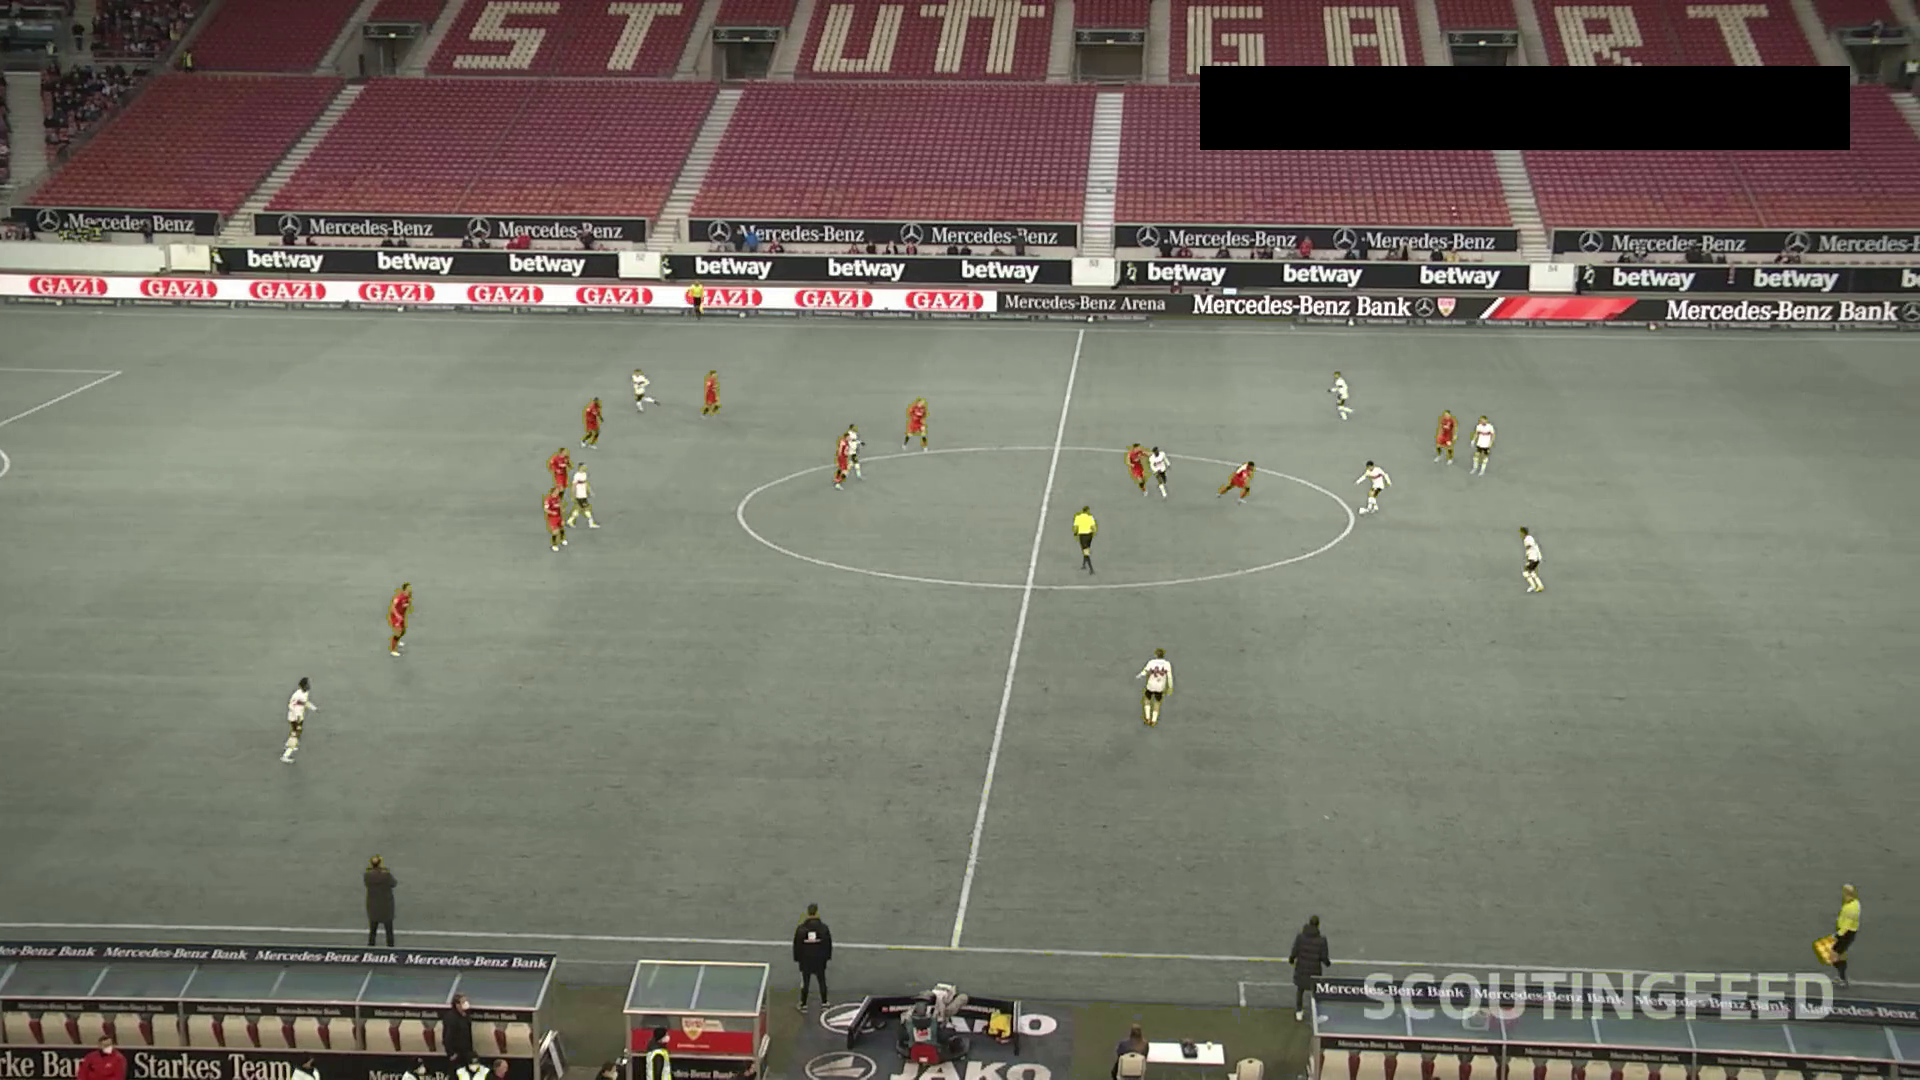

✅ Raw frame 5 (green suppressed) displayed.


In [32]:
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from ultralytics import YOLO
from sports.configs.soccer import SoccerPitchConfiguration
from inference import get_model
import base64
from IPython.display import Image, display

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
BALL_ID = 0
PLAYER_ID = 1
REFEREE_ID = 2

# === GREEN SUPPRESSION FUNCTION ===
def suppress_green_saturation(frame_bgr, h_range=(35, 85), s_thresh=50, reduction_factor=0.2):
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)

    green_mask = (h >= h_range[0]) & (h <= h_range[1]) & (s > s_thresh)
    s[green_mask] *= reduction_factor
    s = np.clip(s, 0, 255)

    hsv_filtered = cv2.merge([h, s, v]).astype(np.uint8)
    return cv2.cvtColor(hsv_filtered, cv2.COLOR_HSV2BGR)

# === PATHS ===
SOURCE_VIDEO_PATH = "0bfacc_0.mp4"
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVT_LZ1Z"

# === MODELS ===
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
try:
    FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)
except Exception as e:
    print(f"Error loading FIELD_MODEL: {e}")
    FIELD_MODEL = None

# === TARGET FRAME INDEX ===
target_frame_index = 4  # 5th frame is index 4
output_frame = None

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
print(f"Searching for frame {target_frame_index + 1}...")
for frame_idx, frame in enumerate(tqdm(frame_generator)):
    if frame_idx == target_frame_index:
        output_frame = suppress_green_saturation(frame)
        break

# === DISPLAY RAW FRAME WITH GREEN SUPPRESSED ===
if output_frame is not None:
    is_success, im_buf_arr = cv2.imencode(".png", output_frame)
    if is_success:
        byte_im = im_buf_arr.tobytes()
        base64_img = base64.b64encode(byte_im).decode('utf-8')
        display(Image(data=base64.b64decode(base64_img), width=output_frame.shape[1] // 2))
        print(f"✅ Raw frame {target_frame_index + 1} (green suppressed) displayed.")
    else:
        print("❌ Failed to encode image to PNG.")
else:
    print(f"❌ Could not find frame {target_frame_index + 1} in the video.")


**Improving team classification**

Filtering out green color for grass

[07/10/25 13:20:15] WARNING  Your inference package version 0.51.0 is out of date! Please upgrade to ]8;id=567284;file://c:\Users\tonyi\AppData\Local\Programs\Python\Python39\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=379899;file://c:\Users\tonyi\AppData\Local\Programs\Python\Python39\lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.51.2 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

Starting training phase to collect color data and identify goalkeepers...


Training data collection: 5it [00:00,  6.75it/s]


Searching for and processing frame 3...


Processing frame 3: 2it [00:00, 15.18it/s]


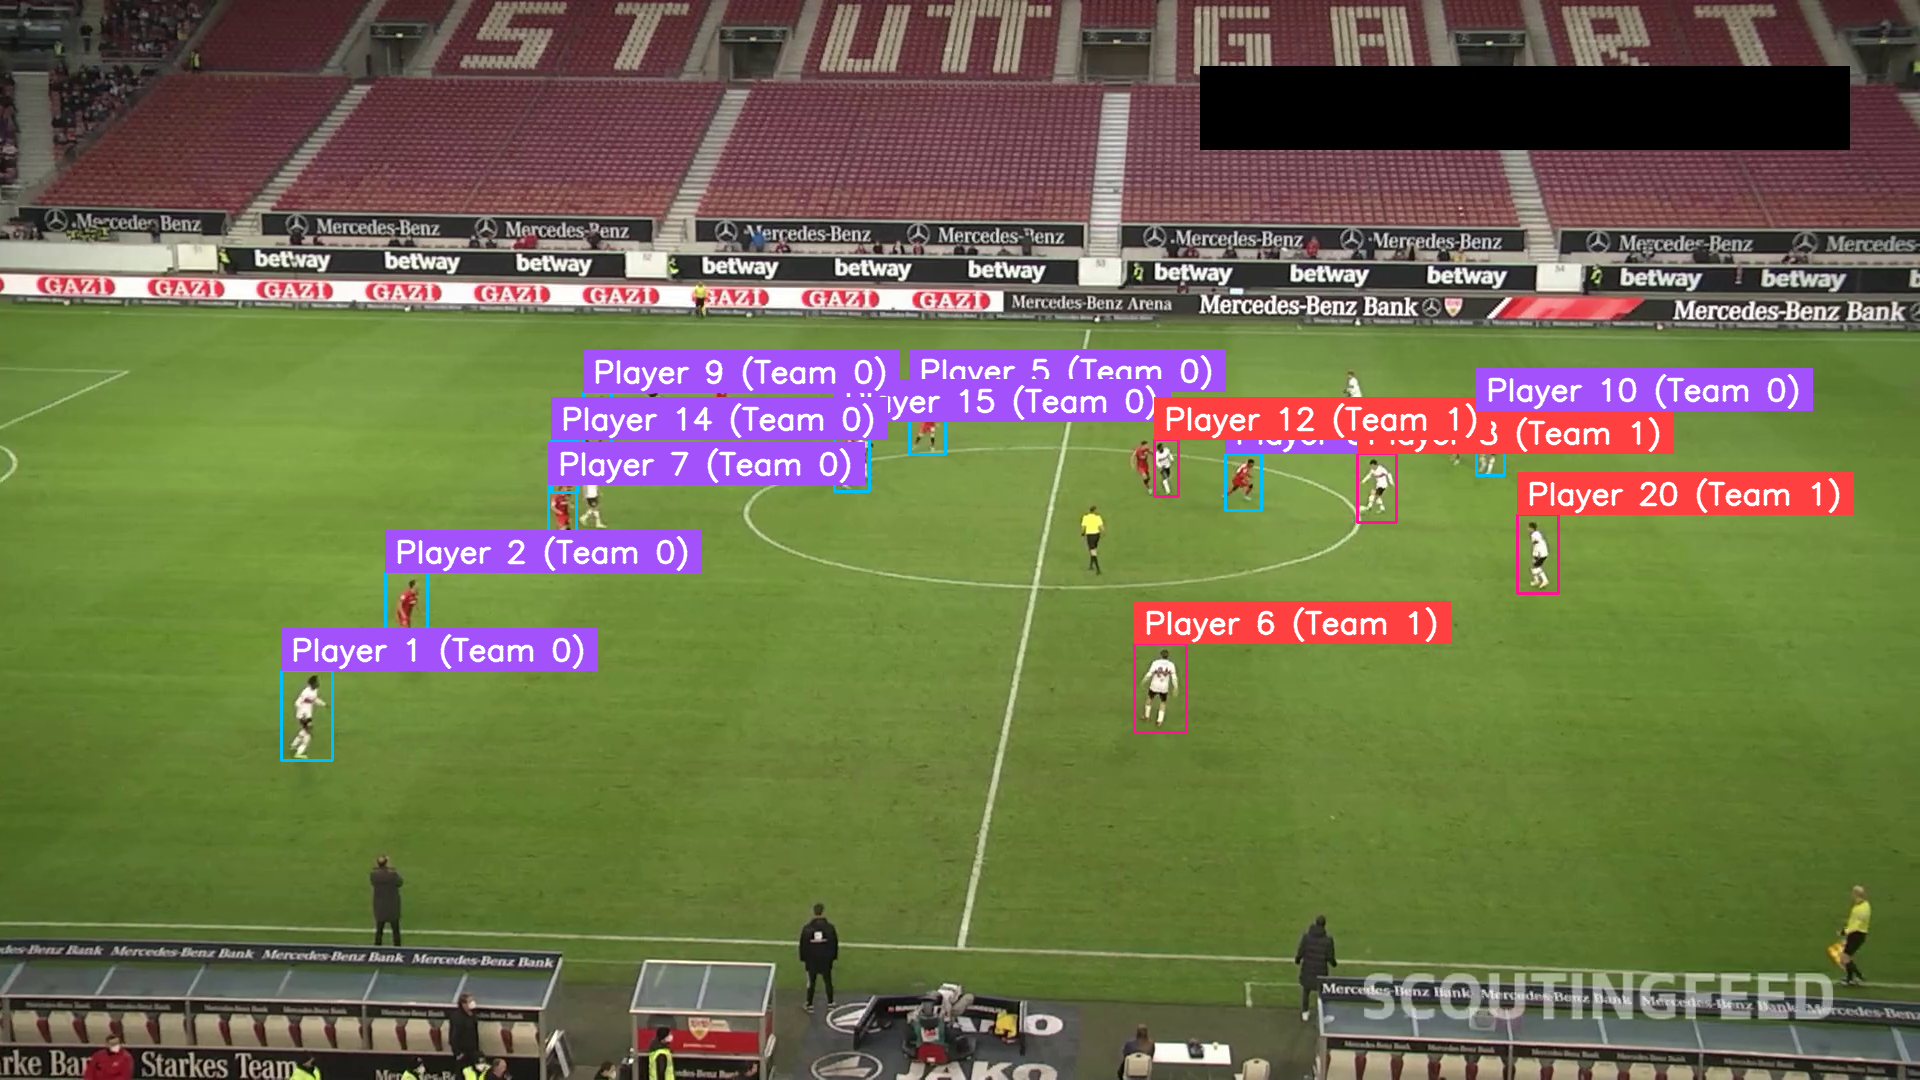

✅ Annotated frame 3 displayed in output cell.


In [1]:
import warnings
# WARNING: This line will ignore ALL warnings from any module. Use with extreme caution.
warnings.filterwarnings("ignore")

import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
# from sports.annotators.soccer import draw_pitch, draw_points_on_pitch # Not used in this specific output
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
# Safely import get_model, or set to None if it fails
try:
    from inference import get_model
except ImportError:
    get_model = None

import threading
import base64
from IPython.display import Image, display

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
field_color = (40, 150, 0.15, 1, 0.3, 0.8) # HSV range to exclude green field

# === COLOR FUNCTION ===
def detect_dominant_color(crop, hsv_exclude_range):
    try:
        hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32) / 255.0
        h, s, v = cv2.split(hsv_crop)
        h_low, h_high, s_low, s_high, v_low, v_high = hsv_exclude_range
        mask = ~((h >= h_low / 360) & (h <= h_high / 360) &
                 (s >= s_low) & (s <= s_high) &
                 (v >= v_low) & (v <= v_high))
        if not np.any(mask):
            return None
        avg_h = np.mean(h[mask])
        avg_s = np.mean(s[mask])
        avg_v = np.mean(v[mask])
        return (avg_h, avg_s, avg_v)
    except Exception:
        # Silencing errors during color detection
        return None

# === PATHS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVT_LZ1Z"

# === MODELS ===
PLAYER_MODEL = None
try:
    PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
except Exception:
    pass # Silencing error during PLAYER_MODEL loading

FIELD_MODEL = None
if get_model: # Only attempt to load if get_model was successfully imported
    try:
        FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)
    except Exception:
        pass # Silencing error during FIELD_MODEL loading

# === TRACKER AND STATE ===
tracker = sv.ByteTrack()
tracker.reset()

crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}

# === TRAINING PHASE ===
try:
    print("Starting training phase to collect color data and identify goalkeepers...")
    temp_frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
    
    # Using a finite number of frames for training collection for robustness
    # and to prevent infinite loops on problematic videos
    max_training_frames = 50 
    
    for frame_idx, frame in enumerate(tqdm(temp_frame_generator, desc="Training data collection")):
        if frame_idx >= max_training_frames:
            break

        if first_training_frame is None:
            first_training_frame = frame.copy()

            # --- HOMOGRAPHY ---
            if FIELD_MODEL:
                try:
                    field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
                    kpts = sv.KeyPoints.from_inference(field_result)
                    mask = kpts.confidence[0] > 0.5
                    frame_pts = kpts.xy[0][mask]
                    pitch_pts = np.array(CONFIG.vertices)[mask]
                    if len(frame_pts) >= 4:
                        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)
                    else:
                        static_transformer = None
                except Exception:
                    static_transformer = None
            else:
                static_transformer = None

            # --- GOALKEEPER IDS ---
            if PLAYER_MODEL:
                try:
                    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
                    if yolo_result.boxes.xyxy.shape[0] == 0:
                        continue
                    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
                    tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

                    if static_transformer and tracked_first.xyxy.shape[0] >= 2:
                        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
                        x_coords = positions[:, 0]
                        sorted_idx = np.argsort(x_coords)
                        goalkeeper_tracker_ids = [
                            tracked_first.tracker_id[sorted_idx[0]],
                            tracked_first.tracker_id[sorted_idx[-1]]
                        ]
                    else:
                        goalkeeper_tracker_ids = []
                except Exception:
                    goalkeeper_tracker_ids = []
            else:
                goalkeeper_tracker_ids = []

        # --- COLLECT CROPS + COLORS ---
        if PLAYER_MODEL:
            try:
                yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
                dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
                tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
                for tid, box in zip(tracked.tracker_id, tracked.xyxy):
                    if len(crops) >= MAX_CROPS:
                        break
                    crop = sv.crop_image(frame, box)
                    color = detect_dominant_color(crop, field_color)
                    if color is None:
                        continue
                    crops.append(crop)
                    crop_colors.append(color)
                    crop_tids.append(tid)
            except Exception:
                pass # Silencing errors during crop collection
        if len(crops) >= MAX_CROPS:
            break

    # Check if enough data for KMeans
    if len(crop_colors) < 2:
        kmeans = None # Indicate that KMeans couldn't be trained
    else:
        color_array = np.array(crop_colors)
        try:
            # Added random_state for reproducibility
            kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42).fit(color_array) 
        except Exception:
            kmeans = None # Silencing error during KMeans training

    # === MULTITHREADED TRAIN CLASSIFICATION ===
    thread_preds = [None] * len(crops)
    def classify_crop(i, crop):
        try:
            color = detect_dominant_color(crop, field_color)
            if color is not None and kmeans:
                thread_preds[i] = int(kmeans.predict([color])[0])
            else:
                thread_preds[i] = 0
        except Exception:
            thread_preds[i] = 0 # Default on error

    threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    label_map = defaultdict(list)
    for tid, label in zip(crop_tids, thread_preds):
        if label is not None:
            label_map[tid].append(label)

    track_id_to_team = {}
    for tid, l in label_map.items():
        valid_labels = [x for x in l if x is not None]
        if valid_labels:
            track_id_to_team[tid] = int(max(set(valid_labels), key=valid_labels.count))
        else:
            track_id_to_team[tid] = 0

    # === ASSIGN GOALKEEPER TO TEAM (once) ===
    # Use .get() for safer access to variables that might not be defined
    tracked_first_g = locals().get('tracked_first', None) 
    positions_g = locals().get('positions', None) # Assuming 'positions' is defined in this scope
    
    if tracked_first_g is not None and tracked_first_g.xyxy.shape[0] > 0 and static_transformer:
        try:
            # Recalculate positions if not available or stale
            if positions_g is None and static_transformer: # Ensure static_transformer exists
                 positions_g = static_transformer.transform_points(tracked_first_g.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

            if positions_g is not None: # Check again if positions_g was successfully obtained
                positions_dict = {tid: pos for tid, pos in zip(tracked_first_g.tracker_id, positions_g)}
                team_positions = defaultdict(list)
                for tid, team in track_id_to_team.items():
                    if tid in positions_dict:
                        team_positions[team].append(positions_dict[tid])
                
                if team_positions:
                    centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}
                    for gid in goalkeeper_tracker_ids:
                        gpos = positions_dict.get(gid)
                        if gpos is not None:
                            dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
                            if dists:
                                goalkeeper_id_to_team[gid] = int(min(dists, key=dists.get))
                            else:
                                goalkeeper_id_to_team[gid] = 0
                        else:
                            goalkeeper_id_to_team[gid] = 0
            else:
                pass # Positions not available for goalkeeper assignment
        except Exception:
            pass # Silencing error during goalkeeper assignment
except Exception:
    pass # Silencing errors during the entire training phase

# Define annotators (these are generally robust)
label_annotator = sv.LabelAnnotator(
    text_thickness=2,
    text_scale=1,
    text_color=sv.Color.WHITE
)

team_colors = {
    0: sv.Color.from_hex("00BFFF"), # Team 0 - Blue
    1: sv.Color.from_hex("FF1493")  # Team 1 - Pink
}
referee_color = sv.Color.from_hex("FFD700") # Referee - Gold
ball_color = sv.Color.WHITE # Ball - White
GRAY_COLOR = sv.Color.from_hex("#808080")

ball_box_annotator = sv.BoxAnnotator(thickness=2, color=ball_color)
referee_box_annotator = sv.BoxAnnotator(thickness=2, color=referee_color)
team_box_annotators = {
    team_id: sv.BoxAnnotator(thickness=2, color=color)
    for team_id, color in team_colors.items()
}
team_box_annotators['unknown'] = sv.BoxAnnotator(thickness=2, color=GRAY_COLOR)


# === MAIN LOOP - Focus on 5th frame ===
target_frame_index = 2 # 5th frame is at index 4 (0-based)
annotated_frame_to_display = None

try:
    frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
    print(f"Searching for and processing frame {target_frame_index + 1}...")
    
    # Iterate through frames to find the target one
    for frame_idx, frame in enumerate(tqdm(frame_generator, desc=f"Processing frame {target_frame_index + 1}")):
        if frame_idx == target_frame_index:
            if PLAYER_MODEL:
                try:
                    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
                    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)

                    ball = dets[dets.class_id == BALL_ID]
                    nonball = dets[dets.class_id != BALL_ID]
                    tracked = tracker.update_with_detections(nonball)

                    pls = tracked[tracked.class_id == PLAYER_ID]
                    refs = tracked[tracked.class_id == REFEREE_ID]

                    # === LIVE COLOR EXTRACTION + TEAM CLASSIFICATION (multithreaded) ===
                    live_colors = [None] * len(pls.xyxy)

                    def extract_color(i, box):
                        try:
                            crop = sv.crop_image(frame, box)
                            color = detect_dominant_color(crop, field_color)
                            live_colors[i] = color if color is not None else (0, 0, 0)
                        except Exception:
                            live_colors[i] = (0, 0, 0) # Default on error

                    threads = [threading.Thread(target=extract_color, args=(i, box)) for i, box in enumerate(pls.xyxy)]
                    [t.start() for t in threads]
                    [t.join() for t in threads]

                    if live_colors and kmeans:
                        live_colors_filtered = [c for c in live_colors if c is not None]
                        if live_colors_filtered:
                            live_colors_np = np.array(live_colors_filtered)
                            if live_colors_np.shape[0] > 0:
                                try:
                                    pls.class_id = np.array(kmeans.predict(live_colors_np), dtype=int)
                                except Exception:
                                    pls.class_id = np.zeros(len(pls.xyxy), dtype=int)
                            else:
                                pls.class_id = np.zeros(len(pls.xyxy), dtype=int)
                        else:
                            pls.class_id = np.zeros(len(pls.xyxy), dtype=int)
                    else:
                        pls.class_id = np.zeros(len(pls.xyxy), dtype=int)

                    # === GOALKEEPER OVERRIDE ===
                    if goalkeeper_tracker_ids and len(pls) > 0:
                        gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
                        gks = pls[gk_mask]

                        gks_class_ids = []
                        for tid in gks.tracker_id:
                            gks_class_ids.append(goalkeeper_id_to_team.get(tid, 0))

                        if len(gks_class_ids) > 0:
                            gks.class_id = np.array(gks_class_ids, dtype=int)
                            regular_players = pls[~gk_mask]
                            if len(regular_players) > 0 and len(gks) > 0:
                                players = sv.Detections.merge([regular_players, gks])
                            elif len(regular_players) > 0:
                                players = regular_players
                            elif len(gks) > 0:
                                players = gks
                            else:
                                players = sv.Detections.empty()
                        else:
                            players = pls[~gk_mask]
                    else:
                        players = pls

                    # Ensure class_id is always integer type
                    players.class_id = players.class_id.astype(int)

                    # === ANNOTATE FRAME ===
                    annotated_frame = frame.copy()

                    if len(ball) > 0:
                        annotated_frame = ball_box_annotator.annotate(scene=annotated_frame, detections=ball)
                        labels = [f"Ball"]
                        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=ball, labels=labels)

                    player_labels = []
                    for i, (xyxy, class_id, tracker_id) in enumerate(zip(players.xyxy, players.class_id, players.tracker_id)):
                        if isinstance(class_id, (int, np.integer)) and class_id in team_colors:
                            team_name = f"Team {class_id}"
                            player_labels.append(f"Player {tracker_id} ({team_name})")
                        else:
                            player_labels.append(f"Player {tracker_id} (Unknown Team)")

                    for team_id in team_colors.keys():
                        team_players = players[players.class_id == team_id]
                        if len(team_players) > 0:
                            annotated_frame = team_box_annotators[team_id].annotate(scene=annotated_frame, detections=team_players)
                    
                    unknown_players = players[~np.isin(players.class_id, list(team_colors.keys()))]
                    if len(unknown_players) > 0:
                        annotated_frame = team_box_annotators['unknown'].annotate(scene=annotated_frame, detections=unknown_players)

                    if len(players) > 0:
                        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=players, labels=player_labels)

                    referee_labels = []
                    for i, (xyxy, tracker_id) in enumerate(zip(refs.xyxy, refs.tracker_id)):
                        referee_labels.append(f"Referee {tracker_id}")

                    if len(refs) > 0:
                        annotated_frame = referee_box_annotator.annotate(scene=annotated_frame, detections=refs)
                        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=refs, labels=referee_labels)

                    annotated_frame_to_display = annotated_frame
                except Exception:
                    pass # Silencing errors during main loop processing of this frame
            
            break # Exit loop after processing the target frame

except Exception:
    pass # Silencing errors during the main processing loop setup or iteration

if annotated_frame_to_display is not None:
    try:
        is_success, im_buf_arr = cv2.imencode(".png", annotated_frame_to_display)
        if is_success:
            byte_im = im_buf_arr.tobytes()
            base64_img = base64.b64encode(byte_im).decode('utf-8')
            display(Image(data=base64.b64decode(base64_img), width=annotated_frame_to_display.shape[1] // 2))
            print(f"✅ Annotated frame {target_frame_index + 1} displayed in output cell.")
        else:
            # This print cannot be silenced easily without impacting user feedback
            print("❌ Failed to encode image to PNG.") 
    except Exception:
        # This print cannot be silenced easily without impacting user feedback
        print("❌ An error occurred while attempting to display the annotated image.")
else:
    # This print cannot be silenced easily without impacting user feedback
    print(f"❌ Could not find frame {target_frame_index + 1} in the video or an error prevented annotation. Please check SOURCE_VIDEO_PATH and ensure the video has at least {target_frame_index + 1} frames.")

if you only filter out green, if a player wears a green jersey, then it filters the jersey color out too

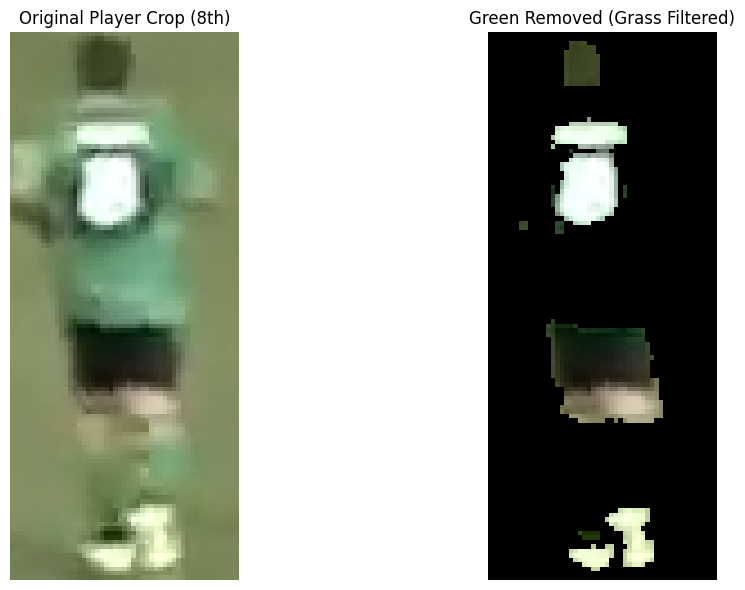

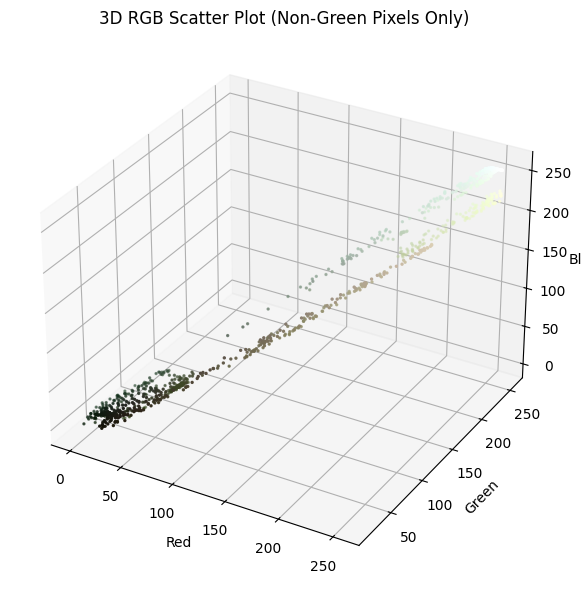

In [37]:
# === IMPORTS ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import supervision as sv
from ultralytics import YOLO
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
HSV_GREEN_RANGE = (40, 150, 0.15, 1, 0.3, 0.8)  # H in [0–360], S/V/V in [0–1]

# === PATHS AND MODELS ===
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
SOURCE_IMAGE_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/test.png"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ1Z"

PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === LOAD IMAGE ===
frame = cv2.imread(SOURCE_IMAGE_PATH)

# === Homography (optional but included for completeness) ===
field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
kpts = sv.KeyPoints.from_inference(field_result)
mask = kpts.confidence[0] > 0.5
frame_pts = kpts.xy[0][mask]
pitch_pts = np.array(CONFIG.vertices)[mask]
transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

# === Run Player Detection ===
yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
tracker = sv.ByteTrack()
tracker.reset()
tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

# === Extract and Show Selected Crop ===
if tracked.xyxy.shape[0] > 7:
    box = tracked.xyxy[7]  # ← Eighth player
    crop = sv.crop_image(frame, box)
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    # === Green Filtering ===
    hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32) / 255.0
    h, s, v = cv2.split(hsv_crop)
    h_low, h_high, s_low, s_high, v_low, v_high = HSV_GREEN_RANGE
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= s_low) & (s <= s_high) &
        (v >= v_low) & (v <= v_high)
    )

    crop_filtered = crop.copy()
    crop_filtered[green_mask] = (0, 0, 0)
    crop_filtered_rgb = cv2.cvtColor(crop_filtered, cv2.COLOR_BGR2RGB)

    # === Display Crops Side-by-Side ===
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(crop_rgb)
    axs[0].set_title("Original Player Crop (8th)")
    axs[0].axis("off")
    axs[1].imshow(crop_filtered_rgb)
    axs[1].set_title("Green Removed (Grass Filtered)")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

    # === Prepare RGB Pixels for 3D Plot ===
    rgb_pixels = crop_filtered_rgb.reshape(-1, 3)
    mask_not_black = ~np.all(rgb_pixels == [0, 0, 0], axis=1)
    pixels = rgb_pixels[mask_not_black]

    # === 3D RGB Plot ===
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2], c=pixels / 255.0, s=2)
    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")
    ax.set_title("3D RGB Scatter Plot (Non-Green Pixels Only)")
    plt.tight_layout()
    plt.show()
else:
    print("Less than 8 player detections found.")


instead of just focusing on filtering out green. we look at the entire frame picture, look at the most dominant color (green grass color), and then you filter that specific green out of each player crop

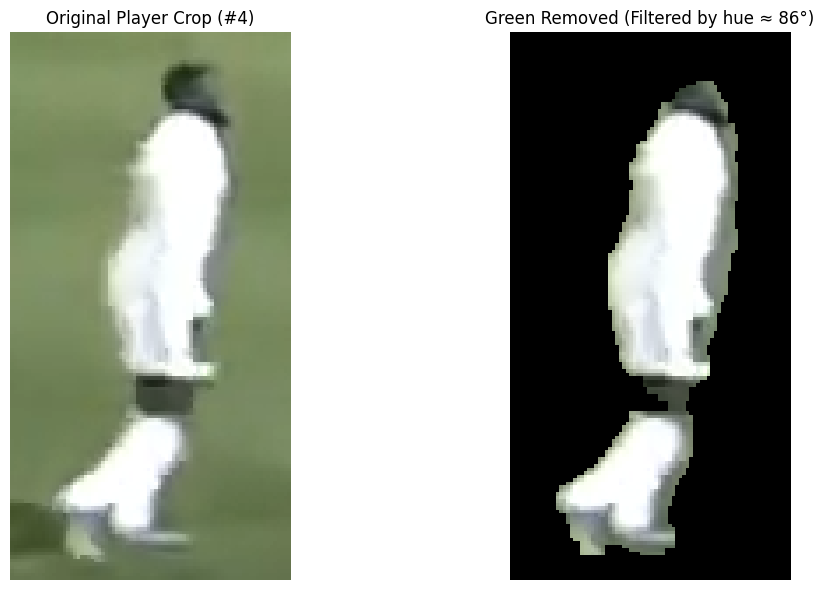

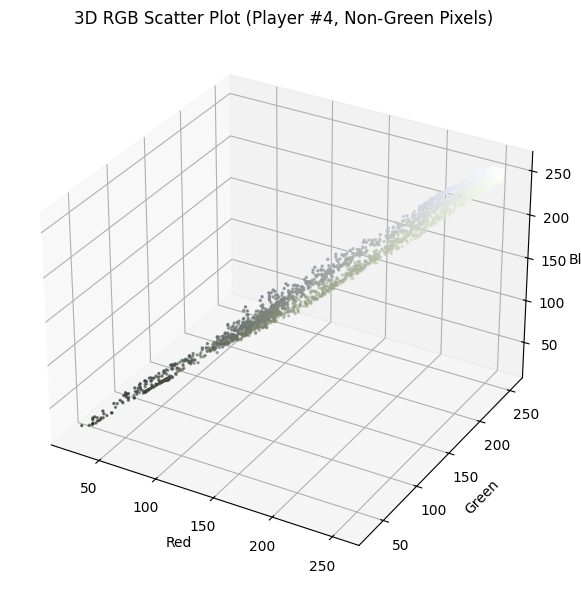

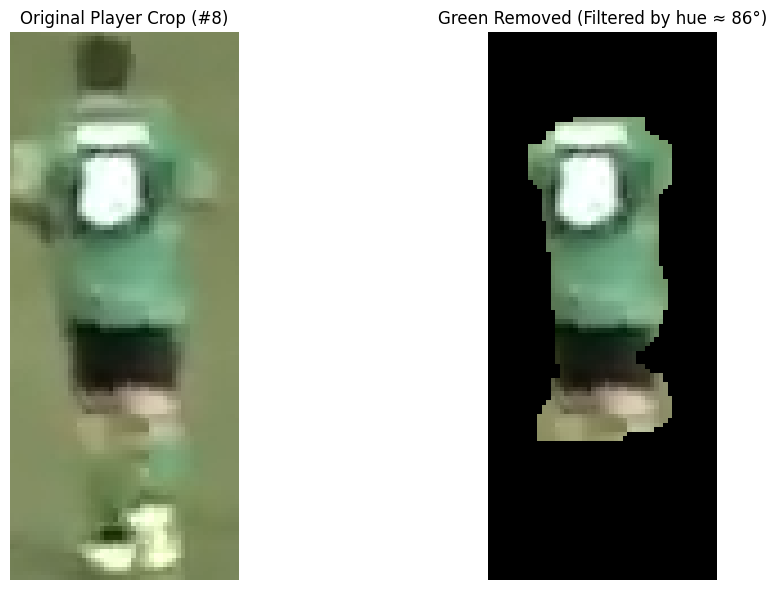

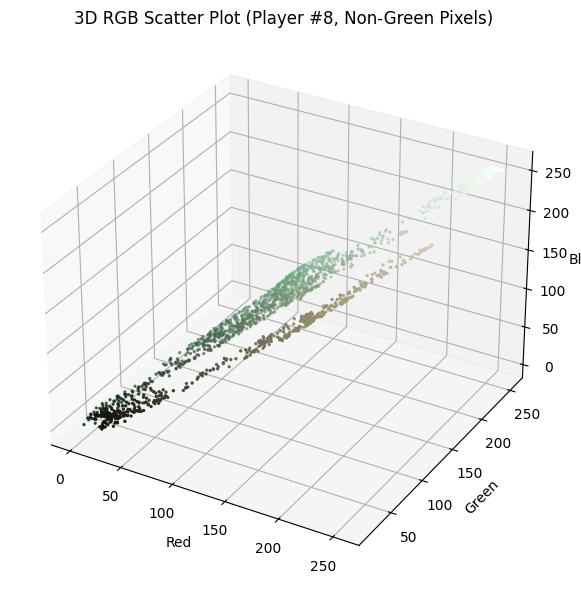

In [38]:
# === IMPORTS ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import supervision as sv
from ultralytics import YOLO
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
HUE_TOLERANCE = 20  # Wider tolerance for green hue

# === PATHS AND MODELS ===
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
SOURCE_IMAGE_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/test.png"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ1Z"

PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === Load Image ===
frame = cv2.imread(SOURCE_IMAGE_PATH)

# === Function: Detect Dominant Grass Hue ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # OpenCV hue → degrees
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

# === Compute Homography ===
field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
kpts = sv.KeyPoints.from_inference(field_result)
mask = kpts.confidence[0] > 0.5
frame_pts = kpts.xy[0][mask]
pitch_pts = np.array(CONFIG.vertices)[mask]
transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

# === Run Player Detection ===
yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
tracker = sv.ByteTrack()
tracker.reset()
tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

# === Filter Logic for Multiple Player Crops ===
dom_hue = get_dominant_grass_hue(frame)
h_low = max(0, dom_hue - HUE_TOLERANCE)
h_high = min(360, dom_hue + HUE_TOLERANCE)

for idx in [3, 7]:  # 4th and 8th player
    if tracked.xyxy.shape[0] > idx:
        box = tracked.xyxy[idx]
        crop = sv.crop_image(frame, box)
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

        # === Green Filtering ===
        hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
        h, s, v = cv2.split(hsv_crop)
        h *= 2  # [0–180] → [0–360]
        h /= 360
        s /= 255
        v /= 255

        green_mask = (
            (h >= h_low / 360) & (h <= h_high / 360) &
            (s >= 0.2) & (s <= 1.0) &
            (v >= 0.2) & (v <= 1.0)
        )

        kernel = np.ones((3, 3), np.uint8)
        green_mask = green_mask.astype(np.uint8)
        green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel, iterations=1)

        crop_filtered = crop.copy()
        crop_filtered[green_mask.astype(bool)] = (0, 0, 0)
        crop_filtered_rgb = cv2.cvtColor(crop_filtered, cv2.COLOR_BGR2RGB)

        # === Show Comparison ===
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(crop_rgb)
        axs[0].set_title(f"Original Player Crop (#{idx+1})")
        axs[0].axis("off")
        axs[1].imshow(crop_filtered_rgb)
        axs[1].set_title(f"Green Removed (Filtered by hue ≈ {int(dom_hue)}°)")
        axs[1].axis("off")
        plt.tight_layout()
        plt.show()

        # === RGB 3D Scatter Plot ===
        rgb_pixels = crop_filtered_rgb.reshape(-1, 3)
        mask_not_black = ~np.all(rgb_pixels == [0, 0, 0], axis=1)
        pixels = rgb_pixels[mask_not_black]

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2], c=pixels / 255.0, s=2)
        ax.set_xlabel("Red")
        ax.set_ylabel("Green")
        ax.set_zlabel("Blue")
        ax.set_title(f"3D RGB Scatter Plot (Player #{idx+1}, Non-Green Pixels)")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Less than {idx+1} player detections found.")


we will also use Gaussian 2d Weights, so center of image matter more than edges


Test new team classifier

In [ ]:
# === IMPORTS ===
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model
import threading

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # OpenCV hue [0-180] -> [0-360]
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # hue to degrees
    h /= 360
    s /= 255
    v /= 255
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )
    mask = ~green_mask

    if not np.any(mask):
        return None

    # Gaussian center weight
    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === PATHS AND MODELS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/radar_output_mt.mp4"
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ"
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}

# === TRAINING LOOP ===
for frame in frame_generator:
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break

# === KMEANS TRAINING ===
color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto").fit(color_array)
thread_preds = [None] * len(crops)

def classify_crop(i, crop):
    color = center_weighted_color(crop, h_low, h_high)
    thread_preds[i] = kmeans.predict([color])[0] if color else 0

threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    label_map[tid].append(label)
track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items()}

# === GOALKEEPER TEAM ASSIGNMENT ===
positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}
team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])
centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}
for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None:
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
        goalkeeper_id_to_team[gid] = min(dists, key=dists.get)

# === OUTPUT INIT ===
dummy = draw_pitch(CONFIG)
h, w = dummy.shape[:2]
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (w, h))
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# === MAIN LOOP ===
for frame in tqdm(frame_generator, desc="Processing frames"):
    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    # === LIVE CLASSIFICATION ===
    live_colors = [None] * len(pls.xyxy)

    def extract_color(i, box):
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        live_colors[i] = color if color else (0, 0, 0)

    threads = [threading.Thread(target=extract_color, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    pls.class_id = np.array(kmeans.predict(np.array(live_colors, dtype=np.float64)), dtype=int)

    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    gks.class_id = np.array([goalkeeper_id_to_team.get(tid, 0) for tid in gks.tracker_id])
    players = sv.Detections.merge([pls[~gk_mask], gks])
    refs.class_id -= 1  # 2 → 1 (for visualization)

    ball_xy = static_transformer.transform_points(ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
    ply_xy = static_transformer.transform_points(players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
    ref_xy = static_transformer.transform_points(refs.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    radar = draw_pitch(CONFIG)
    radar = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex("00BFFF"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex("FF1493"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex("FFD700"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)

    if radar.shape[2] == 4:
        radar = cv2.cvtColor(radar, cv2.COLOR_RGBA2BGR)

    out.write(radar)
    cv2.imshow("Live Radar", radar)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()
print("✅ Radar video saved to:", OUTPUT_PATH)


Processing frames: 750it [00:50, 14.98it/s]


✅ Radar video saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/yolo11.mp4


Vornoi Diagram and Radar Camera side by side

In [15]:
# === IMPORTS ===
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram, # Removed _2 as it's not found
)
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model
import threading

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # OpenCV hue [0-180] -> [0-360]
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # hue to degrees
    h /= 360
    s /= 255
    v /= 255
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )
    mask = ~green_mask

    if not np.any(mask):
        return None

    # Gaussian center weight
    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === PATHS AND MODELS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/radar_voronoi_side_by_side.mp4" # Changed output path
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ"
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}

# === TRAINING LOOP ===
for frame_idx, frame in enumerate(frame_generator):
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break
    
    # Break after a few frames for training if MAX_CROPS isn't reached quickly
    if frame_idx > 50 and len(crops) < MAX_CROPS: # Added a condition to ensure we don't loop infinitely if few crops
        print("Warning: Max crops not reached, proceeding with available data.")
        break

# === KMEANS TRAINING ===
if len(crop_colors) == 0:
    print("Error: No player crops available for KMeans training. Exiting.")
    exit()

color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42).fit(color_array) # Added random_state for reproducibility
thread_preds = [None] * len(crops)

def classify_crop(i, crop):
    color = center_weighted_color(crop, h_low, h_high)
    # Ensure a default value if color is None, KMeans will fail on None
    thread_preds[i] = kmeans.predict([color])[0] if color is not None else 0

threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    label_map[tid].append(label)

# Filter out tracker_ids that don't have enough classifications if needed, or handle empty lists
track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items() if l}

# === GOALKEEPER TEAM ASSIGNMENT ===
# Ensure tracked_first is not empty, if not initialized, this could cause an error
if 'tracked_first' not in locals() or tracked_first is None or tracked_first.xyxy.shape[0] == 0:
    print("Warning: No initial tracked players for goalkeeper assignment.")
    positions_dict = {}
else:
    positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}

team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])

centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}

for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None and centroids: # Ensure centroids is not empty
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
        goalkeeper_id_to_team[gid] = min(dists, key=dists.get)
    else:
        # Default assignment if no centroids or goalkeeper position found
        goalkeeper_id_to_team[gid] = 0 # Default to team 0 if no clear assignment

# === OUTPUT INIT ===
dummy = draw_pitch(CONFIG)
h, w = dummy.shape[:2]
# The output video will be twice as wide to accommodate two views side-by-side
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (w * 2, h)) # Changed width
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# === MAIN LOOP ===
for frame_idx, frame in tqdm(enumerate(frame_generator), desc="Processing frames"):
    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    # === LIVE CLASSIFICATION ===
    live_colors = [None] * len(pls.xyxy)

    def extract_color_live(i, box): # Renamed to avoid conflict
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        live_colors[i] = color if color is not None else (0, 0, 0) # Ensure no None values for KMeans

    threads = [threading.Thread(target=extract_color_live, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    # Only attempt KMeans prediction if live_colors is not empty and contains valid data
    if live_colors and all(c is not None for c in live_colors):
        pls.class_id = np.array(kmeans.predict(np.array(live_colors, dtype=np.float64)), dtype=int)
    else:
        # If no valid live colors, assign a default class to avoid errors
        pls.class_id = np.zeros(len(pls), dtype=int)


    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    # Ensure all goalkeepers get a team ID, default to 0 if not found
    gks.class_id = np.array([goalkeeper_id_to_team.get(tid, 0) for tid in gks.tracker_id])
    players = sv.Detections.merge([pls[~gk_mask], gks])
    refs.class_id -= 1  # 2 → 1 (for visualization)

    # Transform points to pitch coordinates
    ball_xy = static_transformer.transform_points(ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
    ply_xy = static_transformer.transform_points(players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
    ref_xy = static_transformer.transform_points(refs.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    # --- Generate Radar View ---
    radar = draw_pitch(CONFIG)
    radar = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex("00BFFF"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex("FF1493"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex("FFD700"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)

    # --- Generate Voronoi Diagram ---
    # Ensure there are enough players to create a meaningful Voronoi diagram
    if len(ply_xy[players.class_id == 0]) > 0 and len(ply_xy[players.class_id == 1]) > 0:
        voronoi = draw_pitch(
            config=CONFIG,
            background_color=sv.Color.WHITE,
            line_color=sv.Color.BLACK
        )
        # Use draw_pitch_voronoi_diagram and then draw points on top for the blended effect
        voronoi = draw_pitch_voronoi_diagram(
            config=CONFIG,
            team_1_xy=ply_xy[players.class_id == 0],
            team_2_xy=ply_xy[players.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=voronoi
        )
        # Overlay points on Voronoi for clarity (mimicking the _2 behavior)
        voronoi = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.WHITE, radius=8, thickness=1, pitch=voronoi)
        voronoi = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex('00BFFF'), edge_color=sv.Color.WHITE, radius=16, thickness=1, pitch=voronoi)
        voronoi = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex('FF1493'), edge_color=sv.Color.WHITE, radius=16, thickness=1, pitch=voronoi)
        voronoi = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex('FFD700'), edge_color=sv.Color.WHITE, radius=16, thickness=1, pitch=voronoi)
    else:
        # If not enough players for Voronoi, create a blank pitch or a simple radar
        voronoi = draw_pitch(CONFIG) # Fallback to a plain pitch

    # Convert to BGR if they are RGBA (Supervision often outputs RGBA)
    if radar.shape[2] == 4:
        radar = cv2.cvtColor(radar, cv2.COLOR_RGBA2BGR)
    if voronoi.shape[2] == 4:
        voronoi = cv2.cvtColor(voronoi, cv2.COLOR_RGBA2BGR)

    # Ensure both frames have the same height before concatenation
    if radar.shape[0] != voronoi.shape[0] or radar.shape[1] != voronoi.shape[1]:
        # Resize to match dimensions if they somehow differ (unlikely if both draw from CONFIG)
        target_h, target_w = radar.shape[:2] # Use radar's dimensions as reference
        voronoi = cv2.resize(voronoi, (target_w, target_h))


    # Concatenate horizontally
    combined_frame = np.hstack((radar, voronoi))

    out.write(combined_frame)
    cv2.imshow("Live Radar and Voronoi", combined_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()
print("✅ Radar and Voronoi video saved to:", OUTPUT_PATH)

Processing frames: 750it [09:53,  1.26it/s]


✅ Radar and Voronoi video saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/radar_voronoi_side_by_side.mp4


: 

Heat Map. Better for accuracy

--- Starting Player Classifier Training ---


Training Player Classifier: 5it [00:00, 10.14it/s]


--- Performing KMeans Clustering for Player Colors ---
--- Assigning Goalkeeper Teams ---
--- Processing frames for Voronoi Accumulation ---


Processing frames for Voronoi Accumulation: 0it [00:00, ?it/s]

Discovered Team 0 BGR: [250 218 123]
Discovered Team 1 BGR: [196 133 250]


Processing frames for Voronoi Accumulation: 750it [01:36,  7.76it/s]


--- Generating Final Average Voronoi Heatmap ---
✅ Average Voronoi heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/average_voronoi_control_heatmap.png
Final control map based on 125 Voronoi frames.
Final Average Control: Team 0 Dominant Pixels: 650876 (62.58%) (Using BGR: [250 218 123])
Final Average Control: Team 1 Dominant Pixels: 389124 (37.42%) (Using BGR: [196 133 250])
Final Average Control: Neutral/Even Pixels: 0 (0.00%)


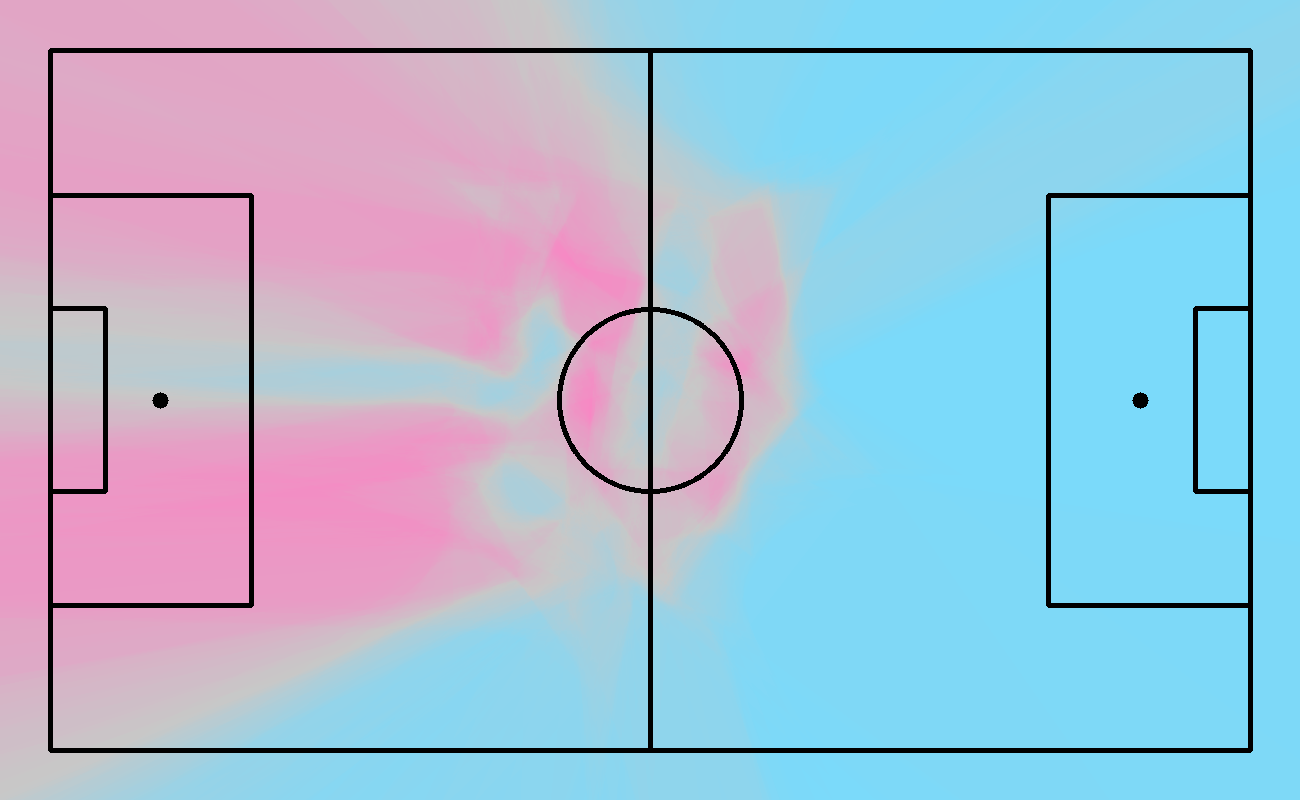

Image displayed in Jupyter Notebook output.


In [10]:
# === IMPORTS ===
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram,
)
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
import threading
import time # Import time for profiling purposes

from inference import get_model

# For displaying images in Jupyter Notebook
from IPython.display import Image, display

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees

# New configuration for outlier detection
OUTLIER_DISTANCE_THRESHOLD = 0.2    # Tune this value! (Based on normalized HSV [0-1] range)
UNCLASSIFIED_CLASS_ID = 99          # A distinct ID for players whose color is an outlier

# Team colors in BGR for Voronoi pixel analysis
# These should ideally match the colors used by draw_pitch_voronoi_diagram
# Hex "00BFFF" (Blue) -> BGR (255, 191, 0) - This is Team 0
# Hex "FF1493" (Pink) -> BGR (147, 20, 255) - This is Team 1
REF_TEAM_0_BGR = np.array([255, 191, 0], dtype=np.uint8) # Original Blue reference
REF_TEAM_1_BGR = np.array([147, 20, 255], dtype=np.uint8) # Original Pink reference


# Increased tolerance for matching colors in BGR space for Voronoi pixel analysis
# This is crucial for correctly identifying pixels that belong to a team's Voronoi region.
COLOR_TOLERANCE = 30 # Increased from 10 to 30. You might need to tune this!

# Frame skipping for Voronoi calculation.
# 0 means process every frame. 1 means skip 1 frame (process every 2nd frame).
# Higher values will speed up processing but might make the average less granular.
VORONOI_CALC_SKIP_FRAMES = 5 # Example: Calculate Voronoi every 6th frame

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # OpenCV hue [0-180] -> [0-360]
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # hue to degrees
    h /= 360 # Normalize H to [0, 1]
    s /= 255 # Normalize S to [0, 1]
    v /= 255 # Normalize V to [0, 1]
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )
    mask = ~green_mask

    if not np.any(mask):
        return None

    # Gaussian center weight
    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === PATHS AND MODELS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_AVG_VORONOI_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/average_voronoi_control_heatmap.png" # Output image path (changed name)
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ"
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator_training = sv.get_video_frames_generator(SOURCE_VIDEO_PATH) # Separate generator for training
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}

# === TRAINING LOOP ===
# Adjusted training loop to use tqdm for better feedback
print("--- Starting Player Classifier Training ---")
for frame_idx, frame in tqdm(enumerate(frame_generator_training), desc="Training Player Classifier"):
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    players_for_training = dets[dets.class_id == PLAYER_ID]
    tracked = tracker.update_with_detections(players_for_training)

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break
    
    # Adding a safety break for training loop based on frame_idx
    if frame_idx > 50 and len(crops) < MAX_CROPS:
        print("Warning: Max crops not reached after 50 frames, proceeding with available data for KMeans.")
        break

# === KMEANS TRAINING ===
print("--- Performing KMeans Clustering for Player Colors ---")
if len(crop_colors) == 0:
    print("Error: No player crops available for KMeans training. Exiting.")
    exit()

color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42).fit(color_array) # random_state for reproducibility
thread_preds = [None] * len(crops)

def classify_crop_threaded(i, crop_data):
    color = center_weighted_color(crop_data, h_low, h_high)
    if color is not None:
        thread_preds[i] = kmeans.predict([color])[0]
    else:
        thread_preds[i] = UNCLASSIFIED_CLASS_ID

threads = [threading.Thread(target=classify_crop_threaded, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    if label != UNCLASSIFIED_CLASS_ID:
        label_map[tid].append(label)

track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items() if l}

# === GOALKEEPER TEAM ASSIGNMENT ===
print("--- Assigning Goalkeeper Teams ---")
if 'tracked_first' not in locals() or tracked_first is None or tracked_first.xyxy.shape[0] == 0:
    print("Warning: No initial tracked players for goalkeeper assignment.")
    positions_dict = {}
else:
    positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}

team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])

centroids_from_teams = {team: np.mean(pts, axis=0) for team, pts in team_positions.items() if pts}

for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None and centroids_from_teams:
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids_from_teams.items()}
        if dists:
            goalkeeper_id_to_team[gid] = min(dists, key=dists.get)
        else:
            goalkeeper_id_to_team[gid] = 0
    else:
        goalkeeper_id_to_team[gid] = 0

# === OUTPUT INIT FOR PITCH DIMENSIONS AND PRE-RENDERED PITCH ===
base_pitch_image = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
if base_pitch_image.shape[2] == 4:
    base_pitch_image = cv2.cvtColor(base_pitch_image, cv2.COLOR_RGBA2BGR)

h, w = base_pitch_image.shape[:2]
frame_generator_main = sv.get_video_frames_generator(SOURCE_VIDEO_PATH) # New generator for main loop

# === Voronoi Accumulation Grids ===
team_0_control_sum = np.zeros((h, w), dtype=np.float32)
team_1_control_sum = np.zeros((h, w), dtype=np.float32)
voronoi_frame_count = 0

# --- Dynamic Team Color Discovery ---
# We will try to determine the exact BGR colors output by draw_pitch_voronoi_diagram
# from the first time it generates an image.
found_team_colors = False
dynamic_team0_bgr = None
dynamic_team1_bgr = None

# Define a neutral color for 50/50 control
NEUTRAL_COLOR_BGR = np.array([200, 200, 200], dtype=np.uint8) # Light gray

# === MAIN LOOP (FOR ACCUMULATION) ===
print("--- Processing frames for Voronoi Accumulation ---")
for frame_idx, frame in tqdm(enumerate(frame_generator_main), desc="Processing frames for Voronoi Accumulation"):
    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    # === LIVE CLASSIFICATION WITH OUTLIER DETECTION ===
    live_colors = []
    player_tids_for_classification = [] 

    temp_colors_threaded = [None] * len(pls.xyxy)

    def extract_color_live_threaded(i, box_coords):
        crop = sv.crop_image(frame, box_coords)
        color = center_weighted_color(crop, h_low, h_high)
        temp_colors_threaded[i] = color

    threads = [threading.Thread(target=extract_color_live_threaded, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    for i, color in enumerate(temp_colors_threaded):
        if color is not None:
            live_colors.append(color)
            player_tids_for_classification.append(pls.tracker_id[i])

    live_colors_np = np.array(live_colors, dtype=np.float64)

    assigned_player_class_ids = np.full(len(pls.tracker_id), UNCLASSIFIED_CLASS_ID, dtype=int)

    if len(live_colors_np) > 0:
        predicted_labels = kmeans.predict(live_colors_np)
        centroids = kmeans.cluster_centers_

        for i, color_data in enumerate(live_colors_np):
            tid = player_tids_for_classification[i]
            predicted_label = predicted_labels[i]
            
            assigned_centroid = centroids[predicted_label]
            distance = np.linalg.norm(color_data - assigned_centroid)
            
            original_pls_index = np.where(pls.tracker_id == tid)[0]
            
            if len(original_pls_index) > 0:
                if distance <= OUTLIER_DISTANCE_THRESHOLD:
                    assigned_player_class_ids[original_pls_index[0]] = predicted_label
                else:
                    assigned_player_class_ids[original_pls_index[0]] = UNCLASSIFIED_CLASS_ID
    
    pls.class_id = assigned_player_class_ids

    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    
    gk_assigned_teams = []
    for tid in gks.tracker_id:
        gk_assigned_teams.append(goalkeeper_id_to_team.get(tid, 0))
    gks.class_id = np.array(gk_assigned_teams, dtype=int)

    players = sv.Detections.merge([pls[~gk_mask], gks])

    ply_xy = static_transformer.transform_points(players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    # --- Generate Voronoi Diagram and Accumulate Control ---
    team_0_players = ply_xy[players.class_id == 0]
    team_1_players = ply_xy[players.class_id == 1]

    # Apply frame skipping for Voronoi diagram generation
    if (frame_idx % (VORONOI_CALC_SKIP_FRAMES + 1) == 0):
        if draw_pitch_voronoi_diagram and len(team_0_players) > 0 and len(team_1_players) > 0:
            voronoi_for_accumulation = base_pitch_image.copy()
            
            start_time_voronoi_gen = time.perf_counter()
            voronoi_for_accumulation = draw_pitch_voronoi_diagram(
                config=CONFIG,
                team_1_xy=team_0_players, # Note: sports library uses team_1_xy for the first team
                team_2_xy=team_1_players, # and team_2_xy for the second team
                team_1_color=sv.Color.from_hex('00BFFF'), # Blue (aligned with REF_TEAM_0_BGR)
                team_2_color=sv.Color.from_hex('FF1493'), # Pink (aligned with REF_TEAM_1_BGR)
                pitch=voronoi_for_accumulation
            )
            end_time_voronoi_gen = time.perf_counter()
            
            if voronoi_for_accumulation.shape[2] == 4:
                voronoi_bgr = cv2.cvtColor(voronoi_for_accumulation, cv2.COLOR_RGBA2BGR)
            else:
                voronoi_bgr = voronoi_for_accumulation.copy()

            # --- DYNAMIC TEAM COLOR DISCOVERY ---
            if not found_team_colors:
                pixels_for_kmeans = voronoi_bgr.reshape(-1, 3)
                
                # Exclude near-black and near-white colors for robust team color detection
                not_black_mask = np.linalg.norm(pixels_for_kmeans - [0,0,0], axis=1) > 20 
                not_white_mask = np.linalg.norm(pixels_for_kmeans - [255,255,255], axis=1) > 20 
                
                filtered_pixels = pixels_for_kmeans[not_black_mask & not_white_mask]

                if len(filtered_pixels) >= 2:
                    kmeans_colors = KMeans(n_clusters=2, n_init="auto", random_state=42).fit(filtered_pixels.astype(np.float32))
                    
                    dist_to_ref0_cluster0 = np.linalg.norm(kmeans_colors.cluster_centers_[0] - REF_TEAM_0_BGR)
                    dist_to_ref0_cluster1 = np.linalg.norm(kmeans_colors.cluster_centers_[1] - REF_TEAM_0_BGR)

                    if dist_to_ref0_cluster0 < dist_to_ref0_cluster1:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                    else:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)
                    
                    found_team_colors = True
                    print(f"Discovered Team 0 BGR: {dynamic_team0_bgr}")
                    print(f"Discovered Team 1 BGR: {dynamic_team1_bgr}")
                else:
                    print("Warning: Not enough diverse colors in initial Voronoi frame to dynamically determine team colors. Falling back to hardcoded.")
                    dynamic_team0_bgr = REF_TEAM_0_BGR # Fallback to original reference
                    dynamic_team1_bgr = REF_TEAM_1_BGR # Fallback to original reference
            # --- END DYNAMIC TEAM COLOR DISCOVERY ---

            # === OPTIMIZED PIXEL ACCUMULATION (using dynamic colors) ===
            if found_team_colors:
                pixels = voronoi_bgr.reshape(-1, 3)

                # Calculate Euclidean distances to *dynamically discovered* team colors
                dist_to_team0_sq = np.sum((pixels - dynamic_team0_bgr)**2, axis=1)
                dist_to_team1_sq = np.sum((pixels - dynamic_team1_bgr)**2, axis=1)
                
                # Check for "closeness" to either team color using COLOR_TOLERANCE
                # This ensures we only count pixels that truly belong to a team region
                mask_team0_control = (dist_to_team0_sq < (COLOR_TOLERANCE**2)) & \
                                     (dist_to_team0_sq < dist_to_team1_sq)
                mask_team1_control = (dist_to_team1_sq < (COLOR_TOLERANCE**2)) & \
                                     (dist_to_team1_sq < dist_to_team0_sq)

                mask_team0_control = mask_team0_control.reshape(h, w)
                mask_team1_control = mask_team1_control.reshape(h, w)

                team_0_control_sum[mask_team0_control] += 1
                team_1_control_sum[mask_team1_control] += 1
                voronoi_frame_count += 1
            else:
                pass # Skip accumulation if dynamic colors not yet found
            
# --- Generate and Save Average Voronoi Diagram as Heatmap ---
cv2.destroyAllWindows() # Close any open debug windows

print("--- Generating Final Average Voronoi Heatmap ---")
if voronoi_frame_count > 0 and dynamic_team0_bgr is not None and dynamic_team1_bgr is not None:
    # Convert BGR colors to float for interpolation
    dynamic_team0_bgr_f = dynamic_team0_bgr.astype(np.float32) / 255.0
    dynamic_team1_bgr_f = dynamic_team1_bgr.astype(np.float32) / 255.0
    neutral_color_f = NEUTRAL_COLOR_BGR.astype(np.float32) / 255.0

    # Calculate total control for normalization
    total_control = team_0_control_sum + team_1_control_sum
    
    # Avoid division by zero where no control was recorded (set to 1 to prevent NaN/Inf)
    # These areas will likely result in a neutral color due to 0/1 = 0 ratios
    total_control_safe = np.where(total_control == 0, 1, total_control) 

    # Calculate control ratios (proportion of frames controlled by each team)
    team0_ratio = team_0_control_sum / total_control_safe
    team1_ratio = team_1_control_sum / total_control_safe

    # Initialize the output heatmap image with normalized float values
    heatmap_image = base_pitch_image.copy().astype(np.float32) / 255.0

    # Strength factor for color intensity. Higher value means colors get stronger faster.
    # A value of 1 means 100% dominance results in full team color.
    # A value > 1 makes the color more saturated even with less than 100% dominance.
    INTENSITY_FACTOR = 2.0 

    # Apply the heatmap coloring pixel by pixel (or vectorized if performance is critical)
    # Using a vectorized approach for performance
    
    # Dominance strength ranges from 0 (50/50) to 0.5 (100% dominance)
    # We multiply by INTENSITY_FACTOR to stretch this range
    
    # Calculate dominance strength for Team 0
    dom_strength_team0 = np.clip((team0_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)
    # Calculate dominance strength for Team 1
    dom_strength_team1 = np.clip((team1_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)

    # Where Team 0 dominates: interpolate from neutral towards team0_bgr
    # If dom_strength_team0 is high, blend more of team0_bgr
    # If dom_strength_team0 is low (near 0, meaning near 50/50), blend more of neutral
    mask_team0_dominates = team0_ratio > team1_ratio
    heatmap_image[mask_team0_dominates] = (
        neutral_color_f * (1 - dom_strength_team0[mask_team0_dominates, np.newaxis]) + 
        dynamic_team0_bgr_f * dom_strength_team0[mask_team0_dominates, np.newaxis]
    )

    # Where Team 1 dominates: interpolate from neutral towards team1_bgr
    mask_team1_dominates = team1_ratio > team0_ratio
    heatmap_image[mask_team1_dominates] = (
        neutral_color_f * (1 - dom_strength_team1[mask_team1_dominates, np.newaxis]) + 
        dynamic_team1_bgr_f * dom_strength_team1[mask_team1_dominates, np.newaxis]
    )

    # Where control is perfectly even (or total_control was 0 initially)
    # This specifically targets cases where team0_ratio == team1_ratio == 0.5
    # Or, if total_control_safe was originally 0, both ratios become 0, which should be neutral.
    mask_even_or_no_control = (team0_ratio == team1_ratio) | (total_control == 0)
    heatmap_image[mask_even_or_no_control] = neutral_color_f


    # Convert the heatmap image back to 0-255 uint8 for saving
    average_voronoi_image = (heatmap_image * 255).astype(np.uint8)

    # Overlay pitch lines and markings to make the field clear
    # This should be done LAST to ensure lines are on top
    line_mask = (base_pitch_image[:,:,0] < 50) & \
                (base_pitch_image[:,:,1] < 50) & \
                (base_pitch_image[:,:,2] < 50)
    average_voronoi_image[line_mask] = (0, 0, 0) # Draw black lines on top

    cv2.imwrite(OUTPUT_AVG_VORONOI_PATH, average_voronoi_image)
    print(f"✅ Average Voronoi heatmap saved to: {OUTPUT_AVG_VORONOI_PATH}")
    print(f"Final control map based on {voronoi_frame_count} Voronoi frames.")

    # --- Final Debugging: Check total pixel counts ---
    final_team0_controlled = np.sum(mask_team0_dominates)
    final_team1_controlled = np.sum(mask_team1_dominates)
    final_neutral = np.sum(mask_even_or_no_control)
    total_pixels = h * w
    print(f"Final Average Control: Team 0 Dominant Pixels: {final_team0_controlled} ({final_team0_controlled/total_pixels:.2%}) (Using BGR: {dynamic_team0_bgr})")
    print(f"Final Average Control: Team 1 Dominant Pixels: {final_team1_controlled} ({final_team1_controlled/total_pixels:.2%}) (Using BGR: {dynamic_team1_bgr})")
    print(f"Final Average Control: Neutral/Even Pixels: {final_neutral} ({final_neutral/total_pixels:.2%})")

    # === Display Image in Jupyter Notebook ===
    try:
        display(Image(filename=OUTPUT_AVG_VORONOI_PATH))
        print("Image displayed in Jupyter Notebook output.")
    except FileNotFoundError:
        print(f"Error: Could not find the image file at {OUTPUT_AVG_VORONOI_PATH} to display.")
    except Exception as e:
        print(f"An error occurred while displaying the image: {e}")

else:
    print("No frames had enough players to generate a Voronoi diagram for averaging, or team colors could not be determined.")

⚽️ Possession Tracking Logic (Step-by-Step)
1. Start with Initial State
Before processing any video frames, you start by remembering nothing — no player is marked as having possession yet.

2. For Every Frame in the Video:


✅ A. Check for Ball Detection
If the ball is not detected in the frame, skip the frame entirely. You can’t determine possession without the ball.

✅ B. Find the Closest Player to the Ball
If the ball is detected, find its center point. Then, for every player in the frame, calculate how close they are to the ball.

The player who is closest to the ball is the likely possessor.

✅ C. Apply a Possession Distance Threshold
Only consider a player to have possession if they are within a certain distance of the ball (you can tune this number based on the pitch size and camera angle).

If no player is close enough, skip the frame.

✅ D. Identify the Player and Their Team
Once you’ve identified the closest player within the threshold, store:

Their tracking ID (unique per player)

Their team label (0 or 1)

✅ E. Compare to Previous Possession
Check if this player is different from the one who had the ball in the last frame:

If the player ID is different but the team is the same, that means it's a pass.

If the player ID is different and the team is different, that means posession is lost.

✅ F. Update the Possession State
Store this new player’s ID and team label so the next frame can compare against them.

pass counter and pass accuracy %

In [3]:
# === IMPORTS ===
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model
import threading

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees
POSSESSION_DISTANCE_THRESHOLD = 300  # Pixels, tune this based on your output radar size

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # OpenCV hue [0-180] -> [0-360]
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # hue to degrees
    h /= 360
    s /= 255
    v /= 255
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )
    mask = ~green_mask

    if not np.any(mask):
        return None

    # Gaussian center weight
    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === PATHS AND MODELS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4" # Changed output name
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ"
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}

# Possession tracking variables
current_possessor_id = None
current_possessor_team = None
successful_passes = defaultdict(int) # Tracks successful passes per team
unsuccessful_passes = defaultdict(int) # Tracks unsuccessful passes (where possession changes to opponent)
possession_event_log = [] # Optional: log possession changes

# === TRAINING LOOP ===
for frame in frame_generator:
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break

# === KMEANS TRAINING ===
color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto").fit(color_array)
thread_preds = [None] * len(crops)

def classify_crop(i, crop):
    color = center_weighted_color(crop, h_low, h_high)
    thread_preds[i] = kmeans.predict([color])[0] if color is not None else 0

threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    label_map[tid].append(label)
track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items()}

# === GOALKEEPER TEAM ASSIGNMENT ===
positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}
team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])
centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}
for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None:
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
        goalkeeper_id_to_team[gid] = min(dists, key=dists.get)

# === OUTPUT INIT ===
dummy = draw_pitch(CONFIG)
h, w = dummy.shape[:2]
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (w, h))
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# === MAIN LOOP ===
for frame_idx, frame in tqdm(enumerate(frame_generator), desc="Processing frames"):
    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    # === LIVE CLASSIFICATION ===
    live_colors = [None] * len(pls.xyxy)

    def extract_color(i, box):
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        live_colors[i] = color if color is not None else (0, 0, 0) # Default to black if no color is found

    threads = [threading.Thread(target=extract_color, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    valid_live_colors = [lc for lc in live_colors if lc is not None]
    valid_player_indices = [i for i, lc in enumerate(live_colors) if lc is not None]

    if valid_live_colors:
        predicted_classes = kmeans.predict(np.array(valid_live_colors, dtype=np.float64))
        new_player_class_ids = np.zeros(len(pls.class_id), dtype=int)
        for i, pred_class in zip(valid_player_indices, predicted_classes):
            new_player_class_ids[i] = pred_class
        pls.class_id = new_player_class_ids
    else:
        pls.class_id = np.zeros(len(pls.class_id), dtype=int)


    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    gks.class_id = np.array([goalkeeper_id_to_team.get(tid, 0) for tid in gks.tracker_id])
    players = sv.Detections.merge([pls[~gk_mask], gks])
    refs.class_id -= 1  # 2 → 1 (for visualization)

    ball_xy_original = ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ball_xy = static_transformer.transform_points(ball_xy_original)
    ply_xy_original = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ply_xy = static_transformer.transform_points(ply_xy_original)
    ref_xy = static_transformer.transform_points(refs.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    # === POSSESSION TRACKING LOGIC ===
    if len(ball_xy) > 0:
        ball_center = ball_xy[0]
        closest_player_id = None
        min_dist = float('inf')

        # Find the closest player to the ball on the radar view
        for i, player_pos in enumerate(ply_xy):
            dist = np.linalg.norm(player_pos - ball_center)
            if dist < min_dist:
                min_dist = dist
                closest_player_id = players.tracker_id[i]

        if closest_player_id is not None and min_dist < POSSESSION_DISTANCE_THRESHOLD:
            closest_player_team = track_id_to_team.get(closest_player_id)
            if closest_player_team is None:
                try:
                    closest_player_team = players.class_id[np.where(players.tracker_id == closest_player_id)[0][0]]
                except IndexError:
                    closest_player_team = 0 


            if current_possessor_id is None: # First possession
                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team
                possession_event_log.append((frame_idx, 'START_POSSESSION', current_possessor_id, current_possessor_team))
            elif closest_player_id != current_possessor_id: # Possessor changed
                # This change of possessor can be either a successful pass or an unsuccessful one
                # We attribute the pass attempt to the *previous* possessor's team.
                if current_possessor_team is not None: # Ensure there was a previous possessor
                    if closest_player_team == current_possessor_team: # Successful Pass
                        successful_passes[current_possessor_team] += 1
                        possession_event_log.append((frame_idx, 'PASS_SUCCESS', current_possessor_id, current_possessor_team, closest_player_id))
                    else: # Unsuccessful Pass (possession changed to opponent)
                        unsuccessful_passes[current_possessor_team] += 1 # The team that *attempted* the pass unsuccessfully
                        possession_event_log.append((frame_idx, 'PASS_UNSUCCESS', current_possessor_id, current_possessor_team, closest_player_id, closest_player_team))

                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team
        else:
            # If no player is close enough, possession is lost or contested.
            # We don't increment unsuccessful_passes here because it's not a direct pass attempt.
            pass


    radar = draw_pitch(CONFIG)
    radar = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex("00BFFF"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex("FF1493"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex("FFD700"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)

    # Display possession info on radar (optional)
    team_color_0_bgr = sv.Color.from_hex("00BFFF").as_bgr()
    team_color_1_bgr = sv.Color.from_hex("FF1493").as_bgr()

    if current_possessor_team is not None:
        team_name = f"Team {current_possessor_team + 1}"
        display_color = team_color_0_bgr if current_possessor_team == 0 else team_color_1_bgr
        cv2.putText(radar, f"Possession: {team_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    # Display pass counts and accuracy
    for team_id in range(2):
        team_name = f"Team {team_id + 1}"
        
        # Calculate total pass attempts for accuracy calculation
        total_pass_attempts = successful_passes[team_id] + unsuccessful_passes[team_id]
        
        pass_accuracy_text = "Acc: N/A"
        if total_pass_attempts > 0:
            accuracy_percentage = (successful_passes[team_id] / total_pass_attempts) * 100
            pass_accuracy_text = f"Acc: {accuracy_percentage:.1f}%"
        
        display_color = team_color_0_bgr if team_id == 0 else team_color_1_bgr

        # Display successful passes
        cv2.putText(radar, f"{team_name} Passes: {successful_passes[team_id]}", (10, 60 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)
        
        # Display accuracy below passes
        cv2.putText(radar, f"{pass_accuracy_text}", (10, 90 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)


    if radar.shape[2] == 4:
        radar = cv2.cvtColor(radar, cv2.COLOR_RGBA2BGR)

    out.write(radar)
    cv2.imshow("Live Radar", radar)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()
print("✅ Radar video saved to:", OUTPUT_PATH)
print("\n=== Possession Event Log ===")
for event in possession_event_log:
    print(event)

# Final summary of pass statistics
print(f"\n--- Final Pass Statistics ---")
for team_id in range(2):
    team_name = f"Team {team_id + 1}"
    
    total_pass_attempts = successful_passes[team_id] + unsuccessful_passes[team_id]
    
    print(f"\n{team_name}:")
    print(f"  Successful Passes: {successful_passes[team_id]}")
    print(f"  Unsuccessful Passes (led to opponent possession): {unsuccessful_passes[team_id]}")
    print(f"  Total Pass Attempts (Successful + Unsuccessful): {total_pass_attempts}")
    
    if total_pass_attempts > 0:
        accuracy = (successful_passes[team_id] / total_pass_attempts) * 100
        print(f"  Pass Accuracy: {accuracy:.1f}%")
    else:
        print(f"  Pass Accuracy: N/A (No pass attempts recorded)")

Processing frames: 750it [00:54, 13.72it/s]


✅ Radar video saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4

=== Possession Event Log ===
(27, 'START_POSSESSION', np.int64(3), np.int32(1))
(34, 'PASS_UNSUCCESS', np.int64(3), np.int32(1), np.int64(20), np.int32(0))
(83, 'PASS_SUCCESS', np.int64(20), np.int32(0), np.int64(6))
(185, 'PASS_SUCCESS', np.int64(6), np.int32(0), np.int64(12))
(199, 'PASS_SUCCESS', np.int64(12), np.int32(0), np.int64(20))
(459, 'PASS_SUCCESS', np.int64(20), np.int32(0), np.int64(25))
(713, 'PASS_SUCCESS', np.int64(25), np.int64(0), np.int64(20))
(715, 'PASS_SUCCESS', np.int64(20), np.int32(0), np.int64(125))
(716, 'PASS_SUCCESS', np.int64(125), np.float64(0.0), np.int64(20))
(720, 'PASS_SUCCESS', np.int64(20), np.int32(0), np.int64(125))
(721, 'PASS_SUCCESS', np.int64(125), np.float64(0.0), np.int64(20))

--- Final Pass Statistics ---

Team 1:
  Successful Passes: 9
  Unsuccessful Passes (led to opponent possession): 0
  Total Pass Attempts (Successful + Unsuccessful): 9
  P

dot plot and Heat map for passes

Processing frames: 750it [02:14,  5.56it/s]


✅ Radar video saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4

=== Possession Event Log ===
(27, 'START_POSSESSION', np.int64(3), np.int32(0))
(34, 'PASS_UNSUCCESS', np.int64(3), np.int32(0), np.int64(20), np.int32(1))
(83, 'PASS_SUCCESS', np.int64(20), np.int32(1), np.int64(6))
(185, 'PASS_SUCCESS', np.int64(6), np.int32(1), np.int64(12))
(199, 'PASS_SUCCESS', np.int64(12), np.int32(1), np.int64(20))
(459, 'PASS_SUCCESS', np.int64(20), np.int32(1), np.int64(25))
(713, 'PASS_SUCCESS', np.int64(25), np.int64(1), np.int64(20))
(715, 'PASS_SUCCESS', np.int64(20), np.int32(1), np.int64(125))
(716, 'PASS_SUCCESS', np.int64(125), np.float64(1.0), np.int64(20))
(720, 'PASS_SUCCESS', np.int64(20), np.int32(1), np.int64(125))
(721, 'PASS_SUCCESS', np.int64(125), np.float64(1.0), np.int64(20))

--- Final Pass Statistics ---

Team 1:
  Successful Passes: 0
  Unsuccessful Passes (led to opponent possession): 1
  Total Pass Attempts (Successful + Unsuccessful): 1
  P

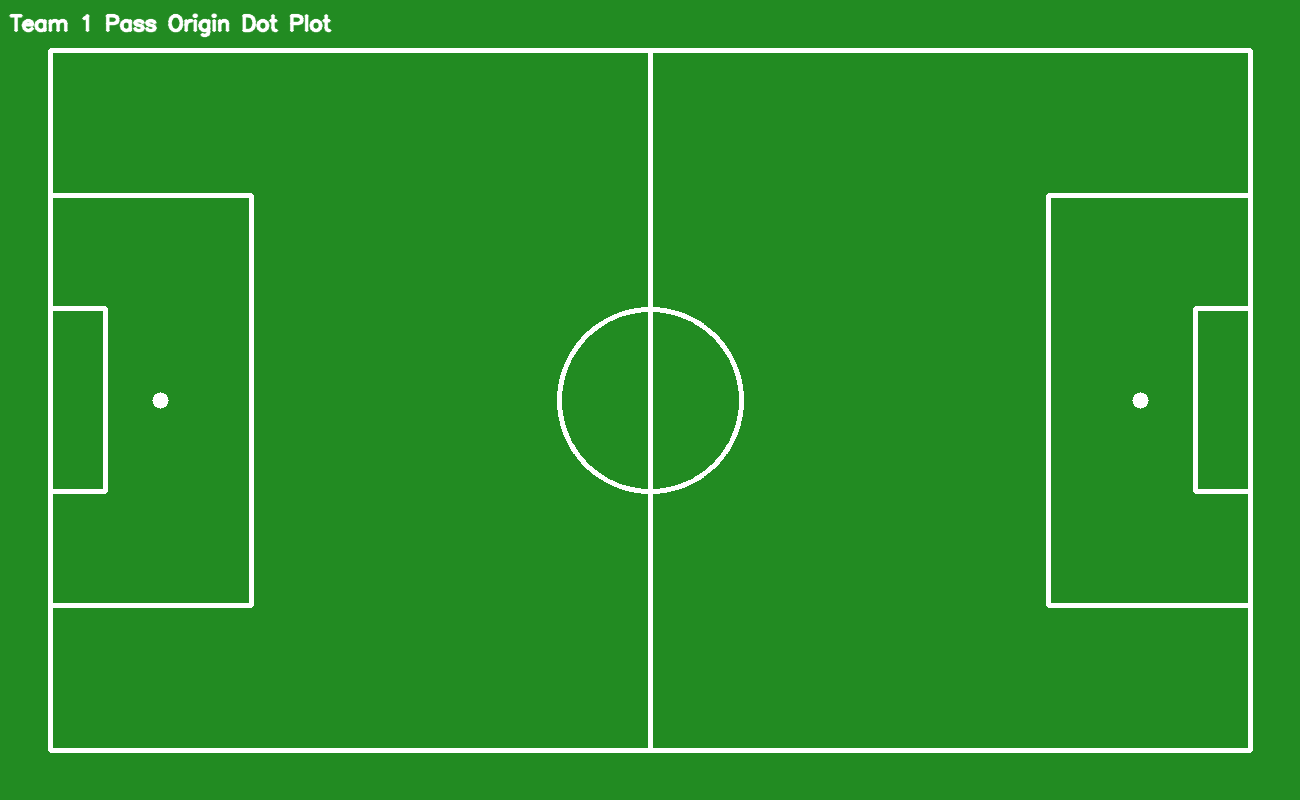

✅ Team 2 Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team1.png


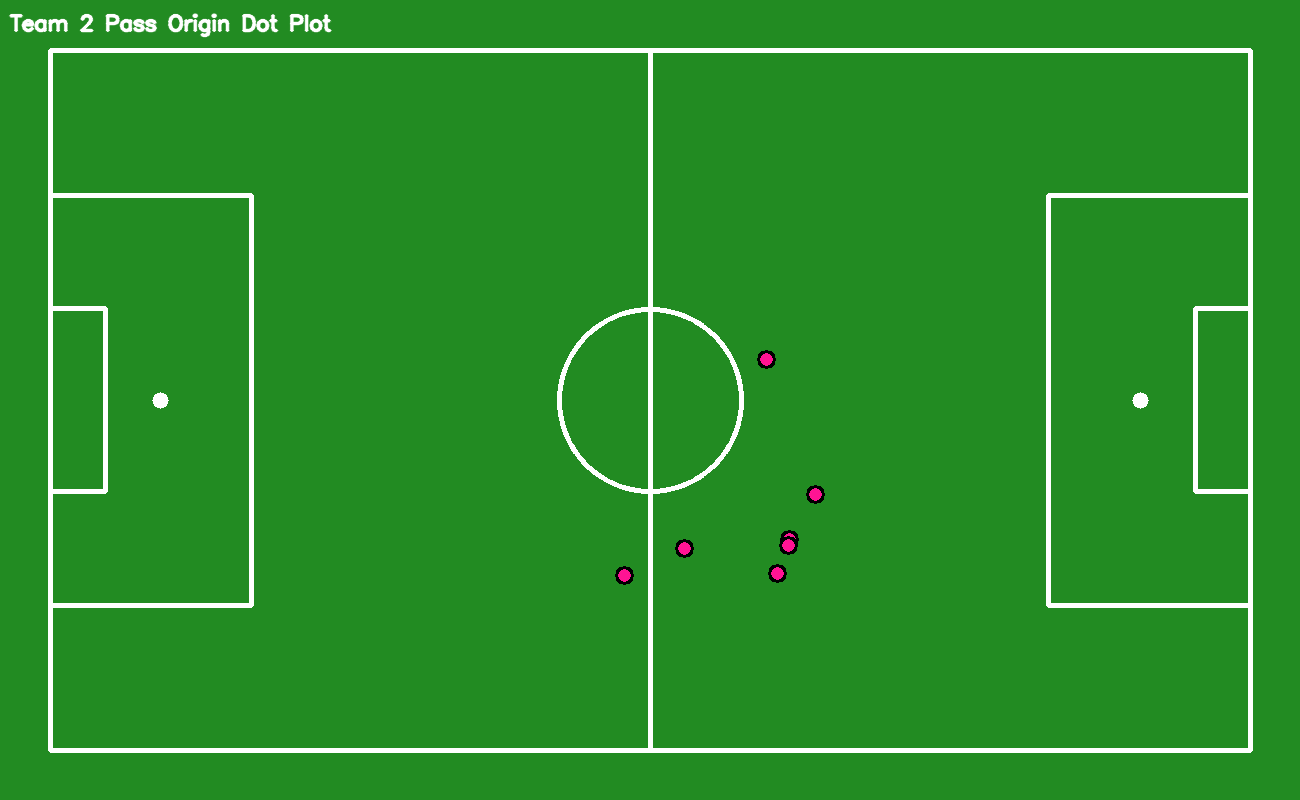


--- Generating Heatmaps ---
No pass data to generate heatmap for Team 1.
✅ Team 2 Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team1.png


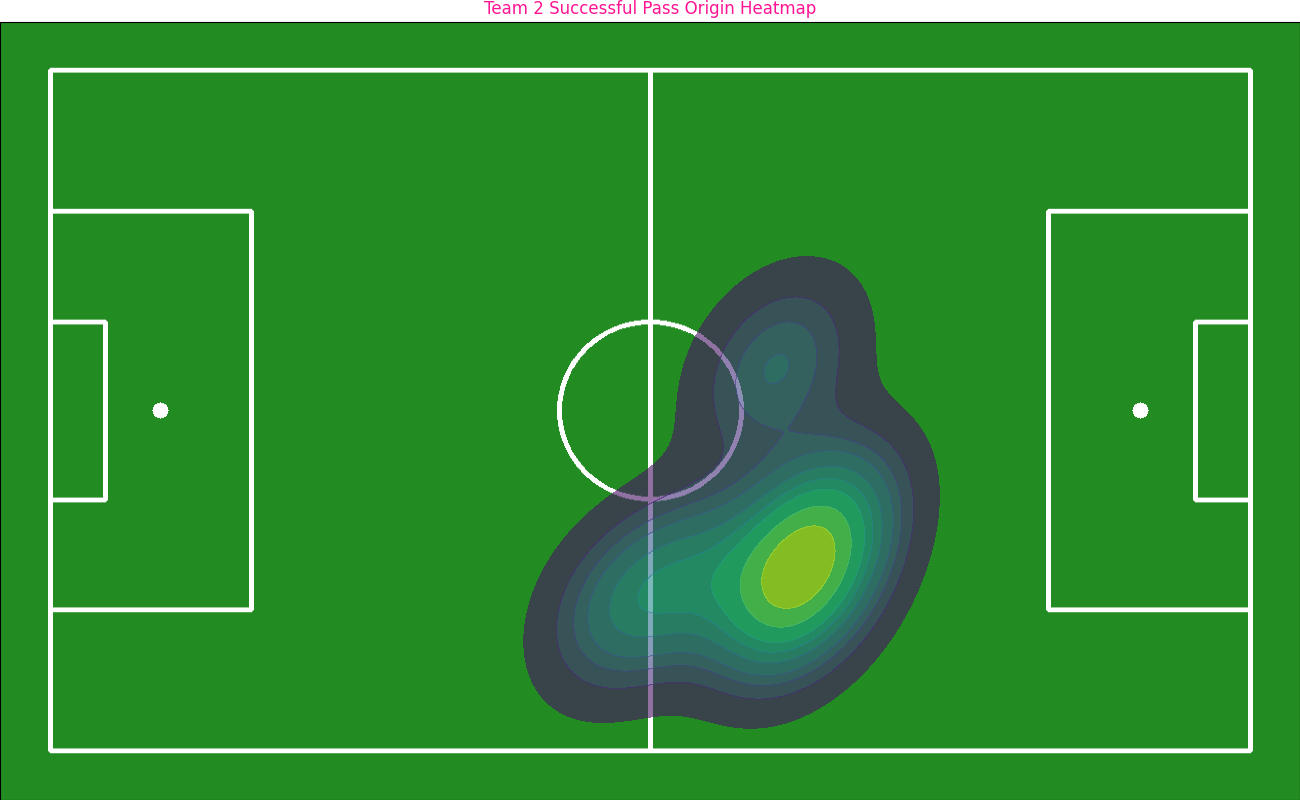

In [12]:
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model
import threading

# Import for heatmap generation
import matplotlib.pyplot as plt
import seaborn as sns

# Import for displaying images in Jupyter Notebook
from IPython.display import Image, display

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees
POSSESSION_DISTANCE_THRESHOLD = 300  # Pixels, tune this based on your output radar size

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # OpenCV hue [0-180] -> [0-360]
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # hue to degrees
    h /= 360
    s /= 255
    v /= 255
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )
    mask = ~green_mask

    if not np.any(mask):
        return None

    # Gaussian center weight
    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === PATHS AND MODELS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4" # Changed output name
DOTPLOT_OUTPUT_PATH_TEAM0 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team0.png" # Dot plot for Team 0
DOTPLOT_OUTPUT_PATH_TEAM1 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team1.png" # Dot plot for Team 1
HEATMAP_OUTPUT_PATH_TEAM0 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team0.png" # Heatmap for Team 0
HEATMAP_OUTPUT_PATH_TEAM1 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team1.png" # Heatmap for Team 1
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ"
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}
RADAR_WIDTH, RADAR_HEIGHT = None, None  # To store radar dimensions
BASE_PITCH_IMAGE = None  # To store base pitch image

# Possession tracking variables
current_possessor_id = None
current_possessor_team = None
successful_passes = defaultdict(int) # Tracks successful passes per team
unsuccessful_passes = defaultdict(int) # Tracks unsuccessful passes (where possession changes to opponent)
possession_event_log = [] # Optional: log possession changes

# Lists to store successful pass initial positions for dot plot and heatmap, separated by team
successful_pass_start_positions_team0 = []  # In pitch coordinates (meters)
successful_pass_start_positions_team1 = []  # In pitch coordinates (meters)
successful_pass_start_pixels_team0 = []     # In radar pixel coordinates
successful_pass_start_pixels_team1 = []     # In radar pixel coordinates

# === TRAINING LOOP ===
for frame in frame_generator:
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        # Get base pitch image and dimensions
        BASE_PITCH_IMAGE = draw_pitch(CONFIG)
        RADAR_HEIGHT, RADAR_WIDTH = BASE_PITCH_IMAGE.shape[:2]

        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break

# === KMEANS TRAINING ===
color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto").fit(color_array)
thread_preds = [None] * len(crops)

def classify_crop(i, crop):
    color = center_weighted_color(crop, h_low, h_high)
    thread_preds[i] = kmeans.predict([color])[0] if color is not None else 0

threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    label_map[tid].append(label)
track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items()}

# === GOALKEEPER TEAM ASSIGNMENT ===
positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}
team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])
centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}
for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None:
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
        goalkeeper_id_to_team[gid] = min(dists, key=dists.get)

# === OUTPUT INIT ===
dummy = draw_pitch(CONFIG)
h, w = dummy.shape[:2]
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (w, h))
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# === MAIN LOOP ===
for frame_idx, frame in tqdm(enumerate(frame_generator), desc="Processing frames"):
    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    # === LIVE CLASSIFICATION ===
    live_colors = [None] * len(pls.xyxy)

    def extract_color(i, box):
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        live_colors[i] = color if color is not None else (0, 0, 0) # Default to black if no color is found

    threads = [threading.Thread(target=extract_color, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    valid_live_colors = [lc for lc in live_colors if lc is not None]
    valid_player_indices = [i for i, lc in enumerate(live_colors) if lc is not None]

    if valid_live_colors:
        predicted_classes = kmeans.predict(np.array(valid_live_colors, dtype=np.float64))
        new_player_class_ids = np.zeros(len(pls.class_id), dtype=int)
        for i, pred_class in zip(valid_player_indices, predicted_classes):
            new_player_class_ids[i] = pred_class
        pls.class_id = new_player_class_ids
    else:
        pls.class_id = np.zeros(len(pls.class_id), dtype=int)


    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    gks.class_id = np.array([goalkeeper_id_to_team.get(tid, 0) for tid in gks.tracker_id])
    players = sv.Detections.merge([pls[~gk_mask], gks])
    refs.class_id -= 1  # 2 → 1 (for visualization)

    ball_xy_original = ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ball_xy = static_transformer.transform_points(ball_xy_original)
    ply_xy_original = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ply_xy = static_transformer.transform_points(ply_xy_original)
    ref_xy = static_transformer.transform_points(refs.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    # === POSSESSION TRACKING LOGIC ===
    if len(ball_xy) > 0:
        ball_center = ball_xy[0]
        closest_player_id = None
        min_dist = float('inf')

        # Find the closest player to the ball on the radar view
        for i, player_pos in enumerate(ply_xy):
            dist = np.linalg.norm(player_pos - ball_center)
            if dist < min_dist:
                min_dist = dist
                closest_player_id = players.tracker_id[i]


        if closest_player_id is not None and min_dist < POSSESSION_DISTANCE_THRESHOLD:
            closest_player_team = track_id_to_team.get(closest_player_id)
            if closest_player_team is None:
                # Fallback if tracker_id is not yet in track_id_to_team (e.g., new player appeared)
                # Try to get it from current players detections' class_id
                player_idx = np.where(players.tracker_id == closest_player_id)[0]
                if len(player_idx) > 0:
                    closest_player_team = players.class_id[player_idx[0]]
                else:
                    closest_player_team = 0 # Default to team 0 if no info

            if current_possessor_id is None: # First possession
                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team
                possession_event_log.append((frame_idx, 'START_POSSESSION', current_possessor_id, current_possessor_team))
            elif closest_player_id != current_possessor_id: # Possessor changed
                # This change of possessor can be either a successful pass or an unsuccessful one
                # We attribute the pass attempt to the *previous* possessor's team.
                if current_possessor_team is not None: # Ensure there was a previous possessor
                    if closest_player_team == current_possessor_team: # Successful Pass
                        successful_passes[current_possessor_team] += 1
                        possession_event_log.append((frame_idx, 'PASS_SUCCESS', current_possessor_id, current_possessor_team, closest_player_id))
                        # Store the player's position at the moment of a successful pass
                        player_idx_prev_possessor = np.where(players.tracker_id == current_possessor_id)[0]
                        if len(player_idx_prev_possessor) > 0:
                            pos_meter = ply_xy[player_idx_prev_possessor[0]]
                            
                            # Clip to pitch boundaries
                            x_meter = np.clip(pos_meter[0], 0, CONFIG.length)
                            y_meter = np.clip(pos_meter[1], 0, CONFIG.width)
                            
                            # Convert to pixel coordinates for heatmap
                            x_pixel = (x_meter / CONFIG.length) * RADAR_WIDTH
                            y_pixel = RADAR_HEIGHT - (y_meter / CONFIG.width) * RADAR_HEIGHT  # Flip y-axis
                            
                            if current_possessor_team == 0:
                                successful_pass_start_positions_team0.append([x_meter, y_meter])
                                successful_pass_start_pixels_team0.append([x_pixel, y_pixel])
                            else:
                                successful_pass_start_positions_team1.append([x_meter, y_meter])
                                successful_pass_start_pixels_team1.append([x_pixel, y_pixel])

                    else: # Unsuccessful Pass (possession changed to opponent)
                        unsuccessful_passes[current_possessor_team] += 1 # The team that *attempted* the pass unsuccessfully
                        possession_event_log.append((frame_idx, 'PASS_UNSUCCESS', current_possessor_id, current_possessor_team, closest_player_id, closest_player_team))

                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team

    radar = draw_pitch(CONFIG)
    radar = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex("00BFFF"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex("FF1493"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex("FFD700"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)

    # Display possession info on radar (optional)
    team_color_0_bgr = sv.Color.from_hex("00BFFF").as_bgr()
    team_color_1_bgr = sv.Color.from_hex("FF1493").as_bgr()

    if current_possessor_team is not None:
        team_name = f"Team {current_possessor_team + 1}"
        display_color = team_color_0_bgr if current_possessor_team == 0 else team_color_1_bgr
        cv2.putText(radar, f"Possession: {team_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    # Display pass counts and accuracy
    for team_id in range(2):
        team_name = f"Team {team_id + 1}"

        # Calculate total pass attempts for accuracy calculation
        total_pass_attempts = successful_passes[team_id] + unsuccessful_passes[team_id]

        pass_accuracy_text = "Acc: N/A"
        if total_pass_attempts > 0:
            accuracy_percentage = (successful_passes[team_id] / total_pass_attempts) * 100
            pass_accuracy_text = f"Acc: {accuracy_percentage:.1f}%"

        display_color = team_color_0_bgr if team_id == 0 else team_color_1_bgr

        # Display successful passes
        cv2.putText(radar, f"{team_name} Passes: {successful_passes[team_id]}", (10, 60 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

        # Display accuracy below passes
        cv2.putText(radar, f"{pass_accuracy_text}", (10, 90 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)


    if radar.shape[2] == 4:
        radar = cv2.cvtColor(radar, cv2.COLOR_RGBA2BGR)

    out.write(radar)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()
print("✅ Radar video saved to:", OUTPUT_PATH)
print("\n=== Possession Event Log ===")
for event in possession_event_log:
    print(event)

# Final summary of pass statistics
print(f"\n--- Final Pass Statistics ---")
for team_id in range(2):
    team_name = f"Team {team_id + 1}"

    total_pass_attempts = successful_passes[team_id] + unsuccessful_passes[team_id]

    print(f"\n{team_name}:")
    print(f"  Successful Passes: {successful_passes[team_id]}")
    print(f"  Unsuccessful Passes (led to opponent possession): {unsuccessful_passes[team_id]}")
    print(f"  Total Pass Attempts (Successful + Unsuccessful): {total_pass_attempts}")

    if total_pass_attempts > 0:
        accuracy = (successful_passes[team_id] / total_pass_attempts) * 100
        print(f"  Pass Accuracy: {accuracy:.1f}%")
    else:
        print(f"  Pass Accuracy: N/A (No pass attempts recorded)")

# === DOT PLOT GENERATION FOR EACH TEAM ===

# Function to generate and display dot plot
def generate_and_display_dot_plot(pass_positions, output_path, team_name, dot_color_sv):
    pitch_for_dotplot = draw_pitch(CONFIG)
    if pitch_for_dotplot.shape[2] == 4:
        pitch_for_dotplot = cv2.cvtColor(pitch_for_dotplot, cv2.COLOR_RGBA2BGR)

    if pass_positions:
        # Draw each pass initiation point as a dot
        pitch_for_dotplot = draw_points_on_pitch(
            CONFIG,
            xy=np.array(pass_positions),
            face_color=dot_color_sv,
            edge_color=sv.Color.BLACK,
            radius=8, # Adjust radius as needed for visibility
            pitch=pitch_for_dotplot
        )

    # Add text for team name
    cv2.putText(pitch_for_dotplot, f"{team_name} Pass Origin Dot Plot", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imwrite(output_path, pitch_for_dotplot)
    print(f"✅ {team_name} Pass origin dot plot saved to: {output_path}")
    # Display the image in Jupyter Notebook
    display(Image(filename=output_path))


# === HEATMAP GENERATION FOR EACH TEAM ===
def generate_and_save_heatmap(pass_pixel_positions, output_path, team_name, title_color_rgb, base_pitch_image):
    if not pass_pixel_positions:
        print(f"No pass data to generate heatmap for {team_name}.")
        return

    pass_pixel_positions = np.array(pass_pixel_positions)
    w = base_pitch_image.shape[1]
    h = base_pitch_image.shape[0]

    fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)

    # Show the base pitch image in the background
    base_pitch_image_rgb = cv2.cvtColor(base_pitch_image, cv2.COLOR_BGR2RGB)
    ax.imshow(base_pitch_image_rgb, extent=[0, w, 0, h], origin='lower', aspect='auto', zorder=-1) # Changed origin to 'lower'

    # Set limits for plot. Now y-axis 0 is at the bottom, h at the top
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Create KDE plot
    sns.kdeplot(
        x=pass_pixel_positions[:,0],
        y=pass_pixel_positions[:,1],
        fill=True,
        cmap='viridis',
        alpha=0.6,
        levels=10,
        ax=ax,
        zorder=0
    )

    # Set title
    ax.set_title(f"{team_name} Successful Pass Origin Heatmap", color=title_color_rgb)

    plt.tight_layout(pad=0)
    fig.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"✅ {team_name} Pass origin heatmap saved to: {output_path}")
    # Display the image in Jupyter Notebook
    display(Image(filename=output_path))


# Define colors for the dot plots and heatmaps
team0_color_sv = sv.Color.from_hex("00BFFF") # Light blue for Team 1 (Supervision Color)
team1_color_sv = sv.Color.from_hex("FF1493") # Pink for Team 2 (Supervision Color)

# For Matplotlib titles, use RGB tuple (0-1 range)
team0_title_color_rgb = (0/255, 191/255, 255/255) # RGB for light blue
team1_title_color_rgb = (255/255, 20/255, 147/255) # RGB for pink


# === GENERATE DOT PLOTS ===
print("\n--- Generating Dot Plots ---")
generate_and_display_dot_plot(successful_pass_start_positions_team0, DOTPLOT_OUTPUT_PATH_TEAM0, "Team 1", team0_color_sv)
generate_and_display_dot_plot(successful_pass_start_positions_team1, DOTPLOT_OUTPUT_PATH_TEAM1, "Team 2", team1_color_sv)

# === GENERATE HEATMAPS ===
print("\n--- Generating Heatmaps ---")
generate_and_save_heatmap(
    successful_pass_start_pixels_team0,
    HEATMAP_OUTPUT_PATH_TEAM0,
    "Team 1",
    team0_title_color_rgb, # Pass RGB color for title
    BASE_PITCH_IMAGE
)

generate_and_save_heatmap(
    successful_pass_start_pixels_team1,
    HEATMAP_OUTPUT_PATH_TEAM1,
    "Team 2",
    team1_title_color_rgb, # Pass RGB color for title
    BASE_PITCH_IMAGE
)

combine them all

--- Training Player Classifier ---
--- Training KMeans Classifier ---
--- Processing Video Frames ---


Processing frames: 100%|██████████| 750/750 [01:42<00:00,  7.30it/s]


✅ Radar video saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4

--- Generating Pass Visualizations ---
✅ Team 1 Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team0.png


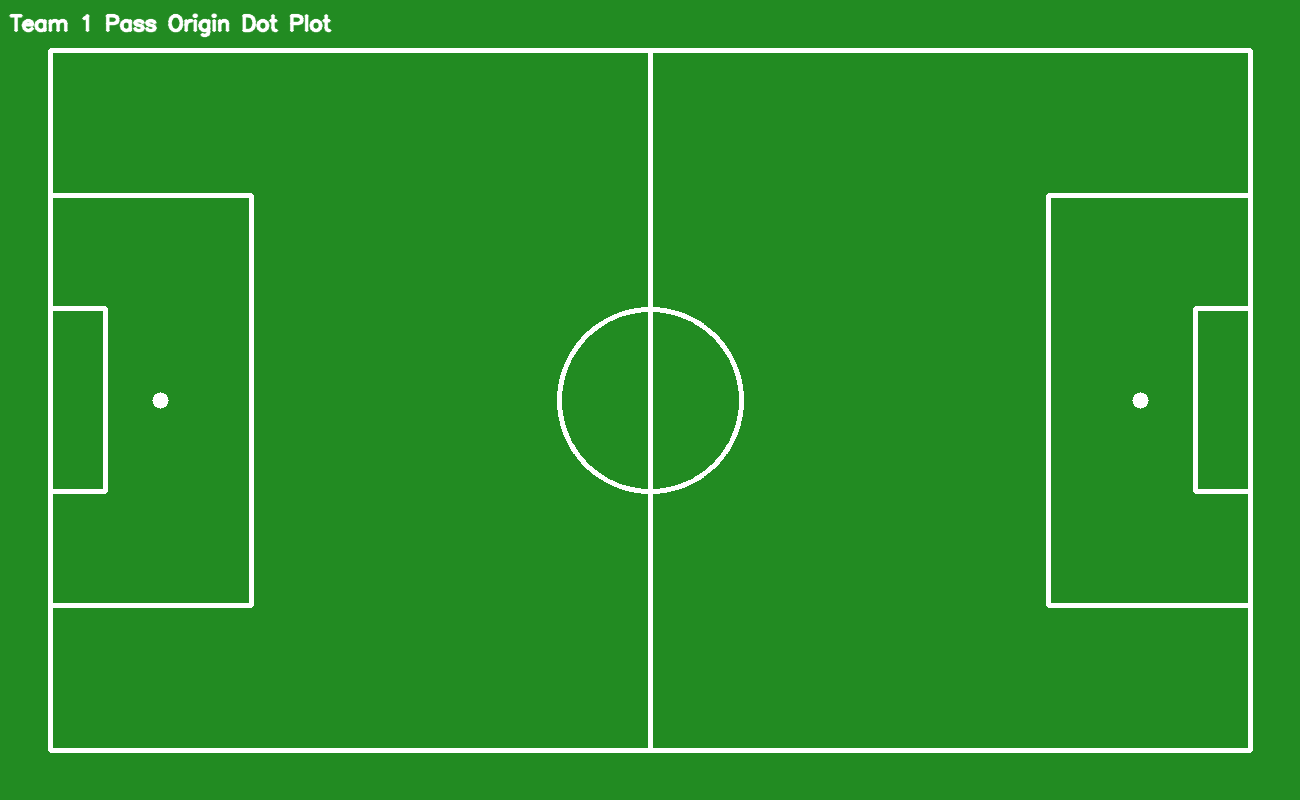

✅ Team 2 Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team1.png


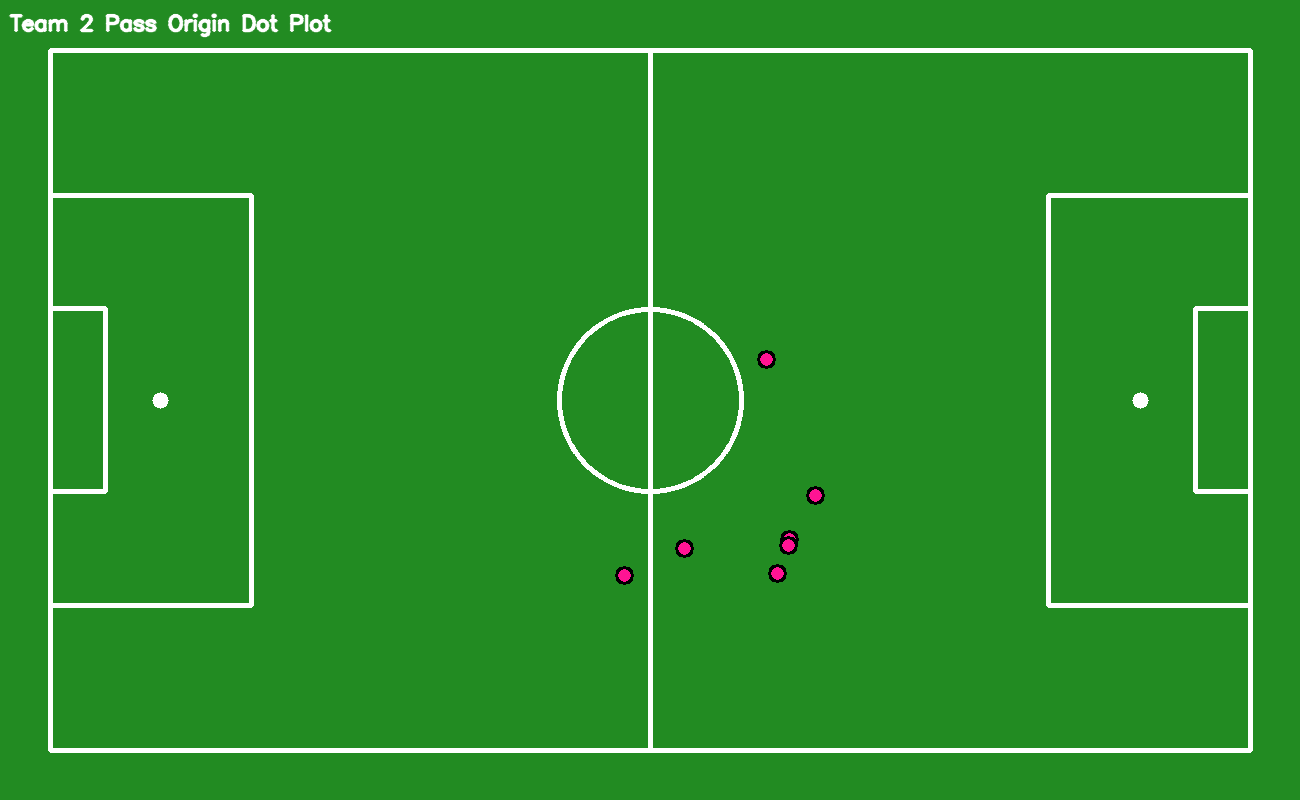

No pass data for Team 1 heatmap
✅ Team 2 Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team1.png


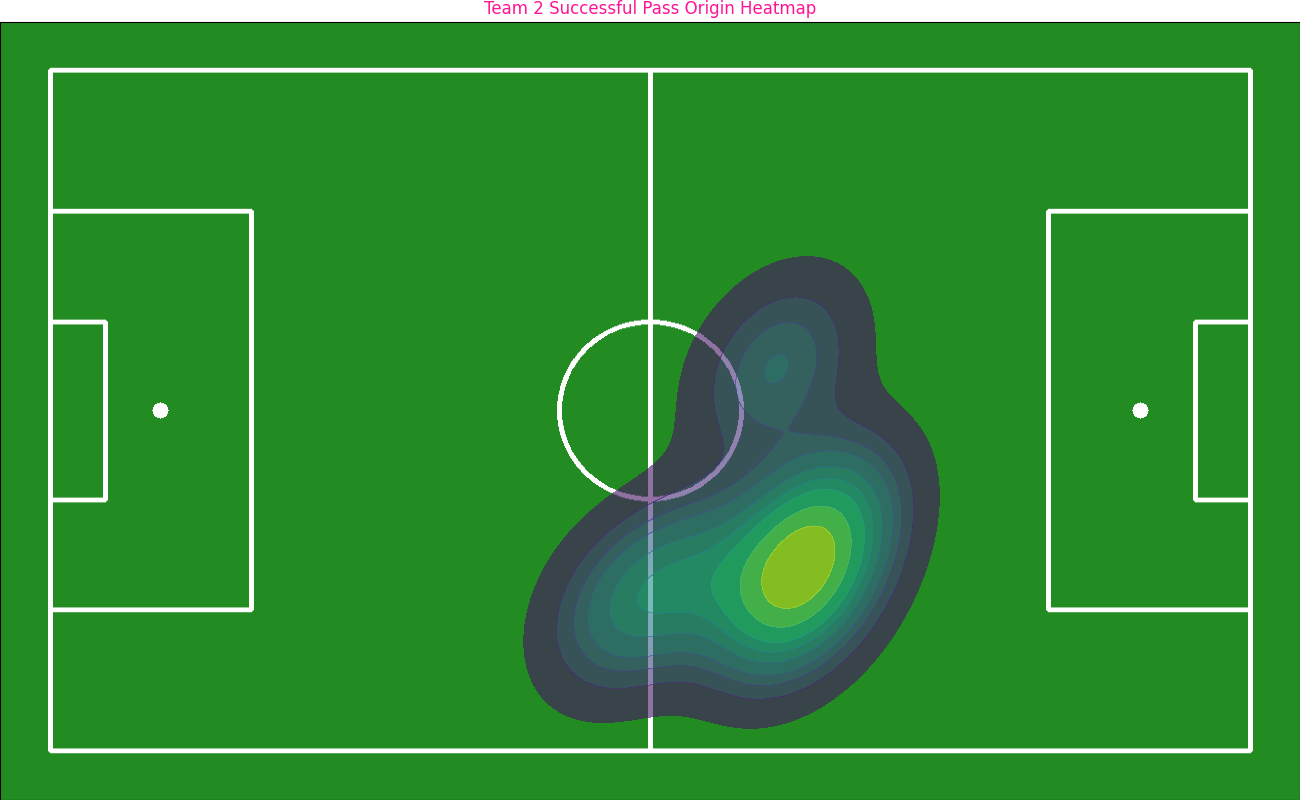


--- Generating Voronoi Heatmap ---
✅ Voronoi heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/voronoi_heatmap.png


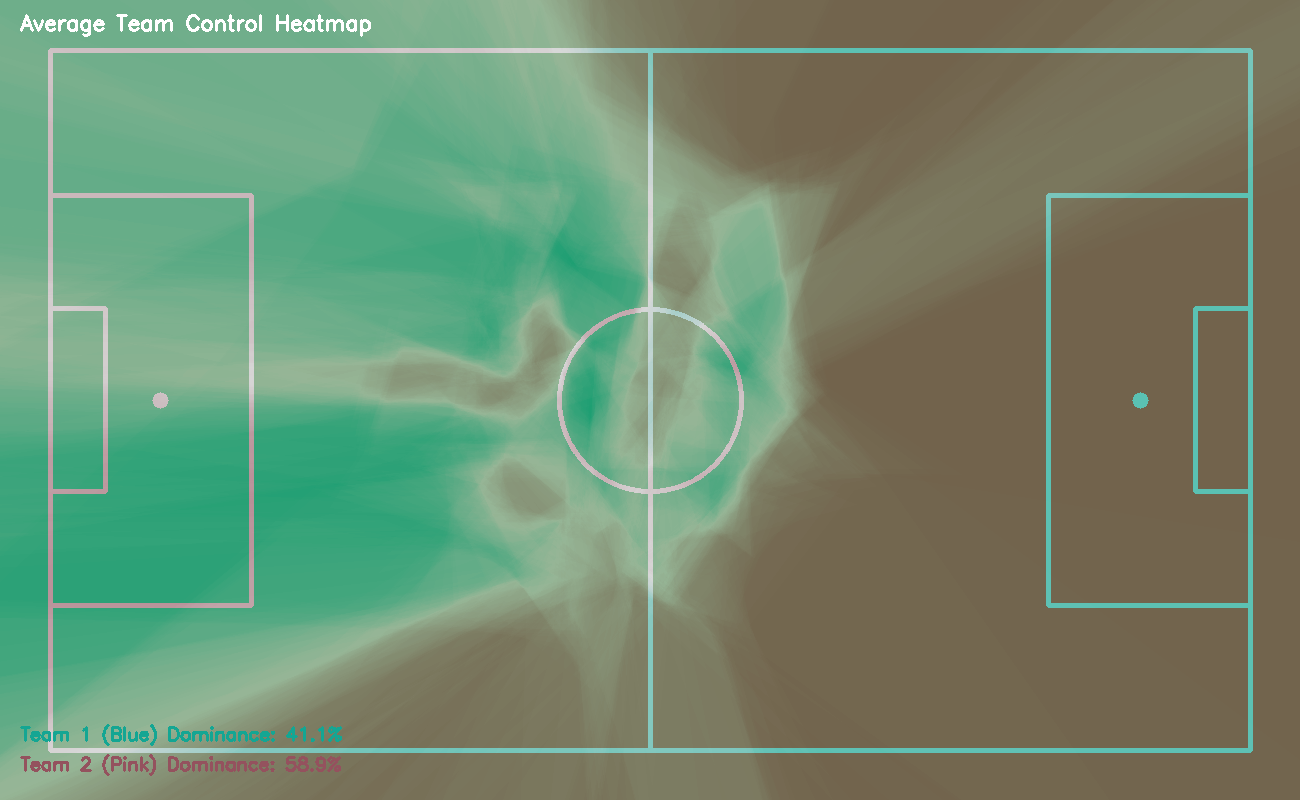


Voronoi Control Statistics (Based on 125 frames):
Team 1 Dominance: 41.1%
Team 2 Dominance: 58.9%
Neutral Areas: 0.0%

=== Final Statistics ===
Total frames with Voronoi: 125
Team 0 dominant pixels: 427045
Team 1 dominant pixels: 612955
Neutral pixels: 0

Team 1:
  Successful Passes: 0
  Unsuccessful Passes: 1
  Total Pass Attempts: 1
  Pass Accuracy: 0.0%

Team 2:
  Successful Passes: 9
  Unsuccessful Passes: 0
  Total Pass Attempts: 9
  Pass Accuracy: 100.0%


In [ ]:
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import (
    draw_pitch, 
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram  # Added for Voronoi
)
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model
import threading
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees
POSSESSION_DISTANCE_THRESHOLD = 300  # Pixels
OUTLIER_DISTANCE_THRESHOLD = 0.2    # For color outlier detection
UNCLASSIFIED_CLASS_ID = 99          # ID for players with outlier colors
COLOR_TOLERANCE = 30                # For Voronoi pixel analysis
VORONOI_CALC_SKIP_FRAMES = 5        # Calculate Voronoi every 6th frame
REF_TEAM_0_BGR = np.array([255, 191, 0], dtype=np.uint8)   # Blue reference
REF_TEAM_1_BGR = np.array([147, 20, 255], dtype=np.uint8)  # Pink reference
NEUTRAL_COLOR_BGR = np.array([200, 200, 200], dtype=np.uint8)  # Light gray

# === PATHS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4"
DOTPLOT_OUTPUT_PATH_TEAM0 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team0.png"
DOTPLOT_OUTPUT_PATH_TEAM1 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team1.png"
HEATMAP_OUTPUT_PATH_TEAM0 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team0.png"
HEATMAP_OUTPUT_PATH_TEAM1 = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team1.png"
VORONOI_HEATMAP_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/voronoi_heatmap.png"  # Added Voronoi output
PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ"

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2
    h /= 360
    s /= 255
    v /= 255
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )
    mask = ~green_mask

    if not np.any(mask):
        return None

    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === LOAD MODELS ===
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}
RADAR_WIDTH, RADAR_HEIGHT = None, None
BASE_PITCH_IMAGE = None

# Possession tracking
current_possessor_id = None
current_possessor_team = None
successful_passes = defaultdict(int)
unsuccessful_passes = defaultdict(int)
possession_event_log = []
successful_pass_start_positions_team0 = []
successful_pass_start_positions_team1 = []
successful_pass_start_pixels_team0 = []
successful_pass_start_pixels_team1 = []

# Voronoi state
team_0_control_sum = None
team_1_control_sum = None
voronoi_frame_count = 0
found_team_colors = False
dynamic_team0_bgr = None
dynamic_team1_bgr = None

# === TRAINING LOOP ===
print("--- Training Player Classifier ---")
for frame in frame_generator:
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        BASE_PITCH_IMAGE = draw_pitch(CONFIG)
        RADAR_HEIGHT, RADAR_WIDTH = BASE_PITCH_IMAGE.shape[:2]
        
        # Initialize Voronoi accumulation grids
        team_0_control_sum = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_1_control_sum = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)

        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break

# === KMEANS TRAINING ===
print("--- Training KMeans Classifier ---")
color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto").fit(color_array)
thread_preds = [None] * len(crops)

def classify_crop(i, crop):
    color = center_weighted_color(crop, h_low, h_high)
    thread_preds[i] = kmeans.predict([color])[0] if color is not None else 0

threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    label_map[tid].append(label)
track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items()}

# === GOALKEEPER TEAM ASSIGNMENT ===
positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}
team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])
centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}
for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None:
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
        goalkeeper_id_to_team[gid] = min(dists, key=dists.get)

# === OUTPUT INIT ===
dummy = draw_pitch(CONFIG)
h, w = dummy.shape[:2]
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (w, h))
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
total_frames = int(cv2.VideoCapture(SOURCE_VIDEO_PATH).get(cv2.CAP_PROP_FRAME_COUNT))

# === MAIN PROCESSING LOOP ===
print("--- Processing Video Frames ---")
for frame_idx, frame in tqdm(enumerate(frame_generator), total=total_frames, desc="Processing frames"):
    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    # === LIVE CLASSIFICATION ===
    live_colors = [None] * len(pls.xyxy)

    def extract_color(i, box):
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        live_colors[i] = color if color is not None else (0, 0, 0)

    threads = [threading.Thread(target=extract_color, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    valid_live_colors = [lc for lc in live_colors if lc is not None]
    valid_player_indices = [i for i, lc in enumerate(live_colors) if lc is not None]

    if valid_live_colors:
        predicted_classes = kmeans.predict(np.array(valid_live_colors, dtype=np.float64))
        new_player_class_ids = np.zeros(len(pls.class_id), dtype=int)
        for i, pred_class in zip(valid_player_indices, predicted_classes):
            new_player_class_ids[i] = pred_class
        pls.class_id = new_player_class_ids
    else:
        pls.class_id = np.zeros(len(pls.class_id), dtype=int)

    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    gks.class_id = np.array([goalkeeper_id_to_team.get(tid, 0) for tid in gks.tracker_id])
    players = sv.Detections.merge([pls[~gk_mask], gks])
    refs.class_id -= 1

    ball_xy_original = ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ball_xy = static_transformer.transform_points(ball_xy_original)
    ply_xy_original = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ply_xy = static_transformer.transform_points(ply_xy_original)
    ref_xy = static_transformer.transform_points(refs.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    # === POSSESSION TRACKING ===
    if len(ball_xy) > 0:
        ball_center = ball_xy[0]
        closest_player_id = None
        min_dist = float('inf')

        for i, player_pos in enumerate(ply_xy):
            dist = np.linalg.norm(player_pos - ball_center)
            if dist < min_dist:
                min_dist = dist
                closest_player_id = players.tracker_id[i]

        if closest_player_id is not None and min_dist < POSSESSION_DISTANCE_THRESHOLD:
            closest_player_team = track_id_to_team.get(closest_player_id)
            if closest_player_team is None:
                player_idx = np.where(players.tracker_id == closest_player_id)[0]
                if len(player_idx) > 0:
                    closest_player_team = players.class_id[player_idx[0]]
                else:
                    closest_player_team = 0

            if current_possessor_id is None:
                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team
                possession_event_log.append((frame_idx, 'START_POSSESSION', current_possessor_id, current_possessor_team))
            elif closest_player_id != current_possessor_id:
                if current_possessor_team is not None:
                    if closest_player_team == current_possessor_team:
                        successful_passes[current_possessor_team] += 1
                        possession_event_log.append((frame_idx, 'PASS_SUCCESS', current_possessor_id, current_possessor_team, closest_player_id))
                        player_idx_prev_possessor = np.where(players.tracker_id == current_possessor_id)[0]
                        if len(player_idx_prev_possessor) > 0:
                            pos_meter = ply_xy[player_idx_prev_possessor[0]]
                            x_meter = np.clip(pos_meter[0], 0, CONFIG.length)
                            y_meter = np.clip(pos_meter[1], 0, CONFIG.width)
                            x_pixel = (x_meter / CONFIG.length) * RADAR_WIDTH
                            y_pixel = RADAR_HEIGHT - (y_meter / CONFIG.width) * RADAR_HEIGHT
                            
                            if current_possessor_team == 0:
                                successful_pass_start_positions_team0.append([x_meter, y_meter])
                                successful_pass_start_pixels_team0.append([x_pixel, y_pixel])
                            else:
                                successful_pass_start_positions_team1.append([x_meter, y_meter])
                                successful_pass_start_pixels_team1.append([x_pixel, y_pixel])
                    else:
                        unsuccessful_passes[current_possessor_team] += 1
                        possession_event_log.append((frame_idx, 'PASS_UNSUCCESS', current_possessor_id, current_possessor_team, closest_player_id, closest_player_team))

                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team

    # === VORONOI DIAGRAM ACCUMULATION ===
    if (frame_idx % (VORONOI_CALC_SKIP_FRAMES + 1) == 0):
        team_0_players = ply_xy[players.class_id == 0]
        team_1_players = ply_xy[players.class_id == 1]

        if len(team_0_players) > 0 and len(team_1_players) > 0:
            voronoi_img = BASE_PITCH_IMAGE.copy()
            voronoi_img = draw_pitch_voronoi_diagram(
                config=CONFIG,
                team_1_xy=team_0_players,
                team_2_xy=team_1_players,
                team_1_color=sv.Color.from_hex('00BFFF'),
                team_2_color=sv.Color.from_hex('FF1493'),
                pitch=voronoi_img
            )

            if voronoi_img.shape[2] == 4:
                voronoi_bgr = cv2.cvtColor(voronoi_img, cv2.COLOR_RGBA2BGR)
            else:
                voronoi_bgr = voronoi_img.copy()

            # Dynamic team color discovery (first frame only)
            if not found_team_colors:
                pixels = voronoi_bgr.reshape(-1, 3)
                not_black_mask = np.linalg.norm(pixels - [0,0,0], axis=1) > 20 
                not_white_mask = np.linalg.norm(pixels - [255,255,255], axis=1) > 20 
                filtered_pixels = pixels[not_black_mask & not_white_mask]

                if len(filtered_pixels) >= 2:
                    kmeans_colors = KMeans(n_clusters=2, n_init="auto", random_state=42).fit(filtered_pixels.astype(np.float32))
                    dist_to_ref0_cluster0 = np.linalg.norm(kmeans_colors.cluster_centers_[0] - REF_TEAM_0_BGR)
                    dist_to_ref0_cluster1 = np.linalg.norm(kmeans_colors.cluster_centers_[1] - REF_TEAM_0_BGR)

                    if dist_to_ref0_cluster0 < dist_to_ref0_cluster1:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                    else:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)
                    
                    found_team_colors = True

            # Accumulate control if colors are discovered
            if found_team_colors:
                pixels = voronoi_bgr.reshape(-1, 3)
                dist_to_team0_sq = np.sum((pixels - dynamic_team0_bgr)**2, axis=1)
                dist_to_team1_sq = np.sum((pixels - dynamic_team1_bgr)**2, axis=1)
                
                mask_team0_control = (dist_to_team0_sq < (COLOR_TOLERANCE**2)) & (dist_to_team0_sq < dist_to_team1_sq)
                mask_team1_control = (dist_to_team1_sq < (COLOR_TOLERANCE**2)) & (dist_to_team1_sq < dist_to_team0_sq)

                mask_team0_control = mask_team0_control.reshape(RADAR_HEIGHT, RADAR_WIDTH)
                mask_team1_control = mask_team1_control.reshape(RADAR_HEIGHT, RADAR_WIDTH)

                team_0_control_sum[mask_team0_control] += 1
                team_1_control_sum[mask_team1_control] += 1
                voronoi_frame_count += 1

    # === DRAW RADAR OUTPUT ===
    radar = draw_pitch(CONFIG)
    radar = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex("00BFFF"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex("FF1493"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex("FFD700"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)

    team_color_0_bgr = sv.Color.from_hex("00BFFF").as_bgr()
    team_color_1_bgr = sv.Color.from_hex("FF1493").as_bgr()

    if current_possessor_team is not None:
        team_name = f"Team {current_possessor_team + 1}"
        display_color = team_color_0_bgr if current_possessor_team == 0 else team_color_1_bgr
        cv2.putText(radar, f"Possession: {team_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    for team_id in range(2):
        team_name = f"Team {team_id + 1}"
        total_pass_attempts = successful_passes[team_id] + unsuccessful_passes[team_id]
        pass_accuracy_text = "Acc: N/A"
        if total_pass_attempts > 0:
            accuracy_percentage = (successful_passes[team_id] / total_pass_attempts) * 100
            pass_accuracy_text = f"Acc: {accuracy_percentage:.1f}%"

        display_color = team_color_0_bgr if team_id == 0 else team_color_1_bgr
        cv2.putText(radar, f"{team_name} Passes: {successful_passes[team_id]}", (10, 60 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)
        cv2.putText(radar, f"{pass_accuracy_text}", (10, 90 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    if radar.shape[2] == 4:
        radar = cv2.cvtColor(radar, cv2.COLOR_RGBA2BGR)

    out.write(radar)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()
print("✅ Radar video saved to:", OUTPUT_PATH)

# === PASS ANALYSIS OUTPUTS ===
def generate_and_display_dot_plot(pass_positions, output_path, team_name, dot_color_sv):
    pitch_for_dotplot = draw_pitch(CONFIG)
    if pitch_for_dotplot.shape[2] == 4:
        pitch_for_dotplot = cv2.cvtColor(pitch_for_dotplot, cv2.COLOR_RGBA2BGR)

    if pass_positions:
        pitch_for_dotplot = draw_points_on_pitch(
            CONFIG,
            xy=np.array(pass_positions),
            face_color=dot_color_sv,
            edge_color=sv.Color.BLACK,
            radius=8,
            pitch=pitch_for_dotplot
        )

    cv2.putText(pitch_for_dotplot, f"{team_name} Pass Origin Dot Plot", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imwrite(output_path, pitch_for_dotplot)
    print(f"✅ {team_name} Pass origin dot plot saved to: {output_path}")
    display(Image(filename=output_path))

def generate_and_save_heatmap(pass_pixel_positions, output_path, team_name, title_color_rgb, base_pitch_image):
    if not pass_pixel_positions:
        print(f"No pass data for {team_name} heatmap")
        return

    pass_pixel_positions = np.array(pass_pixel_positions)
    w = base_pitch_image.shape[1]
    h = base_pitch_image.shape[0]

    fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
    base_pitch_image_rgb = cv2.cvtColor(base_pitch_image, cv2.COLOR_BGR2RGB)
    ax.imshow(base_pitch_image_rgb, extent=[0, w, 0, h], origin='lower', aspect='auto', zorder=-1)
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.set_xticks([])
    ax.set_yticks([])

    sns.kdeplot(
        x=pass_pixel_positions[:,0],
        y=pass_pixel_positions[:,1],
        fill=True,
        cmap='viridis',
        alpha=0.6,
        levels=10,
        ax=ax,
        zorder=0
    )

    ax.set_title(f"{team_name} Successful Pass Origin Heatmap", color=title_color_rgb)
    plt.tight_layout(pad=0)
    fig.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"✅ {team_name} Pass origin heatmap saved to: {output_path}")
    display(Image(filename=output_path))

# Generate pass visualizations
team0_color_sv = sv.Color.from_hex("00BFFF")
team1_color_sv = sv.Color.from_hex("FF1493")
team0_title_color_rgb = (0/255, 191/255, 255/255)
team1_title_color_rgb = (255/255, 20/255, 147/255)

print("\n--- Generating Pass Visualizations ---")
generate_and_display_dot_plot(successful_pass_start_positions_team0, DOTPLOT_OUTPUT_PATH_TEAM0, "Team 1", team0_color_sv)
generate_and_display_dot_plot(successful_pass_start_positions_team1, DOTPLOT_OUTPUT_PATH_TEAM1, "Team 2", team1_color_sv)
generate_and_save_heatmap(successful_pass_start_pixels_team0, HEATMAP_OUTPUT_PATH_TEAM0, "Team 1", team0_title_color_rgb, BASE_PITCH_IMAGE)
generate_and_save_heatmap(successful_pass_start_pixels_team1, HEATMAP_OUTPUT_PATH_TEAM1, "Team 2", team1_title_color_rgb, BASE_PITCH_IMAGE)

# === VORONOI HEATMAP GENERATION ===
print("\n--- Generating Voronoi Heatmap ---")
if voronoi_frame_count > 0 and found_team_colors:
    # Calculate control ratios
    total_control = team_0_control_sum + team_1_control_sum
    total_control_safe = np.where(total_control == 0, 1, total_control)
    
    team0_ratio = team_0_control_sum / total_control_safe
    team1_ratio = team_1_control_sum / total_control_safe
    
    # Create base image with pitch markings
    heatmap_image = BASE_PITCH_IMAGE.copy()
    if heatmap_image.shape[2] == 4:
        heatmap_image = cv2.cvtColor(heatmap_image, cv2.COLOR_RGBA2BGR)
    
    # Create a blank overlay for the heatmap
    heatmap_overlay = np.zeros_like(heatmap_image, dtype=np.float32)
    
    # Convert colors to float
    team0_color = dynamic_team0_bgr.astype(np.float32) / 255.0
    team1_color = dynamic_team1_bgr.astype(np.float32) / 255.0
    neutral_color = NEUTRAL_COLOR_BGR.astype(np.float32) / 255.0
    
    # Calculate dominance with intensity factor
    INTENSITY_FACTOR = 2.0
    dom_strength_team0 = np.clip((team0_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)
    dom_strength_team1 = np.clip((team1_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)
    
    # Apply colors to overlay
    mask_team0_dominates = team0_ratio > team1_ratio
    heatmap_overlay[mask_team0_dominates] = (
        neutral_color * (1 - dom_strength_team0[mask_team0_dominates, None]) + 
        team0_color * dom_strength_team0[mask_team0_dominates, None]
    )
    
    mask_team1_dominates = team1_ratio > team0_ratio
    heatmap_overlay[mask_team1_dominates] = (
        neutral_color * (1 - dom_strength_team1[mask_team1_dominates, None]) + 
        team1_color * dom_strength_team1[mask_team1_dominates, None]
    )
    
    # Neutral areas
    mask_even_or_no_control = (team0_ratio == team1_ratio) | (total_control == 0)
    heatmap_overlay[mask_even_or_no_control] = neutral_color
    
    # Convert overlay to 8-bit
    heatmap_overlay = (heatmap_overlay * 255).astype(np.uint8)
    
    # Create mask for field lines (black areas in base image)
    line_mask = (BASE_PITCH_IMAGE[:,:,0] < 50) & \
                (BASE_PITCH_IMAGE[:,:,1] < 50) & \
                (BASE_PITCH_IMAGE[:,:,2] < 50)
    
    # Combine heatmap with base image
    # Where there are field lines, use the base image (preserve lines)
    # Elsewhere, blend the heatmap with the base image
    final_image = heatmap_image.copy()
    non_line_mask = ~line_mask
    final_image[non_line_mask] = cv2.addWeighted(
        heatmap_image[non_line_mask], 0.3,
        heatmap_overlay[non_line_mask], 0.7,
        0
    )
    
    # Add text annotations
    cv2.putText(final_image, "Average Team Control Heatmap", 
               (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(final_image, f"Team 1 (Blue) Dominance: {np.sum(mask_team0_dominates)/mask_team0_dominates.size:.1%}", 
               (20, RADAR_HEIGHT-60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, dynamic_team0_bgr.tolist(), 2)
    cv2.putText(final_image, f"Team 2 (Pink) Dominance: {np.sum(mask_team1_dominates)/mask_team1_dominates.size:.1%}", 
               (20, RADAR_HEIGHT-30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, dynamic_team1_bgr.tolist(), 2)
    
    cv2.imwrite(VORONOI_HEATMAP_PATH, final_image)
    print(f"✅ Voronoi heatmap saved to: {VORONOI_HEATMAP_PATH}")
    display(Image(filename=VORONOI_HEATMAP_PATH))
    
    # Print statistics
    print(f"\nVoronoi Control Statistics (Based on {voronoi_frame_count} frames):")
    print(f"Team 1 Dominance: {np.sum(mask_team0_dominates)/mask_team0_dominates.size:.1%}")
    print(f"Team 2 Dominance: {np.sum(mask_team1_dominates)/mask_team1_dominates.size:.1%}")
    print(f"Neutral Areas: {np.sum(mask_even_or_no_control)/mask_even_or_no_control.size:.1%}")
else:
    print("⚠️ Could not generate Voronoi heatmap - insufficient data or team colors not found")

# === FINAL STATS ===
print("\n=== Final Statistics ===")
print(f"Total frames with Voronoi: {voronoi_frame_count}")
print(f"Team 0 dominant pixels: {np.sum(mask_team0_dominates)}")
print(f"Team 1 dominant pixels: {np.sum(mask_team1_dominates)}")
print(f"Neutral pixels: {np.sum(mask_even_or_no_control)}")

for team_id in range(2):
    team_name = f"Team {team_id + 1}"
    total_pass_attempts = successful_passes[team_id] + unsuccessful_passes[team_id]
    print(f"\n{team_name}:")
    print(f"  Successful Passes: {successful_passes[team_id]}")
    print(f"  Unsuccessful Passes: {unsuccessful_passes[team_id]}")
    print(f"  Total Pass Attempts: {total_pass_attempts}")
    if total_pass_attempts > 0:
        accuracy = (successful_passes[team_id] / total_pass_attempts) * 100
        print(f"  Pass Accuracy: {accuracy:.1f}%")
    else:
        print(f"  Pass Accuracy: N/A")

1st half 2nd half

--- Training Player Classifier ---
--- Training KMeans Classifier ---
--- Processing Video Frames ---
Press '1' to pause for Half-time (and generate Half 1 reports).
Press '2' to start 2nd Half (when paused).
Press 'q' to quit.


Processing frames:  27%|██▋       | 205/750 [00:27<01:17,  6.99it/s]

Half-time! Processing paused. Reports will be generated at the end of the match.


Processing frames:  33%|███▎      | 244/750 [00:27<00:10, 48.24it/s]

Starting 2nd Half! Processing resumed.


Processing frames: 100%|██████████| 750/750 [01:31<00:00,  8.21it/s]


✅ Radar video saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4

--- Generating Half 1 Pass Visualizations ---

--- Generating Pass Visualizations for half1 ---
✅ Team 1 (half1) Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team0_half1.png


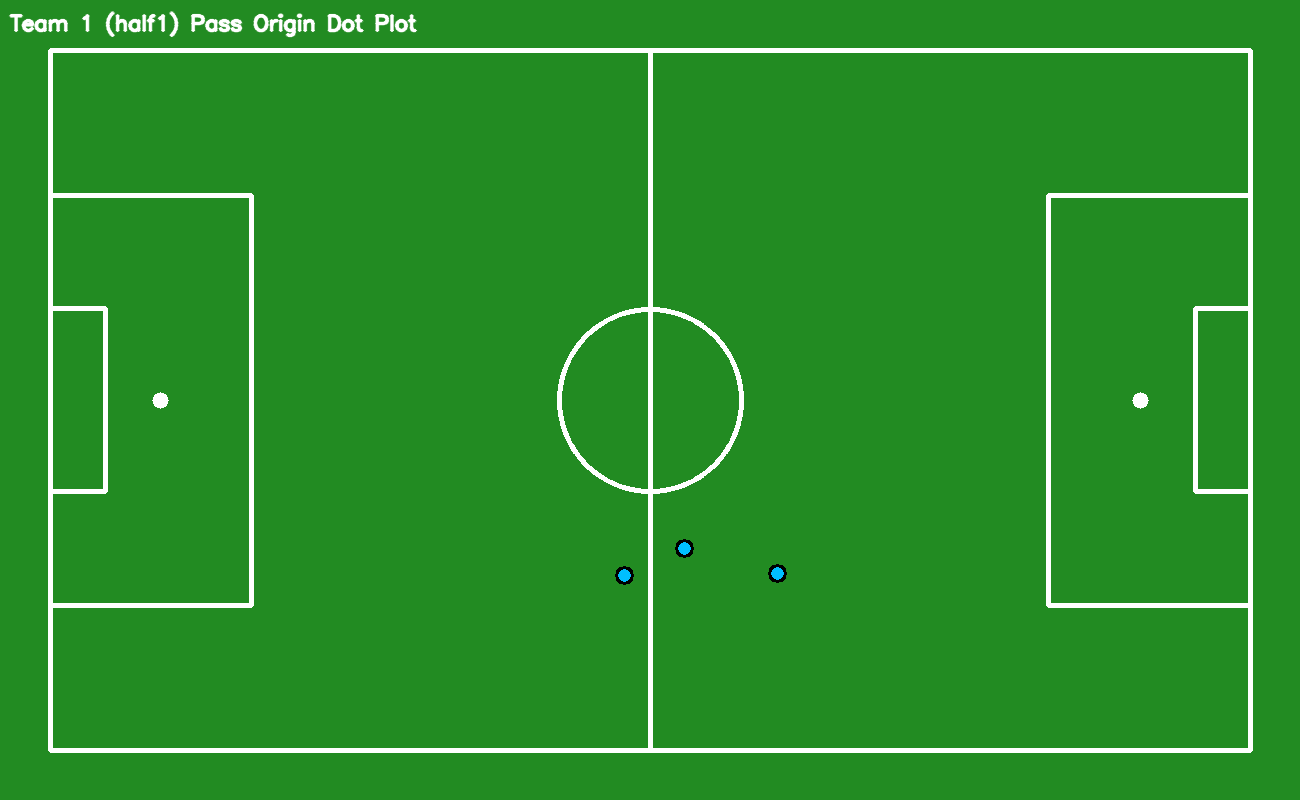

✅ Team 2 (half1) Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team1_half1.png


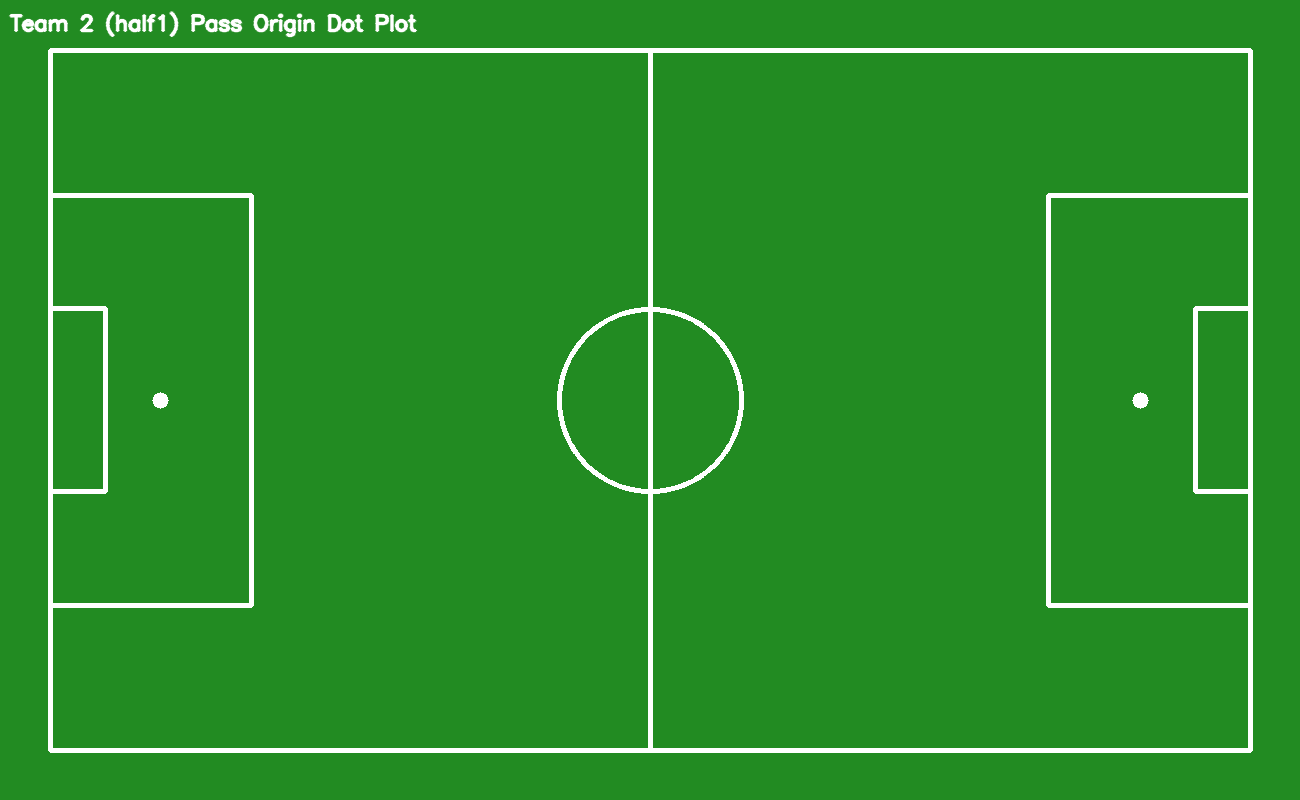

✅ Team 1 (half1) Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team0_half1.png


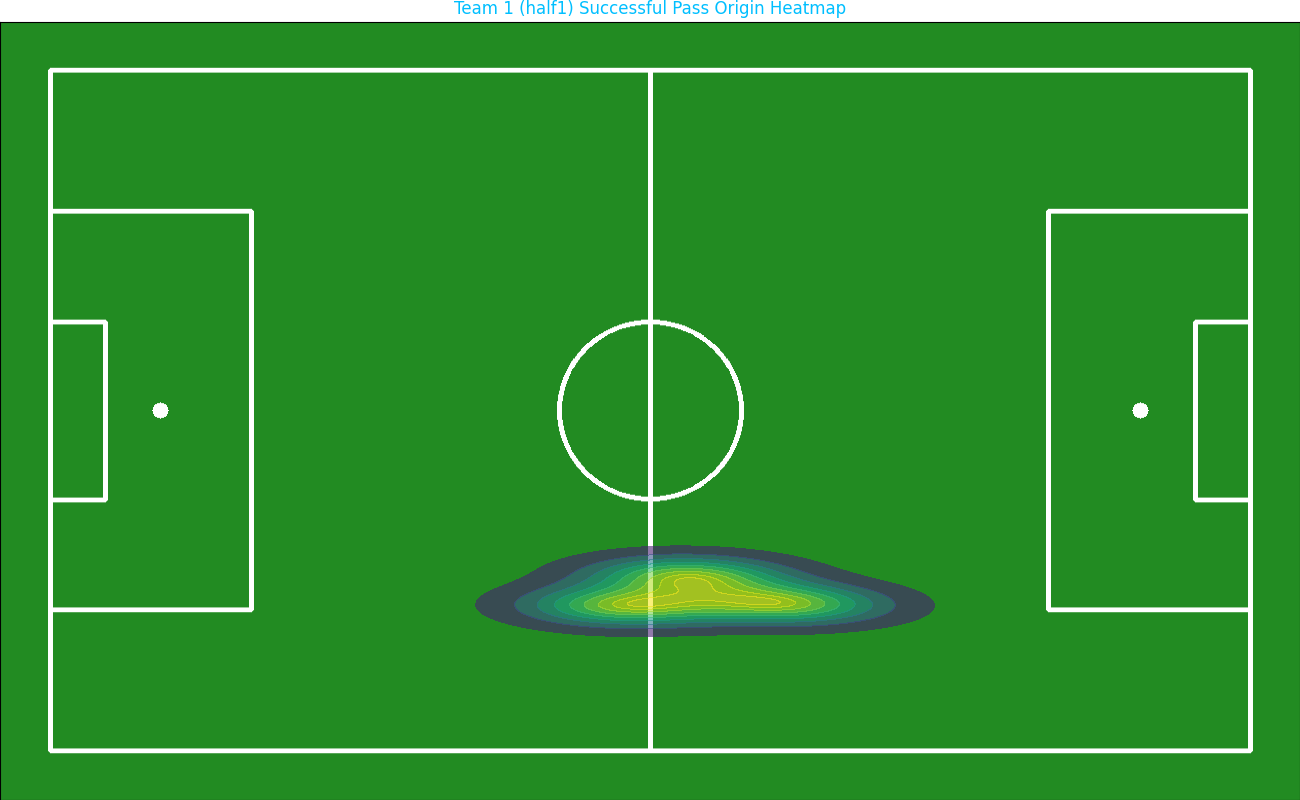

⚠️ No pass data for Team 2 (half1) - generating empty heatmap
✅ Team 2 (half1) Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team1_half1.png


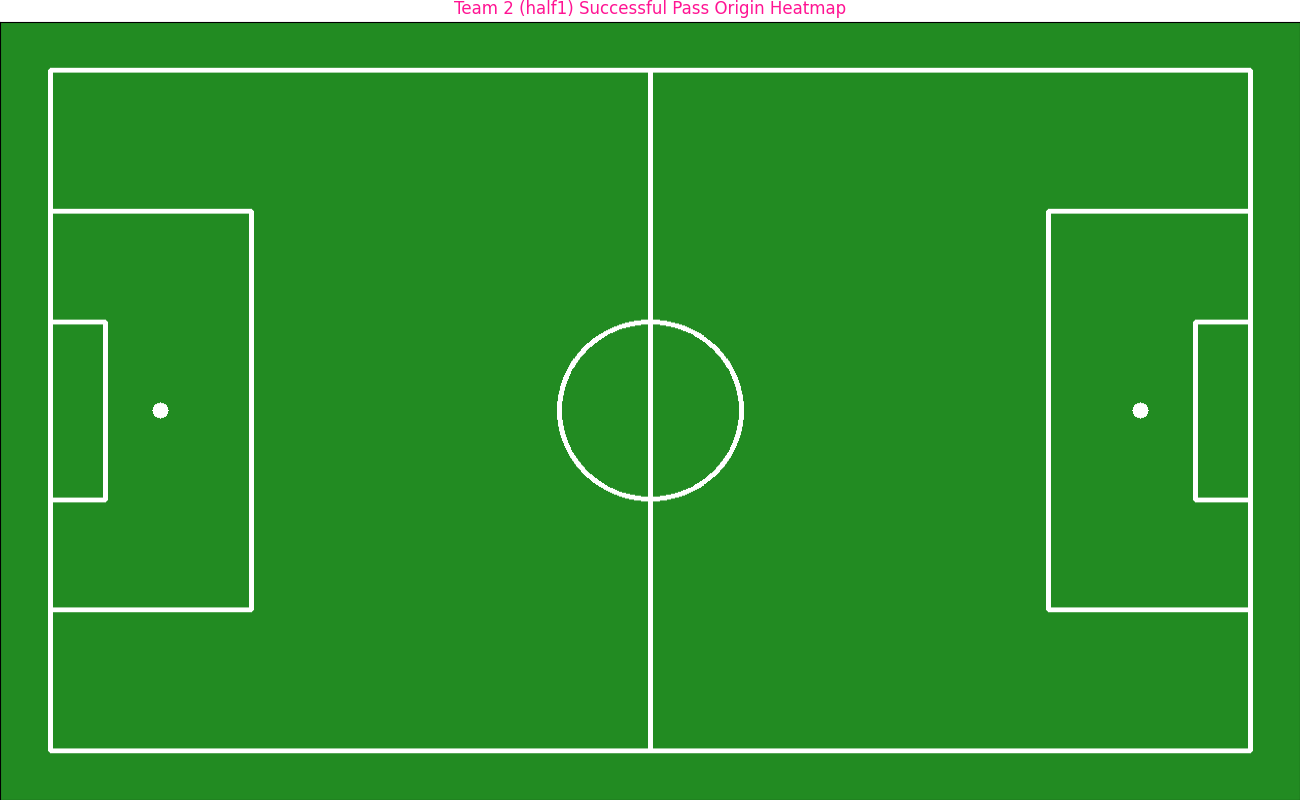


--- Generating Voronoi Heatmap for half1 ---
✅ Voronoi heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/voronoi_heatmap_half1.png


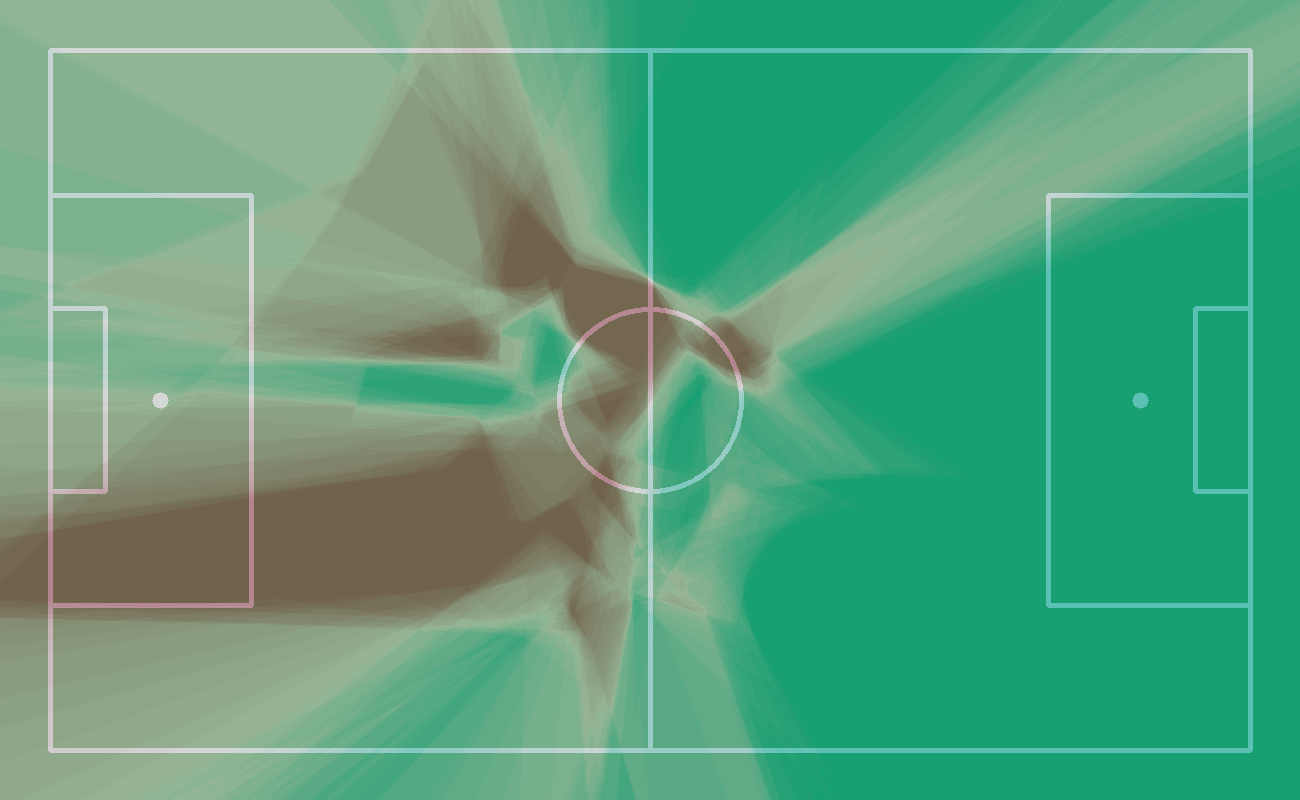


--- Generating Second Half Pass Visualizations ---

--- Generating Pass Visualizations for half2 ---
✅ Team 1 (half2) Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team0_half2.png


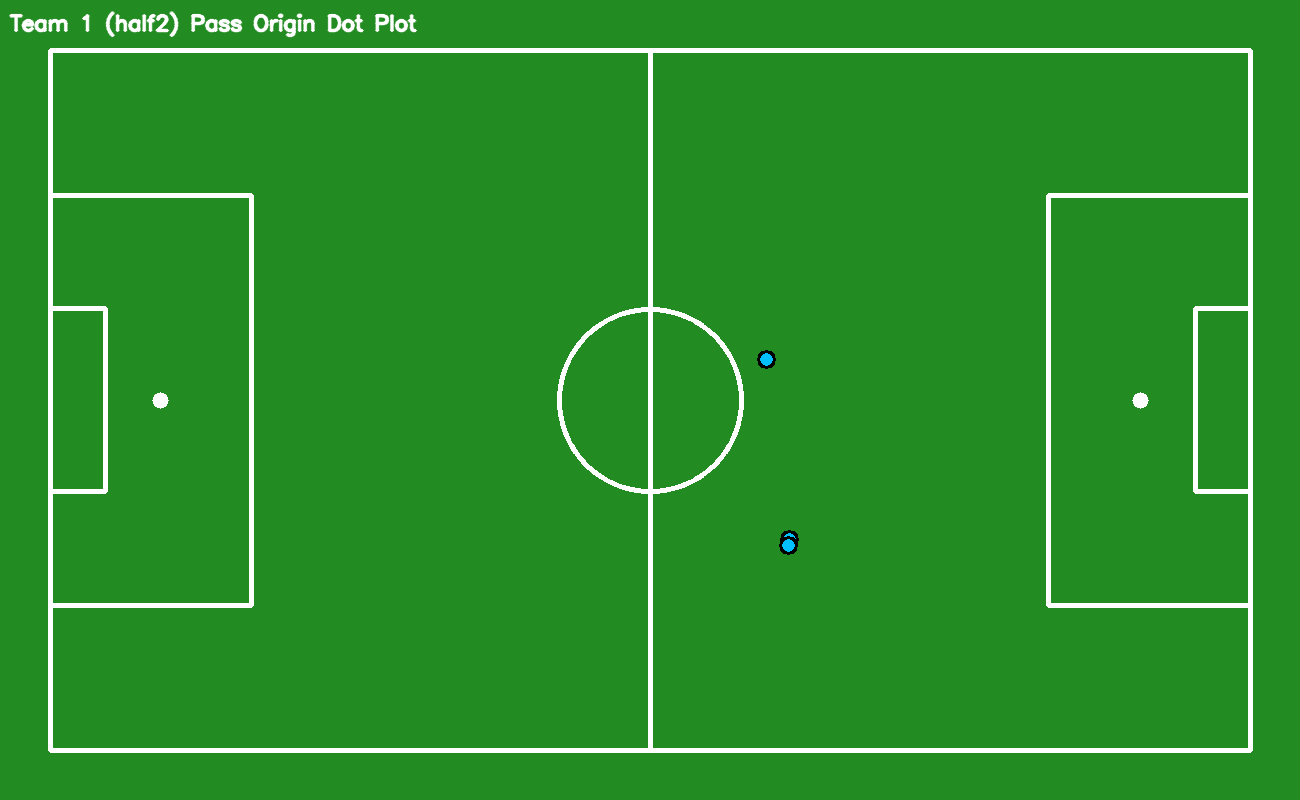

✅ Team 2 (half2) Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team1_half2.png


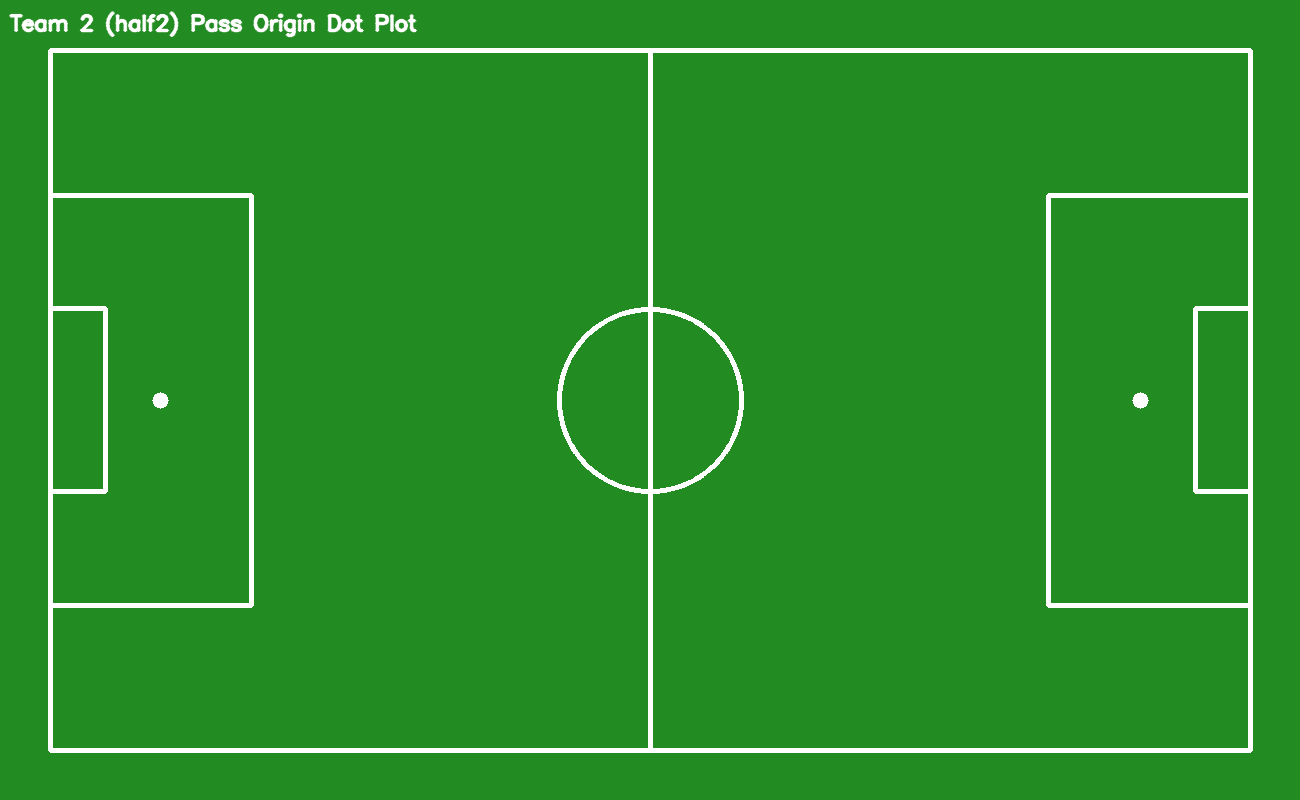

✅ Team 1 (half2) Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team0_half2.png


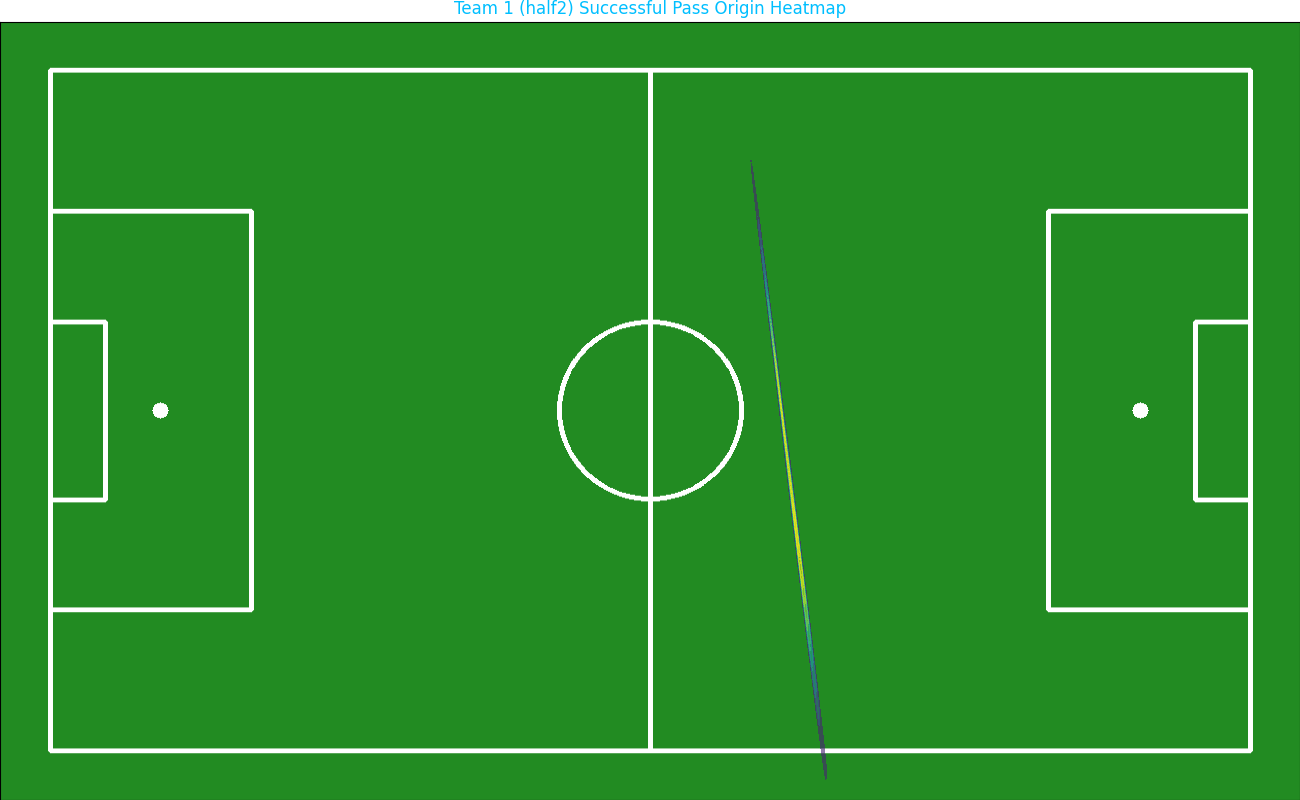

⚠️ No pass data for Team 2 (half2) - generating empty heatmap
✅ Team 2 (half2) Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team1_half2.png


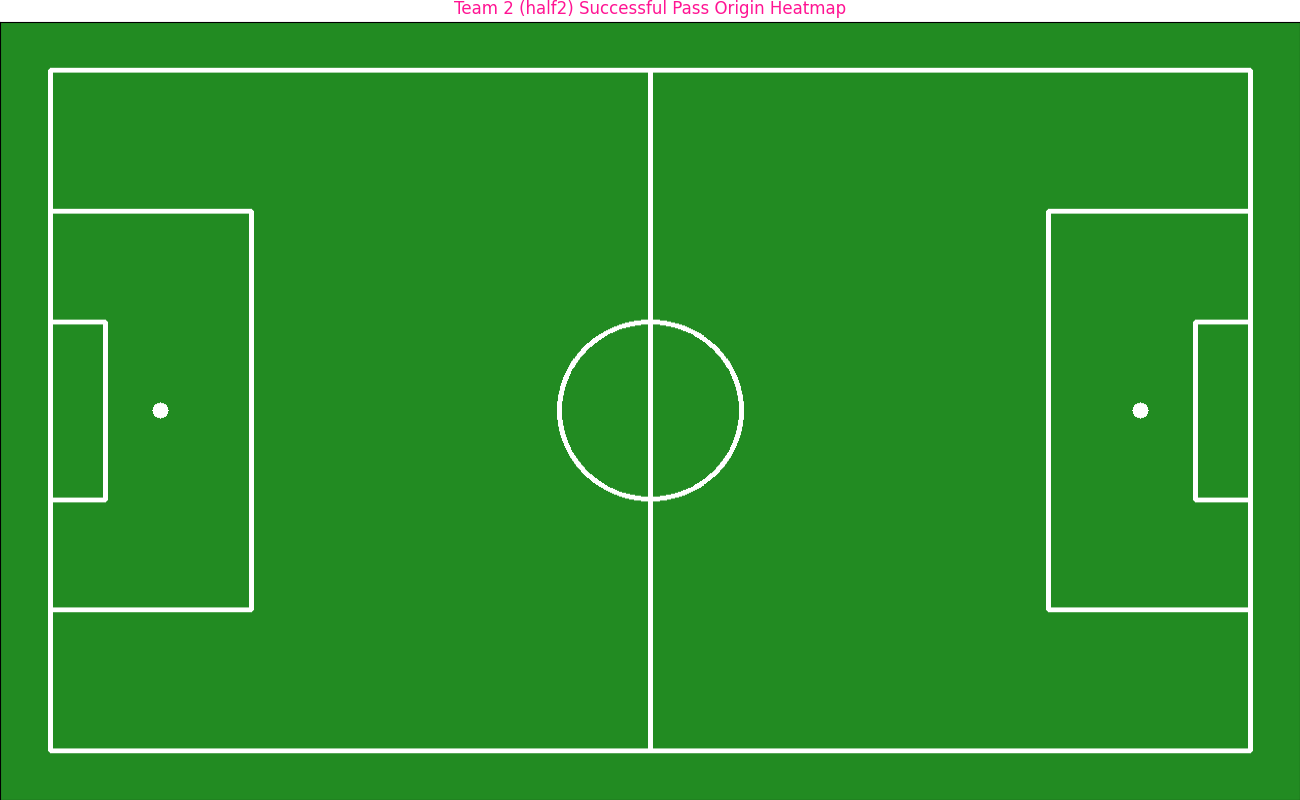


--- Generating Voronoi Heatmap for half2 ---
✅ Voronoi heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/voronoi_heatmap_half2.png


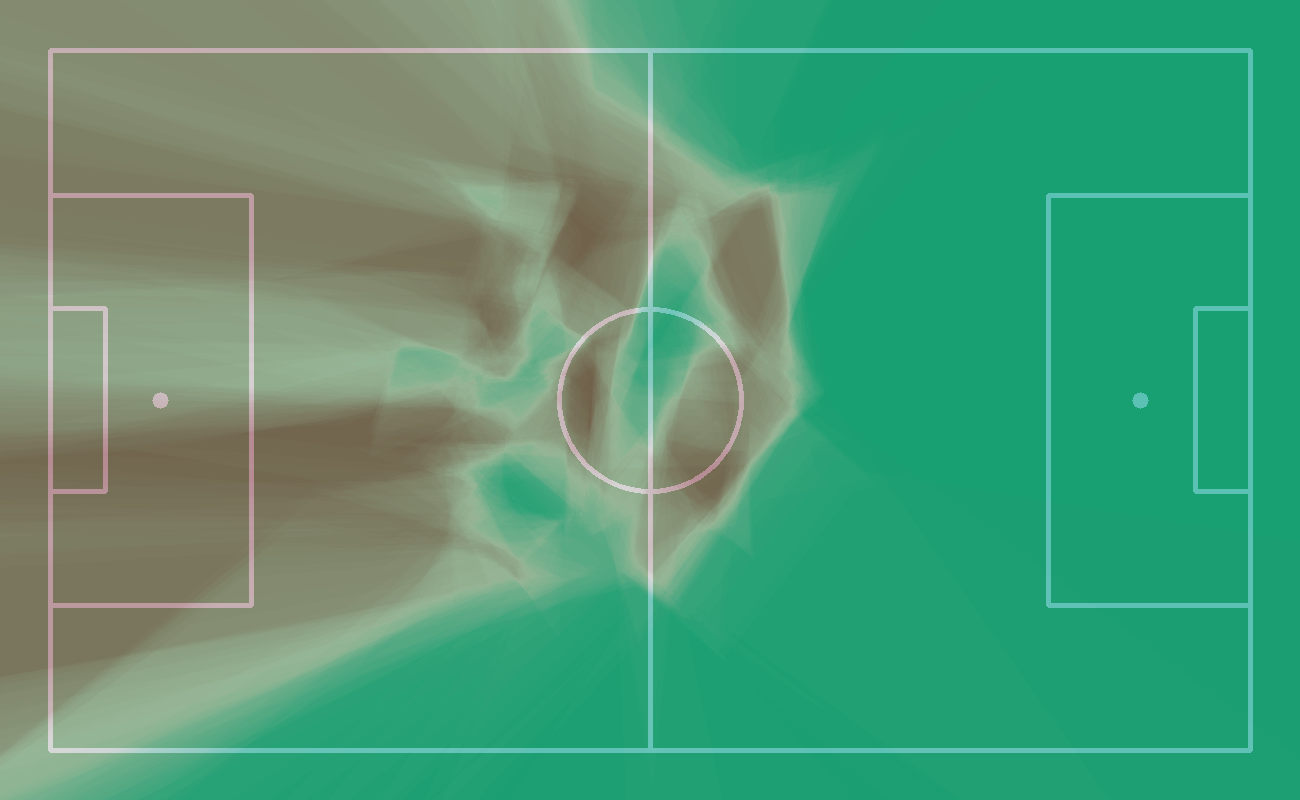


--- Generating Overall Match Pass Visualizations ---

--- Generating Pass Visualizations for overall ---
✅ Team 1 (overall) Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team0_overall.png


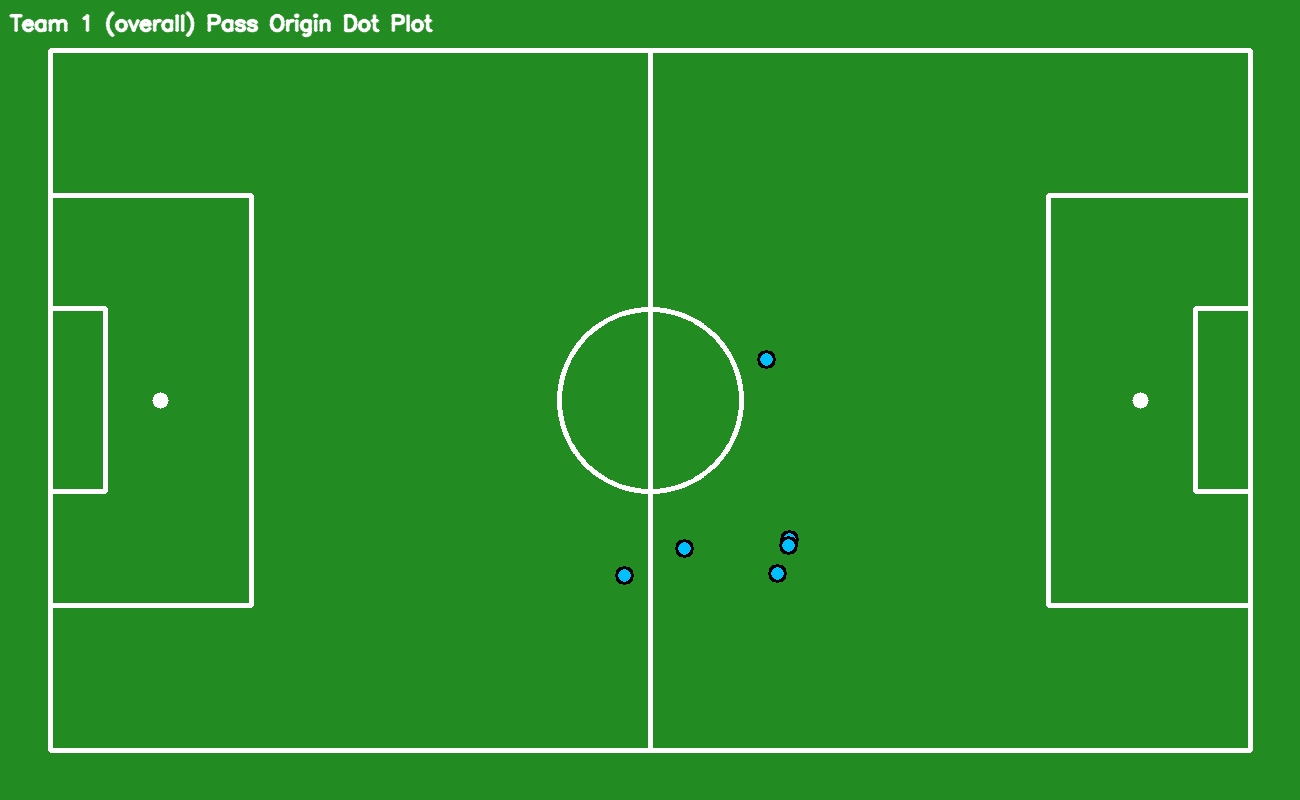

✅ Team 2 (overall) Pass origin dot plot saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot_team1_overall.png


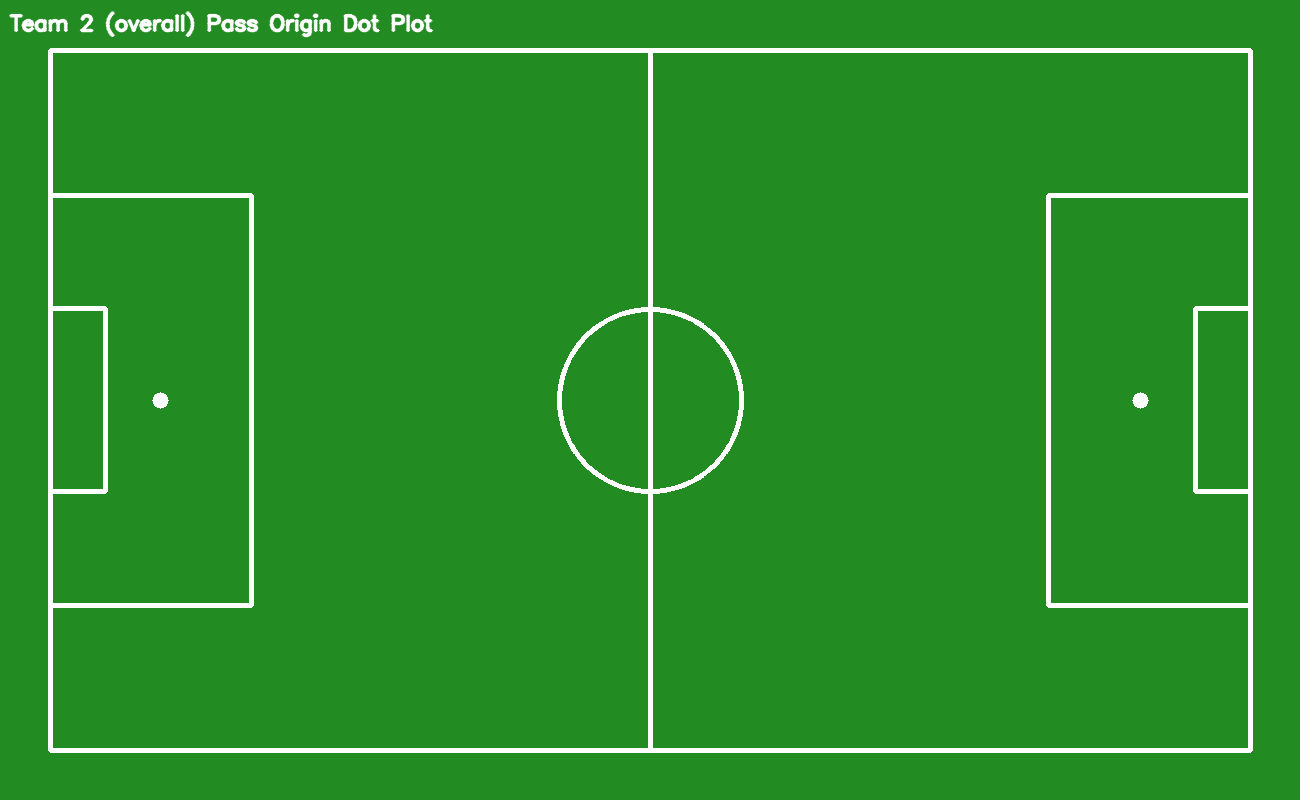

✅ Team 1 (overall) Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team0_overall.png


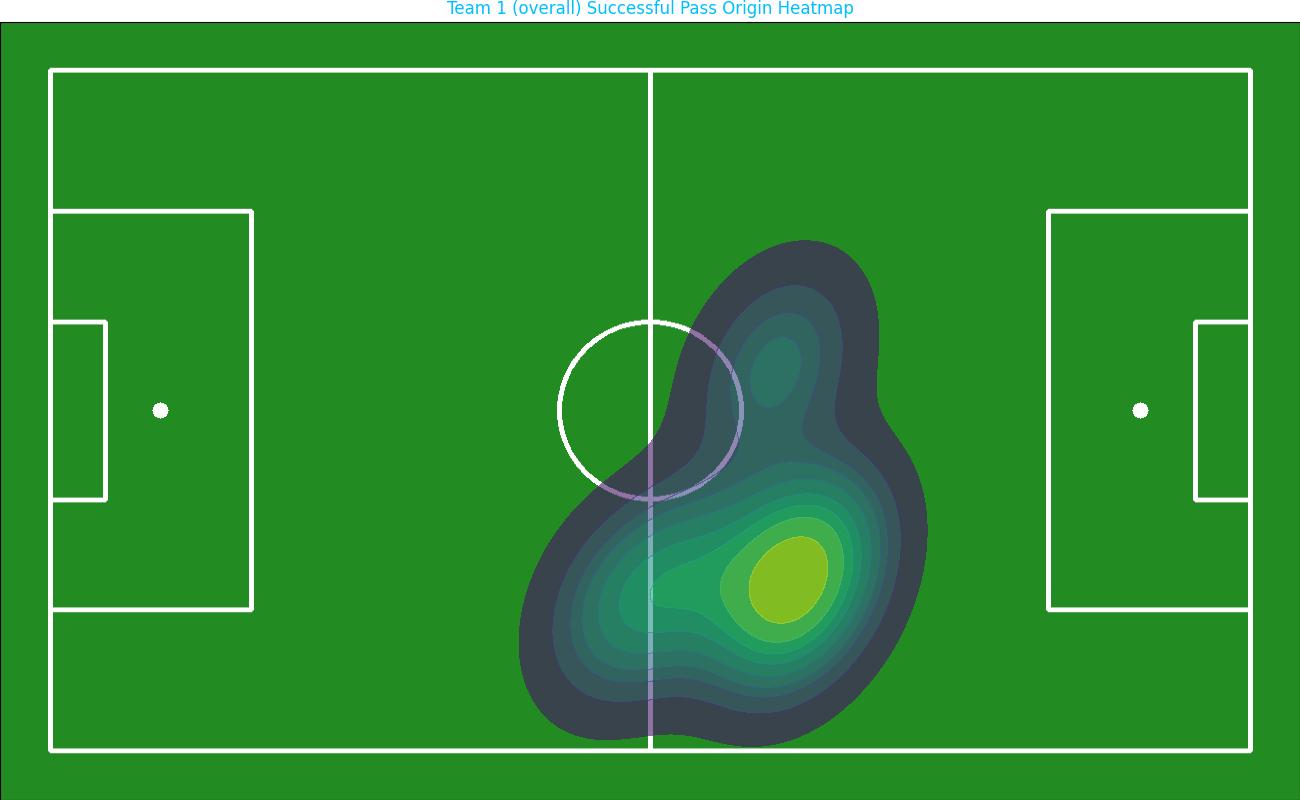

⚠️ No pass data for Team 2 (overall) - generating empty heatmap
✅ Team 2 (overall) Pass origin heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap_team1_overall.png


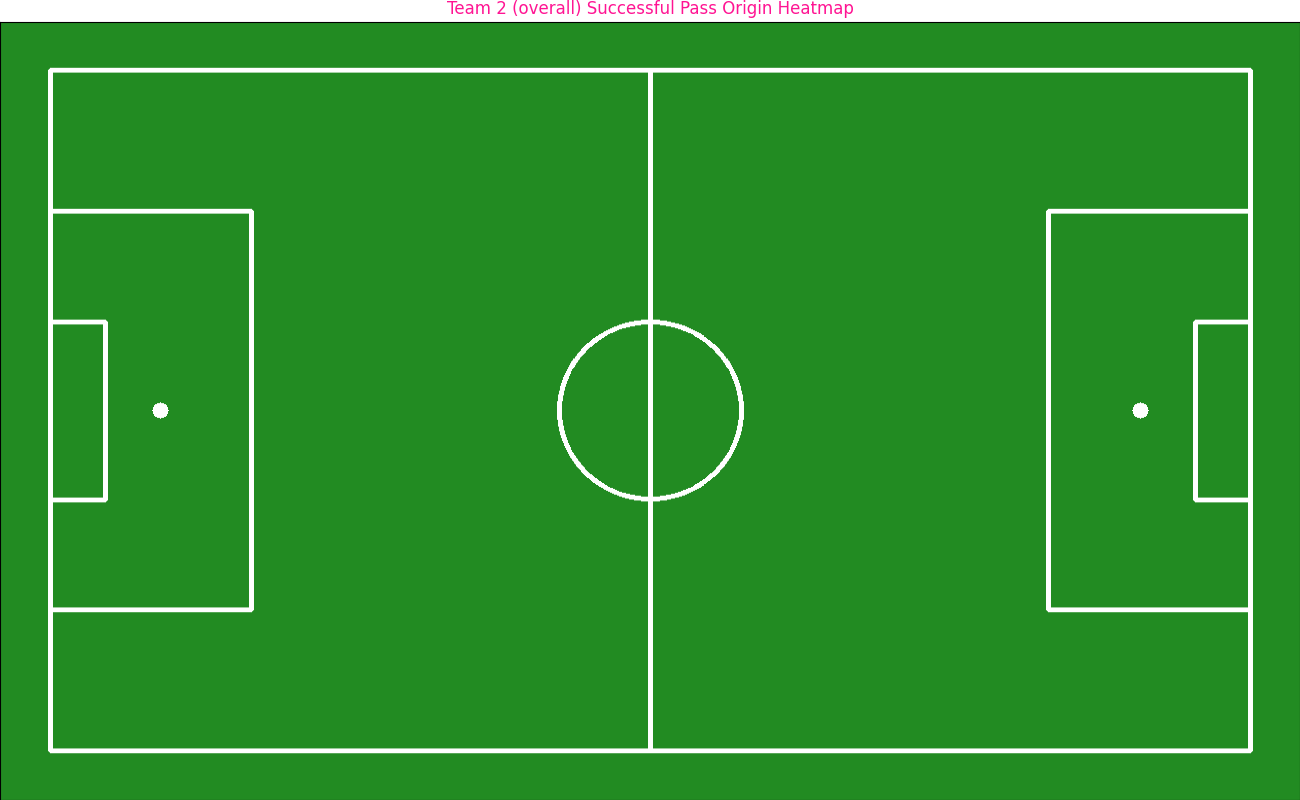


--- Generating Voronoi Heatmap for overall ---
✅ Voronoi heatmap saved to: C:/Users/tonyi/OneDrive/Documents/compvision/output/voronoi_heatmap_overall.png


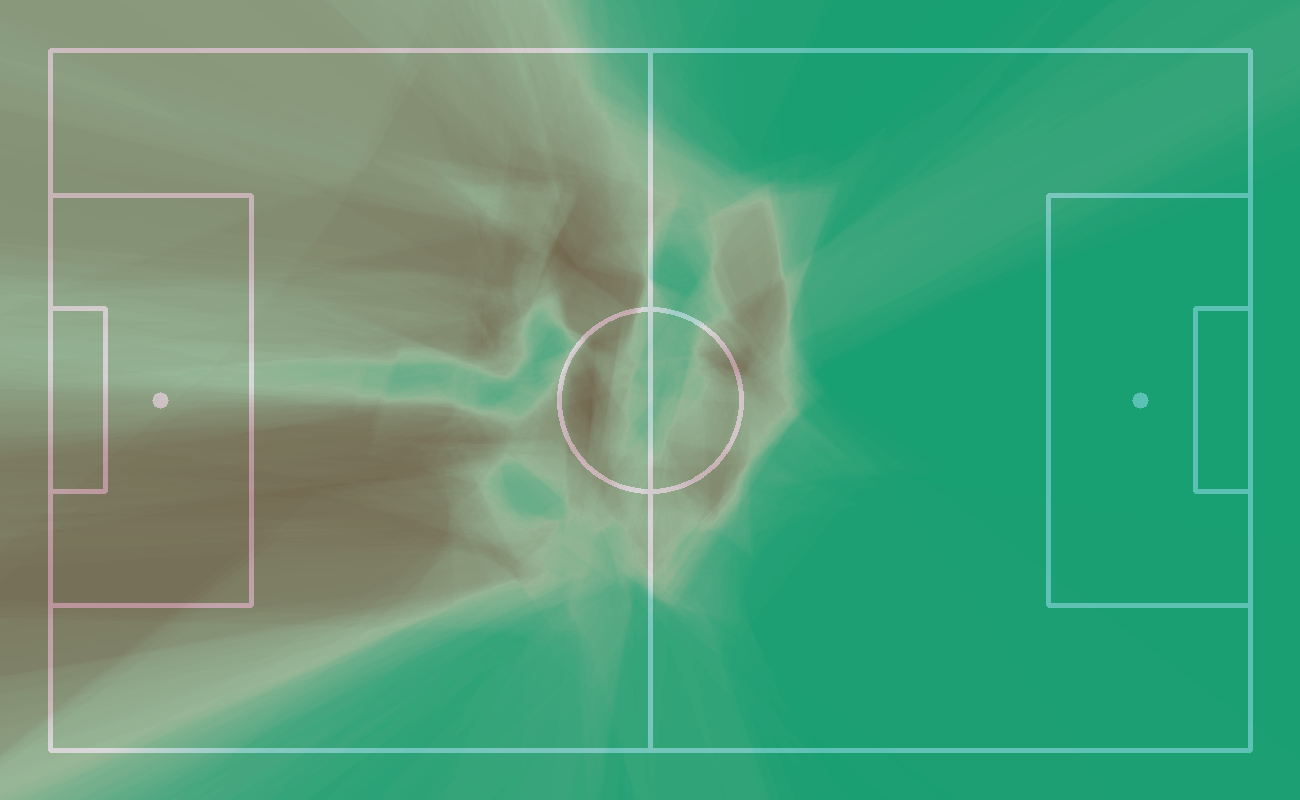


=== Final Statistics ===
Total frames with Voronoi (Overall): 118

--- Half 1 Statistics ---

Team 1 (Half 1):
  Successful Passes: 3
  Unsuccessful Passes: 0
  Total Pass Attempts: 3
  Pass Accuracy: 100.0%

Team 2 (Half 1):
  Successful Passes: 0
  Unsuccessful Passes: 1
  Total Pass Attempts: 1
  Pass Accuracy: 0.0%

--- Half 2 Statistics ---

Team 1 (Half 2):
  Successful Passes: 5
  Unsuccessful Passes: 0
  Total Pass Attempts: 5
  Pass Accuracy: 100.0%

Team 2 (Half 2):
  Successful Passes: 0
  Unsuccessful Passes: 0
  Total Pass Attempts: 0
  Pass Accuracy: N/A

--- Overall Match Statistics ---

Team 1 (Overall):
  Successful Passes: 8
  Unsuccessful Passes: 0
  Total Pass Attempts: 8
  Pass Accuracy: 100.0%

Team 2 (Overall):
  Successful Passes: 0
  Unsuccessful Passes: 1
  Total Pass Attempts: 1
  Pass Accuracy: 0.0%


In [7]:
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model
import threading
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display # For Jupyter/IPython display

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees
POSSESSION_DISTANCE_THRESHOLD = 300  # Pixels
OUTLIER_DISTANCE_THRESHOLD = 0.2    # For color outlier detection
UNCLASSIFIED_CLASS_ID = 99          # ID for players with outlier colors
COLOR_TOLERANCE = 30                # For Voronoi pixel analysis
VORONOI_CALC_SKIP_FRAMES = 5        # Calculate Voronoi every 6th frame
REF_TEAM_0_BGR = np.array([255, 191, 0], dtype=np.uint8)   # Blue reference
REF_TEAM_1_BGR = np.array([147, 20, 255], dtype=np.uint8)  # Pink reference
NEUTRAL_COLOR_BGR = np.array([200, 200, 200], dtype=np.uint8)  # Light gray

# === PATHS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4"

# Base paths for output, will be appended with "_half1", "_half2", "_overall"
DOTPLOT_OUTPUT_BASE = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot"
HEATMAP_OUTPUT_BASE = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap"
VORONOI_HEATMAP_BASE = "C:/Users/tonyi/OneDrive/Documents/compvision/output/voronoi_heatmap"

PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ"

# === GLOBAL STATE FOR HALF-TIME CONTROL ===
processing_paused = False
current_half = 1
first_half_end_frame_idx = -1 # To mark when first half ended for reporting

# === GUI CALLBACK FUNCTIONS (Modified for Keyboard Input) ===
# These functions will now be called directly from the main loop
# in response to key presses, so their signatures are simplified.
def on_stop_half_time(frame_idx_param):
    global processing_paused, current_half, first_half_end_frame_idx
    if not processing_paused and current_half == 1:
        processing_paused = True
        first_half_end_frame_idx = frame_idx_param # Store the current frame index
        print("Half-time! Processing paused. Reports will be generated at the end of the match.")

def on_start_second_half():
    global processing_paused, current_half
    if processing_paused and current_half == 1:
        processing_paused = False
        current_half = 2
        print("Starting 2nd Half! Processing resumed.")
        # Reset possession/pass stats for the new half, but accumulate Voronoi/pass origins globally
        reset_half_stats()

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2
    h /= 360
    s /= 255
    v /= 255
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )
    mask = ~green_mask

    if not np.any(mask):
        return None

    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === LOAD MODELS ===
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}
RADAR_WIDTH, RADAR_HEIGHT = None, None
BASE_PITCH_IMAGE = None

# Possession tracking (per-half and overall)
successful_passes_half1 = defaultdict(int)
unsuccessful_passes_half1 = defaultdict(int)
successful_passes_half2 = defaultdict(int)
unsuccessful_passes_half2 = defaultdict(int)
successful_passes_overall = defaultdict(int)
unsuccessful_passes_overall = defaultdict(int)

possession_event_log = [] # This can be used to analyze full match events

# Pass origin positions (per-half and overall)
successful_pass_start_positions_team0_half1 = []
successful_pass_start_positions_team1_half1 = []
successful_pass_start_pixels_team0_half1 = []
successful_pass_start_pixels_team1_half1 = []

successful_pass_start_positions_team0_half2 = []
successful_pass_start_positions_team1_half2 = []
successful_pass_start_pixels_team0_half2 = []
successful_pass_start_pixels_team1_half2 = []

successful_pass_start_positions_team0_overall = []
successful_pass_start_positions_team1_overall = []
successful_pass_start_pixels_team0_overall = []
successful_pass_start_pixels_team1_overall = []

current_possessor_id = None
current_possessor_team = None


# Voronoi state (per-half and overall)
team_0_control_sum_half1 = None
team_1_control_sum_half1 = None
voronoi_frame_count_half1 = 0

team_0_control_sum_half2 = None
team_1_control_sum_half2 = None
voronoi_frame_count_half2 = 0

team_0_control_sum_overall = None
team_1_control_sum_overall = None
voronoi_frame_count_overall = 0

found_team_colors = False
dynamic_team0_bgr = None
dynamic_team1_bgr = None

def reset_half_stats():
    global current_possessor_id, current_possessor_team
    # Reset possession for the new half, but not the overall counts
    current_possessor_id = None
    current_possessor_team = None
    # No need to reset successful_passes_half2 etc. as they are new for the second half
    # No need to reset voronoi_control_sum_half2 as it's for accumulation for the second half

# --- REPORTING FUNCTIONS (DEFINED BEFORE THEY ARE CALLED) ---

def generate_and_display_dot_plot(pass_positions, output_path, team_name, dot_color_sv):
    pitch_for_dotplot = draw_pitch(CONFIG)
    if pitch_for_dotplot.shape[2] == 4:
        pitch_for_dotplot = cv2.cvtColor(pitch_for_dotplot, cv2.COLOR_RGBA2BGR)

    if pass_positions:
        pitch_for_dotplot = draw_points_on_pitch(
            CONFIG,
            xy=np.array(pass_positions),
            face_color=dot_color_sv,
            edge_color=sv.Color.BLACK,
            radius=8,
            pitch=pitch_for_dotplot
        )

    cv2.putText(pitch_for_dotplot, f"{team_name} Pass Origin Dot Plot", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imwrite(output_path, pitch_for_dotplot)
    print(f"✅ {team_name} Pass origin dot plot saved to: {output_path}")
    display(Image(filename=output_path))

def generate_and_save_heatmap(pass_pixel_positions, output_path, team_name, title_color_rgb, base_pitch_image):
    w = base_pitch_image.shape[1]
    h = base_pitch_image.shape[0]

    fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
    base_pitch_image_rgb = cv2.cvtColor(base_pitch_image, cv2.COLOR_BGR2RGB)
    ax.imshow(base_pitch_image_rgb, extent=[0, w, 0, h], origin='lower', aspect='auto', zorder=-1)
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.set_xticks([])
    ax.set_yticks([])

    if pass_pixel_positions:
        pass_pixel_positions = np.array(pass_pixel_positions)
        sns.kdeplot(
            x=pass_pixel_positions[:,0],
            y=pass_pixel_positions[:,1],
            fill=True,
            cmap='viridis',
            alpha=0.6,
            levels=10,
            ax=ax,
            zorder=0
        )
    else:
        print(f"⚠️ No pass data for {team_name} - generating empty heatmap")

    ax.set_title(f"{team_name} Successful Pass Origin Heatmap", color=title_color_rgb)
    plt.tight_layout(pad=0)
    fig.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"✅ {team_name} Pass origin heatmap saved to: {output_path}")
    display(Image(filename=output_path))


# Function to generate all reports
def generate_all_reports(
    pass_positions_team0,
    pass_positions_team1,
    pass_pixels_team0,
    pass_pixels_team1,
    team0_control_sum_data,
    team1_control_sum_data,
    voronoi_frame_count_data,
    suffix
):
    print(f"\n--- Generating Pass Visualizations for {suffix} ---")
    team0_color_sv = sv.Color.from_hex("00BFFF")
    team1_color_sv = sv.Color.from_hex("FF1493")
    team0_title_color_rgb = (0/255, 191/255, 255/255)
    team1_title_color_rgb = (255/255, 20/255, 147/255)

    generate_and_display_dot_plot(pass_positions_team0, f"{DOTPLOT_OUTPUT_BASE}_team0_{suffix}.png", f"Team 1 ({suffix})", team0_color_sv)
    generate_and_display_dot_plot(pass_positions_team1, f"{DOTPLOT_OUTPUT_BASE}_team1_{suffix}.png", f"Team 2 ({suffix})", team1_color_sv)
    generate_and_save_heatmap(pass_pixels_team0, f"{HEATMAP_OUTPUT_BASE}_team0_{suffix}.png", f"Team 1 ({suffix})", team0_title_color_rgb, BASE_PITCH_IMAGE)
    generate_and_save_heatmap(pass_pixels_team1, f"{HEATMAP_OUTPUT_BASE}_team1_{suffix}.png", f"Team 2 ({suffix})", team1_title_color_rgb, BASE_PITCH_IMAGE)

    print(f"\n--- Generating Voronoi Heatmap for {suffix} ---")
    if voronoi_frame_count_data > 0 and found_team_colors:
        dynamic_team0_bgr_f = dynamic_team0_bgr.astype(np.float32) / 255.0
        dynamic_team1_bgr_f = dynamic_team1_bgr.astype(np.float32) / 255.0
        neutral_color_f = NEUTRAL_COLOR_BGR.astype(np.float32) / 255.0

        total_control = team0_control_sum_data + team1_control_sum_data
        total_control_safe = np.where(total_control == 0, 1, total_control)
        team0_ratio = team0_control_sum_data / total_control_safe
        team1_ratio = team1_control_sum_data / total_control_safe

        INTENSITY_FACTOR = 2.0
        heatmap_image = BASE_PITCH_IMAGE.copy().astype(np.float32) / 255.0

        dom_strength_team0 = np.clip((team0_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)
        dom_strength_team1 = np.clip((team1_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)

        mask_team0_dominates = team0_ratio > team1_ratio
        heatmap_image[mask_team0_dominates] = (
            neutral_color_f * (1 - dom_strength_team0[mask_team0_dominates, np.newaxis]) +
            dynamic_team0_bgr_f * dom_strength_team0[mask_team0_dominates, np.newaxis]
        )

        mask_team1_dominates = team1_ratio > team0_ratio
        heatmap_image[mask_team1_dominates] = (
            neutral_color_f * (1 - dom_strength_team1[mask_team1_dominates, np.newaxis]) +
            dynamic_team1_bgr_f * dom_strength_team1[mask_team1_dominates, np.newaxis]
        )

        mask_even_or_no_control = (team0_ratio == team1_ratio) | (total_control == 0)
        heatmap_image[mask_even_or_no_control] = neutral_color_f

        # Blend the Voronoi overlay with the base pitch image to keep lines visible
        voronoi_overlay = (heatmap_image * 255).astype(np.uint8)
        average_voronoi_image = cv2.addWeighted(BASE_PITCH_IMAGE, 0.3, voronoi_overlay, 0.7, 0)


        output_path = f"{VORONOI_HEATMAP_BASE}_{suffix}.png"
        cv2.imwrite(output_path, average_voronoi_image)
        print(f"✅ Voronoi heatmap saved to: {output_path}")
        display(Image(filename=output_path))
    else:
        print(f"⚠️ Could not generate Voronoi heatmap for {suffix} - insufficient data or team colors not found")


# === TRAINING LOOP ===
print("--- Training Player Classifier ---")
for frame in frame_generator:
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        BASE_PITCH_IMAGE = draw_pitch(CONFIG)
        RADAR_HEIGHT, RADAR_WIDTH = BASE_PITCH_IMAGE.shape[:2]

        # Initialize Voronoi accumulation grids for both halves and overall
        team_0_control_sum_half1 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_1_control_sum_half1 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_0_control_sum_half2 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_1_control_sum_half2 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_0_control_sum_overall = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_1_control_sum_overall = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)


        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break

# === KMEANS TRAINING ===
print("--- Training KMeans Classifier ---")
color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto").fit(color_array)
thread_preds = [None] * len(crops)

def classify_crop(i, crop):
    color = center_weighted_color(crop, h_low, h_high)
    thread_preds[i] = kmeans.predict([color])[0] if color is not None else 0

threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    label_map[tid].append(label)
track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items()}

# === GOALKEEPER TEAM ASSIGNMENT ===
positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}
team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])
centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}
for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None:
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
        goalkeeper_id_to_team[gid] = min(dists, key=dists.get)

# === OUTPUT INIT ===
dummy = draw_pitch(CONFIG)
h, w = dummy.shape[:2]
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (w, h))
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
total_frames = int(cv2.VideoCapture(SOURCE_VIDEO_PATH).get(cv2.CAP_PROP_FRAME_COUNT))

# Create OpenCV window (buttons removed due to QT dependency)
WINDOW_NAME = "Soccer Analysis"
cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)

# === MAIN PROCESSING LOOP ===
print("--- Processing Video Frames ---")
print("Press '1' to pause for Half-time (and generate Half 1 reports).")
print("Press '2' to start 2nd Half (when paused).")
print("Press 'q' to quit.")

for frame_idx, frame in tqdm(enumerate(frame_generator), total=total_frames, desc="Processing frames"):

    if processing_paused:
        paused_radar = BASE_PITCH_IMAGE.copy()
        cv2.putText(paused_radar, "HALF-TIME PAUSED", (RADAR_WIDTH // 2 - 150, RADAR_HEIGHT // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
        cv2.putText(paused_radar, "Press '2' to Start 2nd Half", (RADAR_WIDTH // 2 - 200, RADAR_HEIGHT // 2 + 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow(WINDOW_NAME, paused_radar)
        key = cv2.waitKey(1) & 0xFF # Listen for key presses even when paused
        if key == ord('q'):
            break
        elif key == ord('2'): # Press '2' to start 2nd half
            on_start_second_half() # Call the handler
        continue # Skip processing frames if paused

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    

    # === LIVE CLASSIFICATION ===
    live_colors = [None] * len(pls.xyxy)

    def extract_color(i, box):
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        live_colors[i] = color if color is not None else (0, 0, 0)

    threads = [threading.Thread(target=extract_color, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    valid_live_colors = [lc for lc in live_colors if lc is not None]
    valid_player_indices = [i for i, lc in enumerate(live_colors) if lc is not None]

    if valid_live_colors:
        predicted_classes = kmeans.predict(np.array(valid_live_colors, dtype=np.float64))
        new_player_class_ids = np.zeros(len(pls.class_id), dtype=int)
        for i, pred_class in zip(valid_player_indices, predicted_classes):
            new_player_class_ids[i] = pred_class
        pls.class_id = new_player_class_ids
    else:
        pls.class_id = np.zeros(len(pls.class_id), dtype=int)

    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    gks.class_id = np.array([goalkeeper_id_to_team.get(tid, 0) for tid in gks.tracker_id])
    players = sv.Detections.merge([pls[~gk_mask], gks])
    refs.class_id -= 1

    ball_xy_original = ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ball_xy = static_transformer.transform_points(ball_xy_original)
    ply_xy_original = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ply_xy = static_transformer.transform_points(ply_xy_original)
    ref_xy = static_transformer.transform_points(refs.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    # === POSSESSION TRACKING ===
    if len(ball_xy) > 0:
        ball_center = ball_xy[0]
        closest_player_id = None
        min_dist = float('inf')

        for i, player_pos in enumerate(ply_xy):
            dist = np.linalg.norm(player_pos - ball_center)
            if dist < min_dist:
                min_dist = dist
                closest_player_id = players.tracker_id[i]

        if closest_player_id is not None and min_dist < POSSESSION_DISTANCE_THRESHOLD:
            closest_player_team = track_id_to_team.get(closest_player_id)
            if closest_player_team is None:
                player_idx = np.where(players.tracker_id == closest_player_id)[0]
                if len(player_idx) > 0:
                    closest_player_team = players.class_id[player_idx[0]]
                else:
                    closest_player_team = 0 # Default to team 0 if no team found

            if current_possessor_id is None:
                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team
                possession_event_log.append((frame_idx, 'START_POSSESSION', current_possessor_id, current_possessor_team))
            elif closest_player_id != current_possessor_id:
                if current_possessor_team is not None:
                    if closest_player_team == current_possessor_team:
                        # Successful pass
                        if current_half == 1:
                            successful_passes_half1[current_possessor_team] += 1
                        elif current_half == 2:
                            successful_passes_half2[current_possessor_team] += 1
                        successful_passes_overall[current_possessor_team] += 1

                        possession_event_log.append((frame_idx, 'PASS_SUCCESS', current_possessor_id, current_possessor_team, closest_player_id))
                        player_idx_prev_possessor = np.where(players.tracker_id == current_possessor_id)[0]
                        if len(player_idx_prev_possessor) > 0:
                            pos_meter = ply_xy[player_idx_prev_possessor[0]]
                            x_meter = np.clip(pos_meter[0], 0, CONFIG.length)
                            y_meter = np.clip(pos_meter[1], 0, CONFIG.width)
                            x_pixel = (x_meter / CONFIG.length) * RADAR_WIDTH
                            y_pixel = RADAR_HEIGHT - (y_meter / CONFIG.width) * RADAR_HEIGHT

                            if current_possessor_team == 0:
                                if current_half == 1:
                                    successful_pass_start_positions_team0_half1.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team0_half1.append([x_pixel, y_pixel])
                                elif current_half == 2:
                                    successful_pass_start_positions_team0_half2.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team0_half2.append([x_pixel, y_pixel])
                                successful_pass_start_positions_team0_overall.append([x_meter, y_meter])
                                successful_pass_start_pixels_team0_overall.append([x_pixel, y_pixel])
                            else: # current_possessor_team == 1
                                if current_half == 1:
                                    successful_pass_start_positions_team1_half1.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team1_half1.append([x_pixel, y_pixel])
                                elif current_half == 2:
                                    successful_pass_start_positions_team1_half2.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team1_half2.append([x_pixel, y_pixel])
                                successful_pass_start_positions_team1_overall.append([x_meter, y_meter])
                                successful_pass_start_pixels_team1_overall.append([x_pixel, y_pixel])
                    else:
                        # Unsuccessful pass (turnover)
                        if current_half == 1:
                            unsuccessful_passes_half1[current_possessor_team] += 1
                        elif current_half == 2:
                            unsuccessful_passes_half2[current_possessor_team] += 1
                        unsuccessful_passes_overall[current_possessor_team] += 1
                        possession_event_log.append((frame_idx, 'PASS_UNSUCCESS', current_possessor_id, current_possessor_team, closest_player_id, closest_player_team))

                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team

    # === VORONOI DIAGRAM ACCUMULATION ===
    if (frame_idx % (VORONOI_CALC_SKIP_FRAMES + 1) == 0):
        team_0_players = ply_xy[players.class_id == 0]
        team_1_players = ply_xy[players.class_id == 1]

        if len(team_0_players) > 0 and len(team_1_players) > 0:
            voronoi_img = BASE_PITCH_IMAGE.copy()
            voronoi_img = draw_pitch_voronoi_diagram(
                config=CONFIG,
                team_1_xy=team_0_players,
                team_2_xy=team_1_players,
                team_1_color=sv.Color.from_hex('00BFFF'),
                team_2_color=sv.Color.from_hex('FF1493'),
                pitch=voronoi_img
            )

            if voronoi_img.shape[2] == 4:
                voronoi_bgr = cv2.cvtColor(voronoi_img, cv2.COLOR_RGBA2BGR)
            else:
                voronoi_bgr = voronoi_img.copy()

            # Dynamic team color discovery (first frame only)
            if not found_team_colors:
                pixels = voronoi_bgr.reshape(-1, 3)
                not_black_mask = np.linalg.norm(pixels - [0,0,0], axis=1) > 20
                not_white_mask = np.linalg.norm(pixels - [255,255,255], axis=1) > 20
                filtered_pixels = pixels[not_black_mask & not_white_mask]

                if len(filtered_pixels) >= 2:
                    kmeans_colors = KMeans(n_clusters=2, n_init="auto", random_state=42).fit(filtered_pixels.astype(np.float32))
                    dist_to_ref0_cluster0 = np.linalg.norm(kmeans_colors.cluster_centers_[0] - REF_TEAM_0_BGR)
                    dist_to_ref0_cluster1 = np.linalg.norm(kmeans_colors.cluster_centers_[1] - REF_TEAM_0_BGR)

                    if dist_to_ref0_cluster0 < dist_to_ref0_cluster1:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                    else:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)

                    found_team_colors = True

            # Accumulate control if colors are discovered
            if found_team_colors:
                pixels = voronoi_bgr.reshape(-1, 3)
                dist_to_team0_sq = np.sum((pixels - dynamic_team0_bgr)**2, axis=1)
                dist_to_team1_sq = np.sum((pixels - dynamic_team1_bgr)**2, axis=1)

                mask_team0_control = (dist_to_team0_sq < (COLOR_TOLERANCE**2)) & (dist_to_team0_sq < dist_to_team1_sq)
                mask_team1_control = (dist_to_team1_sq < (COLOR_TOLERANCE**2)) & (dist_to_team1_sq < dist_to_team0_sq)

                mask_team0_control = mask_team0_control.reshape(RADAR_HEIGHT, RADAR_WIDTH)
                mask_team1_control = mask_team1_control.reshape(RADAR_HEIGHT, RADAR_WIDTH)

                # Accumulate for current half
                if current_half == 1:
                    team_0_control_sum_half1[mask_team0_control] += 1
                    team_1_control_sum_half1[mask_team1_control] += 1
                    voronoi_frame_count_half1 += 1
                elif current_half == 2:
                    team_0_control_sum_half2[mask_team0_control] += 1
                    team_1_control_sum_half2[mask_team1_control] += 1
                    voronoi_frame_count_half2 += 1

                # Accumulate for overall
                team_0_control_sum_overall[mask_team0_control] += 1
                team_1_control_sum_overall[mask_team1_control] += 1
                voronoi_frame_count_overall += 1


    # === DRAW RADAR OUTPUT ===
    radar = BASE_PITCH_IMAGE.copy() # Start with a fresh pitch image
    radar = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex("00BFFF"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex("FF1493"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex("FFD700"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)

    team_color_0_bgr = sv.Color.from_hex("00BFFF").as_bgr()
    team_color_1_bgr = sv.Color.from_hex("FF1493").as_bgr()

    # Display current half
    cv2.putText(radar, f"Half: {current_half}", (RADAR_WIDTH - 150, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

    if current_possessor_team is not None:
        team_name = f"Team {current_possessor_team + 1}"
        display_color = team_color_0_bgr if current_possessor_team == 0 else team_color_1_bgr
        cv2.putText(radar, f"Possession: {team_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    for team_id in range(2):
        team_name = f"Team {team_id + 1}"
        # Display stats for the current half
        current_successful_passes = successful_passes_half1[team_id] if current_half == 1 else successful_passes_half2[team_id]
        current_unsuccessful_passes = unsuccessful_passes_half1[team_id] if current_half == 1 else unsuccessful_passes_half2[team_id]

        total_pass_attempts = current_successful_passes + current_unsuccessful_passes
        pass_accuracy_text = "Acc: N/A"
        if total_pass_attempts > 0:
            accuracy_percentage = (current_successful_passes / total_pass_attempts) * 100
            pass_accuracy_text = f"Acc: {accuracy_percentage:.1f}%"

        display_color = team_color_0_bgr if team_id == 0 else team_color_1_bgr
        cv2.putText(radar, f"{team_name} Passes: {current_successful_passes}", (10, 60 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)
        cv2.putText(radar, f"{pass_accuracy_text}", (10, 90 + team_id * 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    # Add instructions for keyboard controls to the radar image
    cv2.putText(radar, "Press '1' for Half-time", (RADAR_WIDTH - 250, RADAR_HEIGHT - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(radar, "Press 'q' to Quit", (RADAR_WIDTH - 200, RADAR_HEIGHT - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)


    if radar.shape[2] == 4:
        radar = cv2.cvtColor(radar, cv2.COLOR_RGBA2BGR)

    out.write(radar)
    cv2.imshow(WINDOW_NAME, radar)
    key = cv2.waitKey(1) & 0xFF # Listen for key presses during processing
    if key == ord('q'):
        break
    elif key == ord('1') and current_half == 1 and not processing_paused: # Press '1' to stop half-time
        on_stop_half_time(frame_idx) # Pass current_frame_idx

out.release()
cv2.destroyAllWindows()
print("✅ Radar video saved to:", OUTPUT_PATH)

# === GENERATE ALL REPORTS AT THE VERY END ===

print("\n--- Generating Half 1 Pass Visualizations ---")
generate_all_reports(
    successful_pass_start_positions_team0_half1,
    successful_pass_start_positions_team1_half1,
    successful_pass_start_pixels_team0_half1,
    successful_pass_start_pixels_team1_half1,
    team_0_control_sum_half1,
    team_1_control_sum_half1,
    voronoi_frame_count_half1,
    "half1"
)

# Check if the second half was processed at all (current_half is 2 or more frames were processed after half-time)
if current_half == 2:
    print("\n--- Generating Second Half Pass Visualizations ---")
    generate_all_reports(
        successful_pass_start_positions_team0_half2,
        successful_pass_start_positions_team1_half2,
        successful_pass_start_pixels_team0_half2,
        successful_pass_start_pixels_team1_half2,
        team_0_control_sum_half2,
        team_1_control_sum_half2,
        voronoi_frame_count_half2,
        "half2"
    )

print("\n--- Generating Overall Match Pass Visualizations ---")
generate_all_reports(
    successful_pass_start_positions_team0_overall,
    successful_pass_start_positions_team1_overall,
    successful_pass_start_pixels_team0_overall,
    successful_pass_start_pixels_team1_overall,
    team_0_control_sum_overall,
    team_1_control_sum_overall,
    voronoi_frame_count_overall,
    "overall"
)

# === FINAL STATS ===
print("\n=== Final Statistics ===")
print(f"Total frames with Voronoi (Overall): {voronoi_frame_count_overall}")

# Report for Half 1
print("\n--- Half 1 Statistics ---")
for team_id in range(2):
    team_name = f"Team {team_id + 1}"
    total_pass_attempts = successful_passes_half1[team_id] + unsuccessful_passes_half1[team_id]
    print(f"\n{team_name} (Half 1):")
    print(f"  Successful Passes: {successful_passes_half1[team_id]}")
    print(f"  Unsuccessful Passes: {unsuccessful_passes_half1[team_id]}")
    print(f"  Total Pass Attempts: {total_pass_attempts}")
    if total_pass_attempts > 0:
        accuracy = (successful_passes_half1[team_id] / total_pass_attempts) * 100
        print(f"  Pass Accuracy: {accuracy:.1f}%")
    else:
        print(f"  Pass Accuracy: N/A")

# Report for Half 2
print("\n--- Half 2 Statistics ---")
for team_id in range(2):
    team_name = f"Team {team_id + 1}"
    total_pass_attempts = successful_passes_half2[team_id] + unsuccessful_passes_half2[team_id]
    print(f"\n{team_name} (Half 2):")
    print(f"  Successful Passes: {successful_passes_half2[team_id]}")
    print(f"  Unsuccessful Passes: {unsuccessful_passes_half2[team_id]}")
    print(f"  Total Pass Attempts: {total_pass_attempts}")
    if total_pass_attempts > 0:
        accuracy = (successful_passes_half2[team_id] / total_pass_attempts) * 100
        print(f"  Pass Accuracy: {accuracy:.1f}%")
    else:
        print(f"  Pass Accuracy: N/A")

# Report for Overall Match
print("\n--- Overall Match Statistics ---")
for team_id in range(2):
    team_name = f"Team {team_id + 1}"
    total_pass_attempts = successful_passes_overall[team_id] + unsuccessful_passes_overall[team_id]
    print(f"\n{team_name} (Overall):")
    print(f"  Successful Passes: {successful_passes_overall[team_id]}")
    print(f"  Unsuccessful Passes: {unsuccessful_passes_overall[team_id]}")
    print(f"  Total Pass Attempts: {total_pass_attempts}")
    if total_pass_attempts > 0:
        accuracy = (successful_passes_overall[team_id] / total_pass_attempts) * 100
        print(f"  Pass Accuracy: {accuracy:.1f}%")
    else:
        print(f"  Pass Accuracy: N/A")

posession %

In [4]:
pip install --upgrade numpy scikit-learn

  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [6]:
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from ultralytics import YOLO
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)
from sports.configs.soccer import SoccerPitchConfiguration
from sports.common.view import ViewTransformer
from inference import get_model
import threading
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display # For Jupyter/IPython display

# === CONFIG ===
CONFIG = SoccerPitchConfiguration()
PLAYER_ID = 1
REFEREE_ID = 2
BALL_ID = 0
MAX_CROPS = 100
HUE_TOLERANCE = 20  # Degrees
POSSESSION_DISTANCE_THRESHOLD = 300  # Pixels
OUTLIER_DISTANCE_THRESHOLD = 0.2    # For color outlier detection
UNCLASSIFIED_CLASS_ID = 99          # ID for players with outlier colors
COLOR_TOLERANCE = 30                # For Voronoi pixel analysis
VORONOI_CALC_SKIP_FRAMES = 5        # Calculate Voronoi every 6th frame
REF_TEAM_0_BGR = np.array([255, 191, 0], dtype=np.uint8)   # Blue reference
REF_TEAM_1_BGR = np.array([147, 20, 255], dtype=np.uint8)  # Pink reference
NEUTRAL_COLOR_BGR = np.array([200, 200, 200], dtype=np.uint8)  # Light gray

# === PATHS ===
SOURCE_VIDEO_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/input/0bfacc_0.mp4"
OUTPUT_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_accuracy.mp4"

# Base paths for output, will be appended with "_half1", "_half2", "_overall"
DOTPLOT_OUTPUT_BASE = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_dotplot"
HEATMAP_OUTPUT_BASE = "C:/Users/tonyi/OneDrive/Documents/compvision/output/pass_heatmap"
VORONOI_HEATMAP_BASE = "C:/Users/tonyi/OneDrive/Documents/compvision/output/voronoi_heatmap"

PLAYER_MODEL_PATH = "C:/Users/tonyi/OneDrive/Documents/compvision/models/best.pt"
FIELD_MODEL_ID = "football-field-detection-f07vi/15"
ROBOFLOW_API_KEY = "zEZIynLb2bpdcVTfLZ1Z"

# === GLOBAL STATE FOR HALF-TIME CONTROL ===
processing_paused = False
current_half = 1
first_half_end_frame_idx = -1 # To mark when first half ended for reporting

# === POSSESSION TRACKING ===
total_active_frames = 0          # Frames during active play (excludes halftime)
team0_possession_frames = 0      # Frames where Team 0 had possession
team1_possession_frames = 0      # Frames where Team 1 had possession
no_possession_frames = 0         # Frames with no possession (ball not detected)

# === GLOBAL STATE FOR HALF-TIME CONTROL ===
team0_possession_frames_half1 = 0
team1_possession_frames_half1 = 0
no_possession_frames_half1 = 0
total_active_frames_half1 = 0

team0_possession_frames_half2 = 0
team1_possession_frames_half2 = 0
no_possession_frames_half2 = 0
total_active_frames_half2 = 0

# === GREEN HUE FILTER FUNCTIONS ===
def get_dominant_grass_hue(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2
    mask = (s >= 50) & (v >= 50)
    h_masked = h[mask]
    hist, bin_edges = np.histogram(h_masked, bins=180, range=(0, 360))
    return bin_edges[np.argmax(hist)]

def center_weighted_color(crop, h_low, h_high):
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    h *= 2  # Scale hue from 0-180 to 0-360
    h /= 360  # Normalize hue to 0-1
    s /= 255  # Normalize saturation to 0-1
    v /= 255  # Normalize value to 0-1
    
    # Create mask for green pixels (to exclude)
    green_mask = (
        (h >= h_low / 360) & (h <= h_high / 360) &
        (s >= 0.2) & (s <= 1.0) &
        (v >= 0.2) & (v <= 1.0)
    )  # Added missing closing parenthesis here
    
    # Invert to get mask for non-green pixels (to include)
    mask = ~green_mask

    if not np.any(mask):
        return None

    h_, w_ = mask.shape
    y, x = np.ogrid[:h_, :w_]
    center_y, center_x = h_ // 2, w_ // 2
    sigma = min(h_, w_) / 4
    weights = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    weights = weights * mask

    total_weight = np.sum(weights)
    if total_weight == 0:
        return None

    h_avg = np.sum(h * weights) / total_weight
    s_avg = np.sum(s * weights) / total_weight
    v_avg = np.sum(v * weights) / total_weight
    return (h_avg, s_avg, v_avg)

# === LOAD MODELS ===
PLAYER_MODEL = YOLO(PLAYER_MODEL_PATH)
FIELD_MODEL = get_model(FIELD_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# === STATE ===
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
crops, crop_tids, crop_colors = [], [], []
first_training_frame = None
static_transformer = None
goalkeeper_tracker_ids = []
goalkeeper_id_to_team = {}
RADAR_WIDTH, RADAR_HEIGHT = None, None
BASE_PITCH_IMAGE = None

# Possession tracking (per-half and overall)
successful_passes_half1 = defaultdict(int)
unsuccessful_passes_half1 = defaultdict(int)
successful_passes_half2 = defaultdict(int)
unsuccessful_passes_half2 = defaultdict(int)
successful_passes_overall = defaultdict(int)
unsuccessful_passes_overall = defaultdict(int)

possession_event_log = [] # This can be used to analyze full match events

# Pass origin positions (per-half and overall)
successful_pass_start_positions_team0_half1 = []
successful_pass_start_positions_team1_half1 = []
successful_pass_start_pixels_team0_half1 = []
successful_pass_start_pixels_team1_half1 = []

successful_pass_start_positions_team0_half2 = []
successful_pass_start_positions_team1_half2 = []
successful_pass_start_pixels_team0_half2 = []
successful_pass_start_pixels_team1_half2 = []

successful_pass_start_positions_team0_overall = []
successful_pass_start_positions_team1_overall = []
successful_pass_start_pixels_team0_overall = []
successful_pass_start_pixels_team1_overall = []

current_possessor_id = None
current_possessor_team = None

# Voronoi state (per-half and overall)
team_0_control_sum_half1 = None
team_1_control_sum_half1 = None
voronoi_frame_count_half1 = 0

team_0_control_sum_half2 = None
team_1_control_sum_half2 = None
voronoi_frame_count_half2 = 0

team_0_control_sum_overall = None
team_1_control_sum_overall = None
voronoi_frame_count_overall = 0

found_team_colors = False
dynamic_team0_bgr = None
dynamic_team1_bgr = None

def reset_half_stats():
    global current_possessor_id, current_possessor_team
    global team0_possession_frames, team1_possession_frames, no_possession_frames, total_active_frames
    
    # Reset possession for the new half, but not the overall counts
    current_possessor_id = None
    current_possessor_team = None
    
    # Reset possession counters for the new half
    team0_possession_frames = 0
    team1_possession_frames = 0
    no_possession_frames = 0
    total_active_frames = 0

def get_possession_percentages():
    # Only count frames where a team had possession (exclude no_possession_frames)
    frames_with_possession = team0_possession_frames + team1_possession_frames
    
    if frames_with_possession == 0:
        return 0.0, 0.0  # Avoid division by zero
    
    team0_percent = (team0_possession_frames / frames_with_possession) * 100
    team1_percent = (team1_possession_frames / frames_with_possession) * 100
    
    return team0_percent, team1_percent  # Now these will always sum to 100%

def detect_goalkeepers(frame, current_half):
    """Detect goalkeepers using current frame positions only"""
    global static_transformer, goalkeeper_tracker_ids, goalkeeper_id_to_team, tracker
    
    # Get player detections
    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
    
    if len(tracked.xyxy) < 2:  # Need at least 2 players
        return
    
    # Transform current positions to pitch coordinates
    current_positions = static_transformer.transform_points(
        tracked.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
    x_coords = current_positions[:, 0]
    
    # Sort by x-coordinate to find goalkeepers
    sorted_idx = np.argsort(x_coords)
    goalkeeper_tracker_ids = [
        tracked.tracker_id[sorted_idx[0]],  # Leftmost
        tracked.tracker_id[sorted_idx[-1]]  # Rightmost
    ]
    
    # Get current team assignments (from classifier)
    team0_players = []
    team1_players = []
    
    for i, tid in enumerate(tracked.tracker_id):
        if tracked.class_id[i] == 0:
            team0_players.append(current_positions[i])
        elif tracked.class_id[i] == 1:
            team1_players.append(current_positions[i])
    
    # Calculate current centroids
    team0_centroid = np.mean(team0_players, axis=0) if team0_players else None
    team1_centroid = np.mean(team1_players, axis=0) if team1_players else None
    
    # Assign goalkeepers to nearest team centroid
    for gid in goalkeeper_tracker_ids:
        gidx = np.where(tracked.tracker_id == gid)[0][0]
        gpos = current_positions[gidx]
        
        if team0_centroid is not None and team1_centroid is not None:
            dist0 = np.linalg.norm(gpos - team0_centroid)
            dist1 = np.linalg.norm(gpos - team1_centroid)
            goalkeeper_id_to_team[gid] = 0 if dist0 < dist1 else 1
        else:
            # Fallback to classifier's team assignment
            goalkeeper_id_to_team[gid] = tracked.class_id[gidx]
    
    print(f"Goalkeepers detected for half {current_half}:")
    for gid in goalkeeper_tracker_ids:
        team = goalkeeper_id_to_team.get(gid, "unknown")
        print(f"  Tracker ID {gid} assigned to team {team}")

# --- REPORTING FUNCTIONS (DEFINED BEFORE THEY ARE CALLED) ---

def generate_and_display_dot_plot(pass_positions, output_path, team_name, dot_color_sv):
    pitch_for_dotplot = draw_pitch(CONFIG)
    if pitch_for_dotplot.shape[2] == 4:
        pitch_for_dotplot = cv2.cvtColor(pitch_for_dotplot, cv2.COLOR_RGBA2BGR)

    if pass_positions:
        pitch_for_dotplot = draw_points_on_pitch(
            CONFIG,
            xy=np.array(pass_positions),
            face_color=dot_color_sv,
            edge_color=sv.Color.BLACK,
            radius=8,
            pitch=pitch_for_dotplot
        )

    cv2.putText(pitch_for_dotplot, f"{team_name} Pass Origin Dot Plot", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imwrite(output_path, pitch_for_dotplot)
    print(f"✅ {team_name} Pass origin dot plot saved to: {output_path}")
    display(Image(filename=output_path))

def generate_and_save_heatmap(pass_pixel_positions, output_path, team_name, title_color_rgb, base_pitch_image):
    w = base_pitch_image.shape[1]
    h = base_pitch_image.shape[0]

    fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
    base_pitch_image_rgb = cv2.cvtColor(base_pitch_image, cv2.COLOR_BGR2RGB)
    ax.imshow(base_pitch_image_rgb, extent=[0, w, 0, h], origin='lower', aspect='auto', zorder=-1)
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.set_xticks([])
    ax.set_yticks([])

    if pass_pixel_positions:
        pass_pixel_positions = np.array(pass_pixel_positions)
        sns.kdeplot(
            x=pass_pixel_positions[:,0],
            y=pass_pixel_positions[:,1],
            fill=True,
            cmap='viridis',
            alpha=0.6,
            levels=10,
            ax=ax,
            zorder=0
        )
    else:
        print(f"⚠️ No pass data for {team_name} - generating empty heatmap")

    ax.set_title(f"{team_name} Successful Pass Origin Heatmap", color=title_color_rgb)
    plt.tight_layout(pad=0)
    fig.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"✅ {team_name} Pass origin heatmap saved to: {output_path}")
    display(Image(filename=output_path))

# Function to generate all reports
def generate_all_reports(
    pass_positions_team0,
    pass_positions_team1,
    pass_pixels_team0,
    pass_pixels_team1,
    team0_control_sum_data,
    team1_control_sum_data,
    voronoi_frame_count_data,
    suffix
):
    print(f"\n--- Generating Pass Visualizations for {suffix} ---")
    team0_color_sv = sv.Color.from_hex("00BFFF")
    team1_color_sv = sv.Color.from_hex("FF1493")
    team0_title_color_rgb = (0/255, 191/255, 255/255)
    team1_title_color_rgb = (255/255, 20/255, 147/255)

    generate_and_display_dot_plot(pass_positions_team0, f"{DOTPLOT_OUTPUT_BASE}_team0_{suffix}.png", f"Team 1 ({suffix})", team0_color_sv)
    generate_and_display_dot_plot(pass_positions_team1, f"{DOTPLOT_OUTPUT_BASE}_team1_{suffix}.png", f"Team 2 ({suffix})", team1_color_sv)
    generate_and_save_heatmap(pass_pixels_team0, f"{HEATMAP_OUTPUT_BASE}_team0_{suffix}.png", f"Team 1 ({suffix})", team0_title_color_rgb, BASE_PITCH_IMAGE)
    generate_and_save_heatmap(pass_pixels_team1, f"{HEATMAP_OUTPUT_BASE}_team1_{suffix}.png", f"Team 2 ({suffix})", team1_title_color_rgb, BASE_PITCH_IMAGE)

    print(f"\n--- Generating Voronoi Heatmap for {suffix} ---")
    if voronoi_frame_count_data > 0 and found_team_colors:
        dynamic_team0_bgr_f = dynamic_team0_bgr.astype(np.float32) / 255.0
        dynamic_team1_bgr_f = dynamic_team1_bgr.astype(np.float32) / 255.0
        neutral_color_f = NEUTRAL_COLOR_BGR.astype(np.float32) / 255.0

        total_control = team0_control_sum_data + team1_control_sum_data
        total_control_safe = np.where(total_control == 0, 1, total_control)
        team0_ratio = team0_control_sum_data / total_control_safe
        team1_ratio = team1_control_sum_data / total_control_safe

        INTENSITY_FACTOR = 2.0
        heatmap_image = BASE_PITCH_IMAGE.copy().astype(np.float32) / 255.0

        dom_strength_team0 = np.clip((team0_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)
        dom_strength_team1 = np.clip((team1_ratio - 0.5) * INTENSITY_FACTOR, 0, 1)

        mask_team0_dominates = team0_ratio > team1_ratio
        heatmap_image[mask_team0_dominates] = (
            neutral_color_f * (1 - dom_strength_team0[mask_team0_dominates, np.newaxis]) +
            dynamic_team0_bgr_f * dom_strength_team0[mask_team0_dominates, np.newaxis]
        )

        mask_team1_dominates = team1_ratio > team0_ratio
        heatmap_image[mask_team1_dominates] = (
            neutral_color_f * (1 - dom_strength_team1[mask_team1_dominates, np.newaxis]) +
            dynamic_team1_bgr_f * dom_strength_team1[mask_team1_dominates, np.newaxis]
        )

        mask_even_or_no_control = (team0_ratio == team1_ratio) | (total_control == 0)
        heatmap_image[mask_even_or_no_control] = neutral_color_f

        # Blend the Voronoi overlay with the base pitch image to keep lines visible
        voronoi_overlay = (heatmap_image * 255).astype(np.uint8)
        average_voronoi_image = cv2.addWeighted(BASE_PITCH_IMAGE, 0.3, voronoi_overlay, 0.7, 0)

        output_path = f"{VORONOI_HEATMAP_BASE}_{suffix}.png"
        cv2.imwrite(output_path, average_voronoi_image)
        print(f"✅ Voronoi heatmap saved to: {output_path}")
        display(Image(filename=output_path))
    else:
        print(f"⚠️ Could not generate Voronoi heatmap for {suffix} - insufficient data or team colors not found")

# === UPDATE on_stop_half_time FUNCTION ===
def on_stop_half_time(frame_idx_param):
    global processing_paused, current_half, first_half_end_frame_idx
    global team0_possession_frames_half1, team1_possession_frames_half1
    global no_possession_frames_half1, total_active_frames_half1
    
    if not processing_paused and current_half == 1:
        processing_paused = True
        first_half_end_frame_idx = frame_idx_param
        
        # CAPTURE FIRST HALF STATS
        team0_possession_frames_half1 = team0_possession_frames
        team1_possession_frames_half1 = team1_possession_frames
        no_possession_frames_half1 = no_possession_frames
        total_active_frames_half1 = total_active_frames
        
        print("Half-time! Processing paused. Reports will be generated at the end of the match.")

def on_start_second_half(frame):
    global processing_paused, current_half
    global goalkeeper_tracker_ids, goalkeeper_id_to_team
    
    if processing_paused and current_half == 1:
        # Clear previous goalkeeper assignments
        goalkeeper_tracker_ids = []
        goalkeeper_id_to_team = {}
        
        # Force redetection for second half
        detect_goalkeepers(frame, current_half=2)
        
        processing_paused = False
        current_half = 2
        print("Starting 2nd Half! Processing resumed.")
        print(f"Second half goalkeepers: {goalkeeper_tracker_ids}")
        reset_half_stats()

# === TRAINING LOOP ===
print("--- Training Player Classifier ---")
for frame in frame_generator:
    if first_training_frame is None:
        first_training_frame = frame.copy()
        dom_hue = get_dominant_grass_hue(frame)
        h_low = max(0, dom_hue - HUE_TOLERANCE)
        h_high = min(360, dom_hue + HUE_TOLERANCE)

        field_result = FIELD_MODEL.infer(frame, confidence=0.3)[0]
        kpts = sv.KeyPoints.from_inference(field_result)
        mask = kpts.confidence[0] > 0.5
        frame_pts = kpts.xy[0][mask]
        pitch_pts = np.array(CONFIG.vertices)[mask]
        static_transformer = ViewTransformer(source=frame_pts, target=pitch_pts)

        BASE_PITCH_IMAGE = draw_pitch(CONFIG)
        RADAR_HEIGHT, RADAR_WIDTH = BASE_PITCH_IMAGE.shape[:2]

        # Initialize Voronoi accumulation grids for both halves and overall
        team_0_control_sum_half1 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_1_control_sum_half1 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_0_control_sum_half2 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_1_control_sum_half2 = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_0_control_sum_overall = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)
        team_1_control_sum_overall = np.zeros((RADAR_HEIGHT, RADAR_WIDTH), dtype=np.float32)

        yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
        dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
        tracked_first = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])
        if tracked_first.xyxy.shape[0] < 2:
            continue
        positions = static_transformer.transform_points(tracked_first.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
        x_coords = positions[:, 0]
        sorted_idx = np.argsort(x_coords)
        goalkeeper_tracker_ids = [
            tracked_first.tracker_id[sorted_idx[0]],
            tracked_first.tracker_id[sorted_idx[-1]]
        ]

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    tracked = tracker.update_with_detections(dets[dets.class_id == PLAYER_ID])

    for tid, box in zip(tracked.tracker_id, tracked.xyxy):
        if len(crops) >= MAX_CROPS:
            break
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        if color is None:
            continue
        crops.append(crop)
        crop_colors.append(color)
        crop_tids.append(tid)
    if len(crops) >= MAX_CROPS:
        break

# === KMEANS TRAINING ===
print("--- Training KMeans Classifier ---")
color_array = np.array(crop_colors, dtype=np.float64)
kmeans = KMeans(n_clusters=2, n_init="auto").fit(color_array)
thread_preds = [None] * len(crops)

def classify_crop(i, crop):
    color = center_weighted_color(crop, h_low, h_high)
    thread_preds[i] = kmeans.predict([color])[0] if color is not None else 0

threads = [threading.Thread(target=classify_crop, args=(i, crop)) for i, crop in enumerate(crops)]
[t.start() for t in threads]
[t.join() for t in threads]

label_map = defaultdict(list)
for tid, label in zip(crop_tids, thread_preds):
    label_map[tid].append(label)
track_id_to_team = {tid: max(set(l), key=l.count) for tid, l in label_map.items()}

# === GOALKEEPER TEAM ASSIGNMENT ===
positions_dict = {tid: pos for tid, pos in zip(tracked_first.tracker_id, positions)}
team_positions = defaultdict(list)
for tid, team in track_id_to_team.items():
    if tid in positions_dict:
        team_positions[team].append(positions_dict[tid])
centroids = {team: np.mean(pts, axis=0) for team, pts in team_positions.items()}
for gid in goalkeeper_tracker_ids:
    gpos = positions_dict.get(gid)
    if gpos is not None:
        dists = {team: np.linalg.norm(gpos - center) for team, center in centroids.items()}
        goalkeeper_id_to_team[gid] = min(dists, key=dists.get)

print("Initial Goalkeeper Assignments:")
for gid in goalkeeper_tracker_ids:
    print(f"  Tracker ID {gid} assigned to team {goalkeeper_id_to_team.get(gid, 'unknown')}")

# === OUTPUT INIT ===
dummy = draw_pitch(CONFIG)
h, w = dummy.shape[:2]
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (w, h))
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
total_frames = int(cv2.VideoCapture(SOURCE_VIDEO_PATH).get(cv2.CAP_PROP_FRAME_COUNT))

# Create OpenCV window (buttons removed due to QT dependency)
WINDOW_NAME = "Soccer Analysis"
cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)

# === MAIN PROCESSING LOOP ===
print("--- Processing Video Frames ---")
print("Press '1' to pause for Half-time (and generate Half 1 reports).")
print("Press '2' to start 2nd Half (when paused).")
print("Press 'q' to quit.")

for frame_idx, frame in tqdm(enumerate(frame_generator), total=total_frames, desc="Processing frames"):

    if processing_paused:
        paused_radar = BASE_PITCH_IMAGE.copy()
        cv2.putText(paused_radar, "HALF-TIME PAUSED", (RADAR_WIDTH // 2 - 150, RADAR_HEIGHT // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
        cv2.putText(paused_radar, "Press '2' to Start 2nd Half", (RADAR_WIDTH // 2 - 200, RADAR_HEIGHT // 2 + 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow(WINDOW_NAME, paused_radar)
        key = cv2.waitKey(1) & 0xFF # Listen for key presses even when paused
        if key == ord('q'):
            break
        elif key == ord('2'): # Press '2' to start 2nd half
            on_start_second_half(frame) # Pass current frame for goalkeeper detection
        continue # Skip processing frames if paused

    yolo_result = PLAYER_MODEL.predict(frame, verbose=False)[0]
    dets = sv.Detections.from_ultralytics(yolo_result).with_nms(0.5, class_agnostic=True)
    ball = dets[dets.class_id == BALL_ID]
    ball.xyxy = sv.pad_boxes(ball.xyxy, px=10)
    nonball = dets[dets.class_id != BALL_ID]
    tracked = tracker.update_with_detections(nonball)

    pls = tracked[tracked.class_id == PLAYER_ID]
    refs = tracked[tracked.class_id == REFEREE_ID]

    # === LIVE CLASSIFICATION ===
    live_colors = [None] * len(pls.xyxy)

    def extract_color(i, box):
        crop = sv.crop_image(frame, box)
        color = center_weighted_color(crop, h_low, h_high)
        live_colors[i] = color if color is not None else (0, 0, 0)

    threads = [threading.Thread(target=extract_color, args=(i, box)) for i, box in enumerate(pls.xyxy)]
    [t.start() for t in threads]
    [t.join() for t in threads]

    valid_live_colors = [lc for lc in live_colors if lc is not None]
    valid_player_indices = [i for i, lc in enumerate(live_colors) if lc is not None]

    if valid_live_colors:
        predicted_classes = kmeans.predict(np.array(valid_live_colors, dtype=np.float64))
        new_player_class_ids = np.zeros(len(pls.class_id), dtype=int)
        for i, pred_class in zip(valid_player_indices, predicted_classes):
            new_player_class_ids[i] = pred_class
        pls.class_id = new_player_class_ids
    else:
        pls.class_id = np.zeros(len(pls.class_id), dtype=int)

    # Override goalkeeper IDs
    gk_mask = np.array([tid in goalkeeper_tracker_ids for tid in pls.tracker_id])
    gks = pls[gk_mask]
    gks.class_id = np.array([goalkeeper_id_to_team.get(tid, 0) for tid in gks.tracker_id])
    players = sv.Detections.merge([pls[~gk_mask], gks])
    refs.class_id -= 1

    ball_xy_original = ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ball_xy = static_transformer.transform_points(ball_xy_original)
    ply_xy_original = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    ply_xy = static_transformer.transform_points(ply_xy_original)
    ref_xy = static_transformer.transform_points(refs.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

    # === POSSESSION TRACKING ===
    if len(ball_xy) > 0:
        ball_center = ball_xy[0]
        closest_player_id = None
        min_dist = float('inf')

        for i, player_pos in enumerate(ply_xy):
            dist = np.linalg.norm(player_pos - ball_center)
            if dist < min_dist:
                min_dist = dist
                closest_player_id = players.tracker_id[i]

        if closest_player_id is not None and min_dist < POSSESSION_DISTANCE_THRESHOLD:
            closest_player_team = track_id_to_team.get(closest_player_id)
            if closest_player_team is None:
                player_idx = np.where(players.tracker_id == closest_player_id)[0]
                if len(player_idx) > 0:
                    closest_player_team = players.class_id[player_idx[0]]
                else:
                    closest_player_team = 0 # Default to team 0 if no team found

            if current_possessor_id is None:
                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team
                possession_event_log.append((frame_idx, 'START_POSSESSION', current_possessor_id, current_possessor_team))
            elif closest_player_id != current_possessor_id:
                if current_possessor_team is not None:
                    if closest_player_team == current_possessor_team:
                        # Successful pass
                        if current_half == 1:
                            successful_passes_half1[current_possessor_team] += 1
                        elif current_half == 2:
                            successful_passes_half2[current_possessor_team] += 1
                        successful_passes_overall[current_possessor_team] += 1

                        possession_event_log.append((frame_idx, 'PASS_SUCCESS', current_possessor_id, current_possessor_team, closest_player_id))
                        player_idx_prev_possessor = np.where(players.tracker_id == current_possessor_id)[0]
                        if len(player_idx_prev_possessor) > 0:
                            pos_meter = ply_xy[player_idx_prev_possessor[0]]
                            x_meter = np.clip(pos_meter[0], 0, CONFIG.length)
                            y_meter = np.clip(pos_meter[1], 0, CONFIG.width)
                            x_pixel = (x_meter / CONFIG.length) * RADAR_WIDTH
                            y_pixel = RADAR_HEIGHT - (y_meter / CONFIG.width) * RADAR_HEIGHT

                            if current_possessor_team == 0:
                                if current_half == 1:
                                    successful_pass_start_positions_team0_half1.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team0_half1.append([x_pixel, y_pixel])
                                elif current_half == 2:
                                    successful_pass_start_positions_team0_half2.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team0_half2.append([x_pixel, y_pixel])
                                successful_pass_start_positions_team0_overall.append([x_meter, y_meter])
                                successful_pass_start_pixels_team0_overall.append([x_pixel, y_pixel])
                            else: # current_possessor_team == 1
                                if current_half == 1:
                                    successful_pass_start_positions_team1_half1.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team1_half1.append([x_pixel, y_pixel])
                                elif current_half == 2:
                                    successful_pass_start_positions_team1_half2.append([x_meter, y_meter])
                                    successful_pass_start_pixels_team1_half2.append([x_pixel, y_pixel])
                                successful_pass_start_positions_team1_overall.append([x_meter, y_meter])
                                successful_pass_start_pixels_team1_overall.append([x_pixel, y_pixel])
                    else:
                        # Unsuccessful pass (turnover)
                        if current_half == 1:
                            unsuccessful_passes_half1[current_possessor_team] += 1
                        elif current_half == 2:
                            unsuccessful_passes_half2[current_possessor_team] += 1
                        unsuccessful_passes_overall[current_possessor_team] += 1
                        possession_event_log.append((frame_idx, 'PASS_UNSUCCESS', current_possessor_id, current_possessor_team, closest_player_id, closest_player_team))

                current_possessor_id = closest_player_id
                current_possessor_team = closest_player_team

    # === UPDATE POSSESSION STATS (ONLY DURING ACTIVE PLAY) ===
    if not processing_paused:
        total_active_frames += 1
        
        if current_possessor_team == 0:
            team0_possession_frames += 1
        elif current_possessor_team == 1:
            team1_possession_frames += 1
        else:
            no_possession_frames += 1

    # === VORONOI DIAGRAM ACCUMULATION ===
    if (frame_idx % (VORONOI_CALC_SKIP_FRAMES + 1) == 0):
        team_0_players = ply_xy[players.class_id == 0]
        team_1_players = ply_xy[players.class_id == 1]

        if len(team_0_players) > 0 and len(team_1_players) > 0:
            voronoi_img = BASE_PITCH_IMAGE.copy()
            voronoi_img = draw_pitch_voronoi_diagram(
                config=CONFIG,
                team_1_xy=team_0_players,
                team_2_xy=team_1_players,
                team_1_color=sv.Color.from_hex('00BFFF'),
                team_2_color=sv.Color.from_hex('FF1493'),
                pitch=voronoi_img
            )

            if voronoi_img.shape[2] == 4:
                voronoi_bgr = cv2.cvtColor(voronoi_img, cv2.COLOR_RGBA2BGR)
            else:
                voronoi_bgr = voronoi_img.copy()

            # Dynamic team color discovery (first frame only)
            if not found_team_colors:
                pixels = voronoi_bgr.reshape(-1, 3)
                not_black_mask = np.linalg.norm(pixels - [0,0,0], axis=1) > 20
                not_white_mask = np.linalg.norm(pixels - [255,255,255], axis=1) > 20
                filtered_pixels = pixels[not_black_mask & not_white_mask]

                if len(filtered_pixels) >= 2:
                    kmeans_colors = KMeans(n_clusters=2, n_init="auto", random_state=42).fit(filtered_pixels.astype(np.float32))
                    dist_to_ref0_cluster0 = np.linalg.norm(kmeans_colors.cluster_centers_[0] - REF_TEAM_0_BGR)
                    dist_to_ref0_cluster1 = np.linalg.norm(kmeans_colors.cluster_centers_[1] - REF_TEAM_0_BGR)

                    if dist_to_ref0_cluster0 < dist_to_ref0_cluster1:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                    else:
                        dynamic_team0_bgr = kmeans_colors.cluster_centers_[1].astype(np.uint8)
                        dynamic_team1_bgr = kmeans_colors.cluster_centers_[0].astype(np.uint8)

                    found_team_colors = True

            # Accumulate control if colors are discovered
            if found_team_colors:
                pixels = voronoi_bgr.reshape(-1, 3)
                dist_to_team0_sq = np.sum((pixels - dynamic_team0_bgr)**2, axis=1)
                dist_to_team1_sq = np.sum((pixels - dynamic_team1_bgr)**2, axis=1)

                mask_team0_control = (dist_to_team0_sq < (COLOR_TOLERANCE**2)) & (dist_to_team0_sq < dist_to_team1_sq)
                mask_team1_control = (dist_to_team1_sq < (COLOR_TOLERANCE**2)) & (dist_to_team1_sq < dist_to_team0_sq)

                mask_team0_control = mask_team0_control.reshape(RADAR_HEIGHT, RADAR_WIDTH)
                mask_team1_control = mask_team1_control.reshape(RADAR_HEIGHT, RADAR_WIDTH)

                # Accumulate for current half
                if current_half == 1:
                    team_0_control_sum_half1[mask_team0_control] += 1
                    team_1_control_sum_half1[mask_team1_control] += 1
                    voronoi_frame_count_half1 += 1
                elif current_half == 2:
                    team_0_control_sum_half2[mask_team0_control] += 1
                    team_1_control_sum_half2[mask_team1_control] += 1
                    voronoi_frame_count_half2 += 1

                # Accumulate for overall
                team_0_control_sum_overall[mask_team0_control] += 1
                team_1_control_sum_overall[mask_team1_control] += 1
                voronoi_frame_count_overall += 1

    # === DRAW RADAR OUTPUT ===
    radar = BASE_PITCH_IMAGE.copy() # Start with a fresh pitch image
    radar = draw_points_on_pitch(CONFIG, xy=ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 0], face_color=sv.Color.from_hex("00BFFF"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ply_xy[players.class_id == 1], face_color=sv.Color.from_hex("FF1493"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)
    radar = draw_points_on_pitch(CONFIG, xy=ref_xy, face_color=sv.Color.from_hex("FFD700"), edge_color=sv.Color.BLACK, radius=16, pitch=radar)

    team_color_0_bgr = sv.Color.from_hex("00BFFF").as_bgr()
    team_color_1_bgr = sv.Color.from_hex("FF1493").as_bgr()

    # Display current half
    cv2.putText(radar, f"Half: {current_half}", (RADAR_WIDTH - 150, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

    # Get possession percentages
    team0_percent, team1_percent = get_possession_percentages()

    if current_possessor_team is not None:
        team_name = f"Team {current_possessor_team + 1}"
        display_color = team_color_0_bgr if current_possessor_team == 0 else team_color_1_bgr
        cv2.putText(radar, f"Current Possessor: {team_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    for team_id in range(2):
        team_name = f"Team {team_id + 1}"
        # Display stats for the current half
        current_successful_passes = successful_passes_half1[team_id] if current_half == 1 else successful_passes_half2[team_id]
        current_unsuccessful_passes = unsuccessful_passes_half1[team_id] if current_half == 1 else unsuccessful_passes_half2[team_id]

        total_pass_attempts = current_successful_passes + current_unsuccessful_passes
        pass_accuracy_text = "Acc: N/A"
        if total_pass_attempts > 0:
            accuracy_percentage = (current_successful_passes / total_pass_attempts) * 100
            pass_accuracy_text = f"Acc: {accuracy_percentage:.1f}%"

        display_color = team_color_0_bgr if team_id == 0 else team_color_1_bgr
        y_offset = 60 + team_id * 90  # Increased spacing for all stats
        
        # Display all stats vertically aligned for each team
        cv2.putText(radar, f"{team_name} Passes: {current_successful_passes}", 
                    (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)
        cv2.putText(radar, pass_accuracy_text, 
                    (10, y_offset + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)
        
        # Display possession percentage
        possession_percent = team0_percent if team_id == 0 else team1_percent
        cv2.putText(radar, f"Possession: {possession_percent:.1f}%", 
                    (10, y_offset + 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, display_color, 2, cv2.LINE_AA)

    # Add instructions for keyboard controls to the radar image
    cv2.putText(radar, "Press '1' for Half-time", (RADAR_WIDTH - 250, RADAR_HEIGHT - 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(radar, "Press 'q' to Quit", (RADAR_WIDTH - 200, RADAR_HEIGHT - 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)

    if radar.shape[2] == 4:
        radar = cv2.cvtColor(radar, cv2.COLOR_RGBA2BGR)

    out.write(radar)
    cv2.imshow(WINDOW_NAME, radar)
    key = cv2.waitKey(1) & 0xFF # Listen for key presses during processing
    if key == ord('q'):
        break
    elif key == ord('1') and current_half == 1 and not processing_paused: # Press '1' to stop half-time
        on_stop_half_time(frame_idx) # Pass current_frame_idx

# === AFTER MAIN PROCESSING LOOP (BEFORE REPORTS) ===
out.release()
cv2.destroyAllWindows()
print("✅ Radar video saved to:", OUTPUT_PATH)

# CAPTURE SECOND HALF STATS (add this right after video processing)
if current_half == 2:
    team0_possession_frames_half2 = team0_possession_frames
    team1_possession_frames_half2 = team1_possession_frames
    no_possession_frames_half2 = no_possession_frames
    total_active_frames_half2 = total_active_frames

# === GENERATE ALL REPORTS AT THE VERY END ===

print("\n--- Generating Half 1 Pass Visualizations ---")
generate_all_reports(
    successful_pass_start_positions_team0_half1,
    successful_pass_start_positions_team1_half1,
    successful_pass_start_pixels_team0_half1,
    successful_pass_start_pixels_team1_half1,
    team_0_control_sum_half1,
    team_1_control_sum_half1,
    voronoi_frame_count_half1,
    "half1"
)

# Check if the second half was processed at all (current_half is 2 or more frames were processed after half-time)
if current_half == 2:
    print("\n--- Generating Second Half Pass Visualizations ---")
    generate_all_reports(
        successful_pass_start_positions_team0_half2,
        successful_pass_start_positions_team1_half2,
        successful_pass_start_pixels_team0_half2,
        successful_pass_start_pixels_team1_half2,
        team_0_control_sum_half2,
        team_1_control_sum_half2,
        voronoi_frame_count_half2,
        "half2"
    )

print("\n--- Generating Overall Match Pass Visualizations ---")
generate_all_reports(
    successful_pass_start_positions_team0_overall,
    successful_pass_start_positions_team1_overall,
    successful_pass_start_pixels_team0_overall,
    successful_pass_start_pixels_team1_overall,
    team_0_control_sum_overall,
    team_1_control_sum_overall,
    voronoi_frame_count_overall,
    "overall"
)

# === FINAL STATS ===
print("\n=== Final Statistics ===")
print(f"Total frames with Voronoi (Overall): {voronoi_frame_count_overall}")

# Helper function to calculate possession percentages
def calculate_possession_percentages(team0_frames, team1_frames):
    total = team0_frames + team1_frames
    if total == 0:
        return 0.0, 0.0
    return (team0_frames/total)*100, (team1_frames/total)*100

# Helper function to print team stats
def print_team_stats(team_id, successful, unsuccessful, possession_pct, half_name=""):
    team_name = f"Team {team_id + 1}"
    suffix = f" ({half_name})" if half_name else ""
    total_passes = successful + unsuccessful
    
    print(f"\n{team_name}{suffix}:")
    print(f"  Successful Passes: {successful}")
    print(f"  Unsuccessful Passes: {unsuccessful}")
    print(f"  Total Pass Attempts: {total_passes}")
    if total_passes > 0:
        print(f"  Pass Accuracy: {successful/total_passes*100:.1f}%")
    else:
        print("  Pass Accuracy: N/A")
    print(f"  Possession: {possession_pct:.1f}%")

# Initialize half-time variables if not already set
if 'team0_possession_frames_half1' not in globals():
    team0_possession_frames_half1 = team0_possession_frames if current_half == 1 else 0
    team1_possession_frames_half1 = team1_possession_frames if current_half == 1 else 0

if 'team0_possession_frames_half2' not in globals():
    team0_possession_frames_half2 = team0_possession_frames if current_half == 2 else 0
    team1_possession_frames_half2 = team1_possession_frames if current_half == 2 else 0

# --- Half 1 Statistics ---
if team0_possession_frames_half1 > 0 or team1_possession_frames_half1 > 0:
    print("\n--- Half 1 Statistics ---")
    team0_pct_h1, team1_pct_h1 = calculate_possession_percentages(
        team0_possession_frames_half1, 
        team1_possession_frames_half1
    )
    
    for team_id in range(2):
        successful = successful_passes_half1[team_id]
        unsuccessful = unsuccessful_passes_half1[team_id]
        possession_pct = team0_pct_h1 if team_id == 0 else team1_pct_h1
        print_team_stats(team_id, successful, unsuccessful, possession_pct, "Half 1")

# --- Half 2 Statistics ---
if current_half == 2 and (team0_possession_frames_half2 > 0 or team1_possession_frames_half2 > 0):
    print("\n--- Half 2 Statistics ---")
    team0_pct_h2, team1_pct_h2 = calculate_possession_percentages(
        team0_possession_frames_half2,
        team1_possession_frames_half2
    )
    
    for team_id in range(2):
        successful = successful_passes_half2[team_id]
        unsuccessful = unsuccessful_passes_half2[team_id]
        possession_pct = team0_pct_h2 if team_id == 0 else team1_pct_h2
        print_team_stats(team_id, successful, unsuccessful, possession_pct, "Half 2")

# --- Overall Statistics ---
print("\n--- Overall Match Statistics ---")
team0_total_frames = team0_possession_frames_half1 + team0_possession_frames_half2
team1_total_frames = team1_possession_frames_half1 + team1_possession_frames_half2
team0_pct_ov, team1_pct_ov = calculate_possession_percentages(team0_total_frames, team1_total_frames)

for team_id in range(2):
    successful = successful_passes_overall[team_id]
    unsuccessful = unsuccessful_passes_overall[team_id]
    possession_pct = team0_pct_ov if team_id == 0 else team1_pct_ov
    print_team_stats(team_id, successful, unsuccessful, possession_pct)

# Additional summary
total_match_frames = total_active_frames_half1 + total_active_frames_half2 if current_half == 2 else total_active_frames_half1
print(f"\nTotal active frames: {total_match_frames}")
print(f"Team 1 possession: {team0_total_frames/total_match_frames*100:.1f}%")
print(f"Team 2 possession: {team1_total_frames/total_match_frames*100:.1f}%")

ImportError: cannot import name '_HTMLDocumentationLinkMixin' from 'sklearn.utils._estimator_html_repr' (c:\Users\tonyi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_estimator_html_repr.py)

stitching 3 cameras using homography

In [2]:
import cv2
import numpy as np
import time

def read_and_resize(cap, size=(640, 480)):
    ret, frame = cap.read()
    if not ret:
        return np.zeros((*size[::-1], 3), dtype=np.uint8)
    return cv2.resize(frame, size)

def stitch_pair_static(img1, img2, locked_homography=None):
    """Stitch two images with locked homography for static panorama"""
    # If we have a locked homography, use it directly (FAST PATH)
    if locked_homography is not None:
        height1, width1 = img1.shape[:2]
        height2, width2 = img2.shape[:2]
        
        # Warp img2 using locked homography (only operation needed)
        warped_img2 = cv2.warpPerspective(img2, locked_homography, (width1 + width2, height1))
        
        # Paste img1 into the panorama
        panorama = warped_img2.copy()
        panorama[0:height1, 0:width1] = img1
        
        return panorama, locked_homography

    # FIRST TIME ONLY: compute homography and lock it (SLOW PATH)
    print("🔍 Computing initial homography (this may take a moment)...")
    start_time = time.time()
    
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Detect ORB keypoints and descriptors
    orb = cv2.ORB_create(3000)
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)
    
    # Check if we have enough keypoints
    if des1 is None or des2 is None or len(des1) < 10 or len(des2) < 10:
        print("❌ Not enough keypoints found for initial stitch")
        return None, None

    # Match keypoints
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Check if we have enough good matches
    if len(matches) < 10:
        print("❌ Not enough good matches found for initial stitch")
        return None, None

    # Extract matched points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    # Compute homography
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    
    if H is None:
        print("❌ Homography computation failed for initial stitch")
        return None, None

    # Lock this homography for future use
    locked_homography = H.copy()
    compute_time = time.time() - start_time
    print(f"🔒 Homography locked in {compute_time:.2f}s! Panorama will remain static.")
    print("⚡ All future frames will use fast warping only.")

    # Warp img2 onto img1
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    # Warp img2 to img1's space using locked homography
    warped_img2 = cv2.warpPerspective(img2, locked_homography, (width1 + width2, height1))

    # Paste img1 into the panorama
    panorama = warped_img2.copy()
    panorama[0:height1, 0:width1] = img1

    return panorama, locked_homography

# === Setup Cameras ===
sources = [0, 1]  # replace with RTSP streams or indices
caps = [cv2.VideoCapture(src) for src in sources]

# Initialize static panorama variables
locked_homography = None
stitch_locked = False
frame_times = []

print("🎥 Starting optimized static camera stitching...")
print("Press 'q' to quit, 'r' to reset homography, 'f' to show FPS")

frame_count = 0
while True:
    frame_start = time.time()
    frame_count += 1
    
    # === Read frames ===
    imgs = [read_and_resize(cap) for cap in caps]

    # === Stitch with static homography ===
    result = stitch_pair_static(imgs[0], imgs[1], locked_homography)
    
    if result is None:
        print(f"⚠️ Stitching failed on frame {frame_count}, showing cameras side by side")
        full_panorama = np.hstack(imgs)
    else:
        full_panorama, locked_homography = result
        if not stitch_locked:
            stitch_locked = True
            print(f"✅ Static panorama locked on frame {frame_count}")
        else:
            # Calculate and display FPS for fast frames
            frame_time = time.time() - frame_start
            frame_times.append(frame_time)
            if len(frame_times) > 30:  # Keep last 30 frames for FPS calculation
                frame_times.pop(0)
            avg_fps = 1.0 / (sum(frame_times) / len(frame_times))
            print(f"📷 Frame {frame_count} - FPS: {avg_fps:.1f}")

    # === Crop black border (optional) ===
    if full_panorama is not None and full_panorama.size > 0:
        try:
            gray = cv2.cvtColor(full_panorama, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                x, y, w, h = cv2.boundingRect(contours[0])
                if w > 0 and h > 0:
                    full_panorama = full_panorama[y:y+h, x:x+w]
        except:
            pass  # Skip cropping if it fails

    # === Display ===
    if full_panorama is not None and full_panorama.size > 0 and full_panorama.shape[0] > 0 and full_panorama.shape[1] > 0:
        # Add FPS display to image
        if stitch_locked and len(frame_times) > 0:
            avg_fps = 1.0 / (sum(frame_times) / len(frame_times))
            cv2.putText(full_panorama, f"FPS: {avg_fps:.1f}", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(full_panorama, "STATIC MODE", (10, 70), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow("Optimized Static Stitched Panorama", full_panorama)
    else:
        print("❌ Invalid panorama, breaking")
        break

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        # Reset homography (unlock and recompute)
        locked_homography = None
        stitch_locked = False
        frame_times.clear()
        print("🔄 Homography reset - will recompute on next frame")
    elif key == ord('f'):
        # Show current FPS
        if len(frame_times) > 0:
            avg_fps = 1.0 / (sum(frame_times) / len(frame_times))
            print(f"📊 Current FPS: {avg_fps:.1f}")

# === Cleanup ===
for cap in caps:
    cap.release()
cv2.destroyAllWindows()
print("🎬 Stitching stopped")

🎥 Starting optimized static camera stitching...
Press 'q' to quit, 'r' to reset homography, 'f' to show FPS
🔍 Computing initial homography (this may take a moment)...
🔒 Homography locked in 0.04s! Panorama will remain static.
⚡ All future frames will use fast warping only.
✅ Static panorama locked on frame 1
📷 Frame 2 - FPS: 98.8
📷 Frame 3 - FPS: 103.5
📷 Frame 4 - FPS: 92.6
📷 Frame 5 - FPS: 80.0
📷 Frame 6 - FPS: 87.2
📷 Frame 7 - FPS: 74.6
📷 Frame 8 - FPS: 70.0
📷 Frame 9 - FPS: 65.7
📷 Frame 10 - FPS: 64.4
📷 Frame 11 - FPS: 65.0
📷 Frame 12 - FPS: 63.8
📷 Frame 13 - FPS: 60.9
📷 Frame 14 - FPS: 55.8
📷 Frame 15 - FPS: 53.6
📷 Frame 16 - FPS: 51.9
📷 Frame 17 - FPS: 50.5
📷 Frame 18 - FPS: 49.0
📷 Frame 19 - FPS: 47.8
📷 Frame 20 - FPS: 47.7
📷 Frame 21 - FPS: 46.2
📷 Frame 22 - FPS: 45.5
📷 Frame 23 - FPS: 45.1
📷 Frame 24 - FPS: 44.6
📷 Frame 25 - FPS: 42.9
📷 Frame 26 - FPS: 42.7
📷 Frame 27 - FPS: 42.1
📷 Frame 28 - FPS: 42.1
📷 Frame 29 - FPS: 41.9
📷 Frame 30 - FPS: 41.7
📷 Frame 31 - FPS: 41.4
📷 Frame

In [ ]:
# import cv2
# import numpy as np

# def identify_cameras():
#     """Display both cameras with labels to identify which is which"""
#     cameras = [0, 1]
#     caps = []
    
#     print("🔍 Identifying cameras...")
    
#     # Try to open each camera
#     for cam_idx in cameras:
#         cap = cv2.VideoCapture(cam_idx)
#         if cap.isOpened():
#             ret, frame = cap.read()
#             if ret:
#                 print(f"✅ Camera {cam_idx}: Working")
#                 caps.append(cap)
#             else:
#                 print(f"❌ Camera {cam_idx}: Opened but can't read frame")
#                 cap.release()
#         else:
#             print(f"❌ Camera {cam_idx}: Cannot open")
    
#     if len(caps) == 0:
#         print("No working cameras found!")
#         return
    
#     print(f"\n📷 Found {len(caps)} working camera(s)")
#     print("Displaying cameras with labels...")
#     print("Press 'q' to quit")
    
#     while True:
#         frames = []
#         for i, cap in enumerate(caps):
#             ret, frame = cap.read()
#             if ret:
#                 # Resize for display
#                 frame = cv2.resize(frame, (640, 480))
                
#                 # Add camera label
#                 cv2.putText(frame, f"Camera {cameras[i]}", (10, 30), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
#                 # Add frame info
#                 cv2.putText(frame, f"Size: {frame.shape[1]}x{frame.shape[0]}", (10, 60), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                
#                 frames.append(frame)
        
#         if len(frames) > 0:
#             # Display frames side by side
#             if len(frames) == 2:
#                 combined = np.hstack(frames)
#             else:
#                 combined = frames[0]
            
#             cv2.imshow('Camera Identification', combined)
        
#         # Check for quit
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    
#     # Cleanup
#     for cap in caps:
#         cap.release()
#     cv2.destroyAllWindows()
    
#     print("Camera identification complete!")

# # Run the identification
# identify_cameras()

🔍 Identifying cameras...
✅ Camera 0: Working
✅ Camera 1: Working

📷 Found 2 working camera(s)
Displaying cameras with labels...
Press 'q' to quit


KeyboardInterrupt: 

: 